# Import Common Package

In [52]:
import tensorflow as tf
import os
import numpy as np
from tensorflow import keras

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import random

seed = 42
np.random.seed = seed

# Import Dataset

In [53]:
IMG_WIDTH = 384
IMG_HEIGHT = 512
IMG_CHANNELS = 3

In [54]:
TRAIN_PATH = "/content/drive/MyDrive/GITHUB BARU/coin segmentation/dataset/train/"
TEST_PATH = "/content/drive/MyDrive/GITHUB BARU/coin segmentation/dataset/test/"

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

# Resizing Train Images

In [55]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/'+ id_ + '.jpg')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img #Fill empty X_train with values from img

    mask = imread(path + '/masks/'+ id_ + '.jpg')[:,:,:1]
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    y_train[n] = mask #Fill empty X_train with values from img

Resizing training images and masks


100%|██████████| 20/20 [01:29<00:00,  4.45s/it]


# Resizing Test images

In [56]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.jpg')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Resizing test images


100%|██████████| 1/1 [00:02<00:00,  2.71s/it]

Done!


# Show Random Train Image

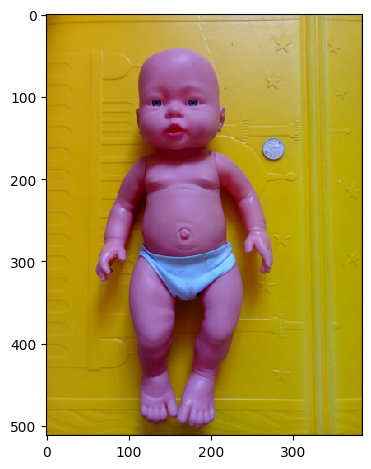

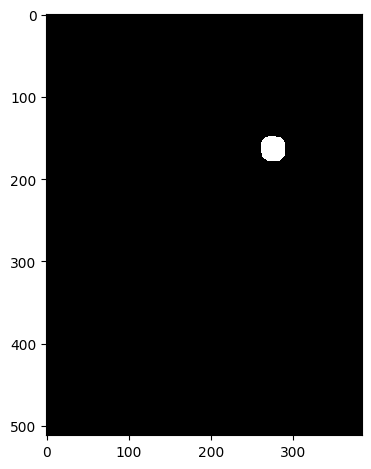

In [57]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(y_train[image_x]))
plt.show()

## Build the model

In [58]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

## Contraction path

In [59]:
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

## Expansive path

In [60]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [61]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.MeanIoU(num_classes=2)])

## Model Checkpoint

In [62]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_head.keras', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_mean_io_u_3', mode='max'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')]

## Training

In [63]:
result = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=1000, callbacks=callbacks)

Epoch 1/1000
2/2 [==============================] - ETA: 0s - loss: 0.4157 - mean_io_u_3: 0.4979

2/2 [==============================] - 8s 860ms/step - loss: 0.4157 - mean_io_u_3: 0.4979 - val_loss: 0.1893 - val_mean_io_u_3: 0.4980
Epoch 2/1000
2/2 [==============================] - ETA: 0s - loss: 0.1765 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 191ms/step - loss: 0.1765 - mean_io_u_3: 0.4979 - val_loss: 0.0381 - val_mean_io_u_3: 0.4980
Epoch 3/1000
2/2 [==============================] - ETA: 0s - loss: 0.0591 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 202ms/step - loss: 0.0591 - mean_io_u_3: 0.4979 - val_loss: 0.0354 - val_mean_io_u_3: 0.4980
Epoch 4/1000
2/2 [==============================] - ETA: 0s - loss: 0.0384 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 181ms/step - loss: 0.0384 - mean_io_u_3: 0.4979 - val_loss: 0.0337 - val_mean_io_u_3: 0.4980
Epoch 5/1000
2/2 [==============================] - ETA: 0s - loss: 0.0337 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 127ms/step - loss: 0.0337 - mean_io_u_3: 0.4979 - val_loss: 0.0322 - val_mean_io_u_3: 0.4980
Epoch 6/1000
2/2 [==============================] - ETA: 0s - loss: 0.0335 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 129ms/step - loss: 0.0335 - mean_io_u_3: 0.4979 - val_loss: 0.0317 - val_mean_io_u_3: 0.4980
Epoch 7/1000
2/2 [==============================] - ETA: 0s - loss: 0.0337 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 134ms/step - loss: 0.0337 - mean_io_u_3: 0.4979 - val_loss: 0.0315 - val_mean_io_u_3: 0.4980
Epoch 8/1000
2/2 [==============================] - ETA: 0s - loss: 0.0336 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 129ms/step - loss: 0.0336 - mean_io_u_3: 0.4979 - val_loss: 0.0313 - val_mean_io_u_3: 0.4980
Epoch 9/1000
2/2 [==============================] - ETA: 0s - loss: 0.0331 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 0.0331 - mean_io_u_3: 0.4979 - val_loss: 0.0311 - val_mean_io_u_3: 0.4980
Epoch 10/1000
2/2 [==============================] - ETA: 0s - loss: 0.0326 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 129ms/step - loss: 0.0326 - mean_io_u_3: 0.4979 - val_loss: 0.0310 - val_mean_io_u_3: 0.4980
Epoch 11/1000
2/2 [==============================] - ETA: 0s - loss: 0.0322 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 129ms/step - loss: 0.0322 - mean_io_u_3: 0.4979 - val_loss: 0.0310 - val_mean_io_u_3: 0.4980
Epoch 12/1000
2/2 [==============================] - ETA: 0s - loss: 0.0317 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 133ms/step - loss: 0.0317 - mean_io_u_3: 0.4979 - val_loss: 0.0310 - val_mean_io_u_3: 0.4980
Epoch 13/1000
2/2 [==============================] - ETA: 0s - loss: 0.0315 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 0.0315 - mean_io_u_3: 0.4979 - val_loss: 0.0311 - val_mean_io_u_3: 0.4980
Epoch 14/1000
2/2 [==============================] - ETA: 0s - loss: 0.0314 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 130ms/step - loss: 0.0314 - mean_io_u_3: 0.4979 - val_loss: 0.0310 - val_mean_io_u_3: 0.4980
Epoch 15/1000
2/2 [==============================] - ETA: 0s - loss: 0.0312 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 173ms/step - loss: 0.0312 - mean_io_u_3: 0.4979 - val_loss: 0.0309 - val_mean_io_u_3: 0.4980
Epoch 16/1000
2/2 [==============================] - ETA: 0s - loss: 0.0309 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 131ms/step - loss: 0.0309 - mean_io_u_3: 0.4979 - val_loss: 0.0307 - val_mean_io_u_3: 0.4980
Epoch 17/1000
2/2 [==============================] - ETA: 0s - loss: 0.0308 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 130ms/step - loss: 0.0308 - mean_io_u_3: 0.4979 - val_loss: 0.0302 - val_mean_io_u_3: 0.4980
Epoch 18/1000
2/2 [==============================] - ETA: 0s - loss: 0.0305 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 129ms/step - loss: 0.0305 - mean_io_u_3: 0.4979 - val_loss: 0.0297 - val_mean_io_u_3: 0.4980
Epoch 19/1000
2/2 [==============================] - ETA: 0s - loss: 0.0304 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 135ms/step - loss: 0.0304 - mean_io_u_3: 0.4979 - val_loss: 0.0291 - val_mean_io_u_3: 0.4980
Epoch 20/1000
2/2 [==============================] - ETA: 0s - loss: 0.0301 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 149ms/step - loss: 0.0301 - mean_io_u_3: 0.4979 - val_loss: 0.0287 - val_mean_io_u_3: 0.4980
Epoch 21/1000
2/2 [==============================] - ETA: 0s - loss: 0.0296 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 196ms/step - loss: 0.0296 - mean_io_u_3: 0.4979 - val_loss: 0.0286 - val_mean_io_u_3: 0.4980
Epoch 22/1000
2/2 [==============================] - ETA: 0s - loss: 0.0293 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 196ms/step - loss: 0.0293 - mean_io_u_3: 0.4979 - val_loss: 0.0285 - val_mean_io_u_3: 0.4980
Epoch 23/1000
2/2 [==============================] - ETA: 0s - loss: 0.0290 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 186ms/step - loss: 0.0290 - mean_io_u_3: 0.4979 - val_loss: 0.0283 - val_mean_io_u_3: 0.4980
Epoch 24/1000
2/2 [==============================] - ETA: 0s - loss: 0.0287 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 131ms/step - loss: 0.0287 - mean_io_u_3: 0.4979 - val_loss: 0.0279 - val_mean_io_u_3: 0.4980
Epoch 25/1000
2/2 [==============================] - ETA: 0s - loss: 0.0282 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 131ms/step - loss: 0.0282 - mean_io_u_3: 0.4979 - val_loss: 0.0274 - val_mean_io_u_3: 0.4980
Epoch 26/1000
2/2 [==============================] - ETA: 0s - loss: 0.0279 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 132ms/step - loss: 0.0279 - mean_io_u_3: 0.4979 - val_loss: 0.0269 - val_mean_io_u_3: 0.4980
Epoch 27/1000
2/2 [==============================] - ETA: 0s - loss: 0.0274 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 129ms/step - loss: 0.0274 - mean_io_u_3: 0.4979 - val_loss: 0.0267 - val_mean_io_u_3: 0.4980
Epoch 28/1000
2/2 [==============================] - ETA: 0s - loss: 0.0269 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 132ms/step - loss: 0.0269 - mean_io_u_3: 0.4979 - val_loss: 0.0267 - val_mean_io_u_3: 0.4980
Epoch 29/1000
2/2 [==============================] - ETA: 0s - loss: 0.0264 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 130ms/step - loss: 0.0264 - mean_io_u_3: 0.4979 - val_loss: 0.0263 - val_mean_io_u_3: 0.4980
Epoch 30/1000
2/2 [==============================] - ETA: 0s - loss: 0.0256 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 132ms/step - loss: 0.0256 - mean_io_u_3: 0.4979 - val_loss: 0.0256 - val_mean_io_u_3: 0.4980
Epoch 31/1000
2/2 [==============================] - ETA: 0s - loss: 0.0250 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 131ms/step - loss: 0.0250 - mean_io_u_3: 0.4979 - val_loss: 0.0259 - val_mean_io_u_3: 0.4980
Epoch 32/1000
2/2 [==============================] - ETA: 0s - loss: 0.0242 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 132ms/step - loss: 0.0242 - mean_io_u_3: 0.4979 - val_loss: 0.0261 - val_mean_io_u_3: 0.4980
Epoch 33/1000
2/2 [==============================] - ETA: 0s - loss: 0.0233 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 130ms/step - loss: 0.0233 - mean_io_u_3: 0.4979 - val_loss: 0.0254 - val_mean_io_u_3: 0.4980
Epoch 34/1000
2/2 [==============================] - ETA: 0s - loss: 0.0226 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 129ms/step - loss: 0.0226 - mean_io_u_3: 0.4979 - val_loss: 0.0267 - val_mean_io_u_3: 0.4980
Epoch 35/1000
2/2 [==============================] - ETA: 0s - loss: 0.0219 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 132ms/step - loss: 0.0219 - mean_io_u_3: 0.4979 - val_loss: 0.0277 - val_mean_io_u_3: 0.4980
Epoch 36/1000
2/2 [==============================] - ETA: 0s - loss: 0.0212 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 135ms/step - loss: 0.0212 - mean_io_u_3: 0.4979 - val_loss: 0.0276 - val_mean_io_u_3: 0.4980
Epoch 37/1000
2/2 [==============================] - ETA: 0s - loss: 0.0202 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 132ms/step - loss: 0.0202 - mean_io_u_3: 0.4979 - val_loss: 0.0294 - val_mean_io_u_3: 0.4980
Epoch 38/1000
2/2 [==============================] - ETA: 0s - loss: 0.0199 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 131ms/step - loss: 0.0199 - mean_io_u_3: 0.4979 - val_loss: 0.0304 - val_mean_io_u_3: 0.4980
Epoch 39/1000
2/2 [==============================] - ETA: 0s - loss: 0.0193 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 152ms/step - loss: 0.0193 - mean_io_u_3: 0.4979 - val_loss: 0.0341 - val_mean_io_u_3: 0.4980
Epoch 40/1000
2/2 [==============================] - ETA: 0s - loss: 0.0190 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 189ms/step - loss: 0.0190 - mean_io_u_3: 0.4979 - val_loss: 0.0342 - val_mean_io_u_3: 0.4980
Epoch 41/1000
2/2 [==============================] - ETA: 0s - loss: 0.0179 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 189ms/step - loss: 0.0179 - mean_io_u_3: 0.4979 - val_loss: 0.0328 - val_mean_io_u_3: 0.4980
Epoch 42/1000
2/2 [==============================] - ETA: 0s - loss: 0.0171 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 190ms/step - loss: 0.0171 - mean_io_u_3: 0.4979 - val_loss: 0.0345 - val_mean_io_u_3: 0.4980
Epoch 43/1000
2/2 [==============================] - ETA: 0s - loss: 0.0167 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 192ms/step - loss: 0.0167 - mean_io_u_3: 0.4979 - val_loss: 0.0305 - val_mean_io_u_3: 0.4980
Epoch 44/1000
2/2 [==============================] - ETA: 0s - loss: 0.0159 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 132ms/step - loss: 0.0159 - mean_io_u_3: 0.4979 - val_loss: 0.0347 - val_mean_io_u_3: 0.4980
Epoch 45/1000
2/2 [==============================] - ETA: 0s - loss: 0.0156 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 133ms/step - loss: 0.0156 - mean_io_u_3: 0.4979 - val_loss: 0.0327 - val_mean_io_u_3: 0.4980
Epoch 46/1000
2/2 [==============================] - ETA: 0s - loss: 0.0148 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 132ms/step - loss: 0.0148 - mean_io_u_3: 0.4979 - val_loss: 0.0308 - val_mean_io_u_3: 0.4980
Epoch 47/1000
2/2 [==============================] - ETA: 0s - loss: 0.0140 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 131ms/step - loss: 0.0140 - mean_io_u_3: 0.4979 - val_loss: 0.0305 - val_mean_io_u_3: 0.4980
Epoch 48/1000
2/2 [==============================] - ETA: 0s - loss: 0.0135 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 131ms/step - loss: 0.0135 - mean_io_u_3: 0.4979 - val_loss: 0.0286 - val_mean_io_u_3: 0.4980
Epoch 49/1000
2/2 [==============================] - ETA: 0s - loss: 0.0127 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 134ms/step - loss: 0.0127 - mean_io_u_3: 0.4979 - val_loss: 0.0287 - val_mean_io_u_3: 0.4980
Epoch 50/1000
2/2 [==============================] - ETA: 0s - loss: 0.0124 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 134ms/step - loss: 0.0124 - mean_io_u_3: 0.4979 - val_loss: 0.0323 - val_mean_io_u_3: 0.4980
Epoch 51/1000
2/2 [==============================] - ETA: 0s - loss: 0.0129 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 131ms/step - loss: 0.0129 - mean_io_u_3: 0.4979 - val_loss: 0.0150 - val_mean_io_u_3: 0.4980
Epoch 52/1000
2/2 [==============================] - ETA: 0s - loss: 0.0119 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 129ms/step - loss: 0.0119 - mean_io_u_3: 0.4979 - val_loss: 0.0323 - val_mean_io_u_3: 0.4980
Epoch 53/1000
2/2 [==============================] - ETA: 0s - loss: 0.0132 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 173ms/step - loss: 0.0132 - mean_io_u_3: 0.4979 - val_loss: 0.0102 - val_mean_io_u_3: 0.4980
Epoch 54/1000
2/2 [==============================] - ETA: 0s - loss: 0.0123 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 172ms/step - loss: 0.0123 - mean_io_u_3: 0.4979 - val_loss: 0.0229 - val_mean_io_u_3: 0.4980
Epoch 55/1000
2/2 [==============================] - ETA: 0s - loss: 0.0121 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 136ms/step - loss: 0.0121 - mean_io_u_3: 0.4979 - val_loss: 0.0108 - val_mean_io_u_3: 0.4980
Epoch 56/1000
2/2 [==============================] - ETA: 0s - loss: 0.0095 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 131ms/step - loss: 0.0095 - mean_io_u_3: 0.4979 - val_loss: 0.0093 - val_mean_io_u_3: 0.4980
Epoch 57/1000
2/2 [==============================] - ETA: 0s - loss: 0.0106 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 136ms/step - loss: 0.0106 - mean_io_u_3: 0.4979 - val_loss: 0.0133 - val_mean_io_u_3: 0.4980
Epoch 58/1000
2/2 [==============================] - ETA: 0s - loss: 0.0096 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 195ms/step - loss: 0.0096 - mean_io_u_3: 0.4979 - val_loss: 0.0087 - val_mean_io_u_3: 0.4980
Epoch 59/1000
2/2 [==============================] - ETA: 0s - loss: 0.0078 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 160ms/step - loss: 0.0078 - mean_io_u_3: 0.4979 - val_loss: 0.0079 - val_mean_io_u_3: 0.4980
Epoch 60/1000
2/2 [==============================] - ETA: 0s - loss: 0.0066 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 188ms/step - loss: 0.0066 - mean_io_u_3: 0.4979 - val_loss: 0.0086 - val_mean_io_u_3: 0.4980
Epoch 61/1000
2/2 [==============================] - ETA: 0s - loss: 0.0053 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 159ms/step - loss: 0.0053 - mean_io_u_3: 0.4979 - val_loss: 0.0047 - val_mean_io_u_3: 0.4980
Epoch 62/1000
2/2 [==============================] - ETA: 0s - loss: 0.0040 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 195ms/step - loss: 0.0040 - mean_io_u_3: 0.4979 - val_loss: 0.0043 - val_mean_io_u_3: 0.4980
Epoch 63/1000
2/2 [==============================] - ETA: 0s - loss: 0.0100 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 168ms/step - loss: 0.0100 - mean_io_u_3: 0.4979 - val_loss: 0.0060 - val_mean_io_u_3: 0.4980
Epoch 64/1000
2/2 [==============================] - ETA: 0s - loss: 0.0082 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 131ms/step - loss: 0.0082 - mean_io_u_3: 0.4979 - val_loss: 0.0105 - val_mean_io_u_3: 0.4980
Epoch 65/1000
2/2 [==============================] - ETA: 0s - loss: 0.0124 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 133ms/step - loss: 0.0124 - mean_io_u_3: 0.4979 - val_loss: 0.0183 - val_mean_io_u_3: 0.4980
Epoch 66/1000
2/2 [==============================] - ETA: 0s - loss: 0.0236 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 0.0236 - mean_io_u_3: 0.4979 - val_loss: 0.0108 - val_mean_io_u_3: 0.4980
Epoch 67/1000
2/2 [==============================] - ETA: 0s - loss: 0.0123 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 136ms/step - loss: 0.0123 - mean_io_u_3: 0.4979 - val_loss: 0.0097 - val_mean_io_u_3: 0.4980
Epoch 68/1000
2/2 [==============================] - ETA: 0s - loss: 0.0103 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 131ms/step - loss: 0.0103 - mean_io_u_3: 0.4979 - val_loss: 0.0101 - val_mean_io_u_3: 0.4980
Epoch 69/1000
2/2 [==============================] - ETA: 0s - loss: 0.0108 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 142ms/step - loss: 0.0108 - mean_io_u_3: 0.4979 - val_loss: 0.0105 - val_mean_io_u_3: 0.4980
Epoch 70/1000
2/2 [==============================] - ETA: 0s - loss: 0.0104 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 172ms/step - loss: 0.0104 - mean_io_u_3: 0.4979 - val_loss: 0.0117 - val_mean_io_u_3: 0.4980
Epoch 71/1000
2/2 [==============================] - ETA: 0s - loss: 0.0103 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 0.0103 - mean_io_u_3: 0.4979 - val_loss: 0.0119 - val_mean_io_u_3: 0.4980
Epoch 72/1000
2/2 [==============================] - ETA: 0s - loss: 0.0102 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 135ms/step - loss: 0.0102 - mean_io_u_3: 0.4979 - val_loss: 0.0100 - val_mean_io_u_3: 0.4980
Epoch 73/1000
2/2 [==============================] - ETA: 0s - loss: 0.0092 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 132ms/step - loss: 0.0092 - mean_io_u_3: 0.4979 - val_loss: 0.0086 - val_mean_io_u_3: 0.4980
Epoch 74/1000
2/2 [==============================] - ETA: 0s - loss: 0.0079 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 178ms/step - loss: 0.0079 - mean_io_u_3: 0.4979 - val_loss: 0.0075 - val_mean_io_u_3: 0.4980
Epoch 75/1000
2/2 [==============================] - ETA: 0s - loss: 0.0070 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 172ms/step - loss: 0.0070 - mean_io_u_3: 0.4979 - val_loss: 0.0062 - val_mean_io_u_3: 0.4980
Epoch 76/1000
2/2 [==============================] - ETA: 0s - loss: 0.0053 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 134ms/step - loss: 0.0053 - mean_io_u_3: 0.4979 - val_loss: 0.0054 - val_mean_io_u_3: 0.4980
Epoch 77/1000
2/2 [==============================] - ETA: 0s - loss: 0.0040 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 194ms/step - loss: 0.0040 - mean_io_u_3: 0.4979 - val_loss: 0.0040 - val_mean_io_u_3: 0.4980
Epoch 78/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_3: 0.4980

2/2 [==============================] - 1s 160ms/step - loss: 0.0026 - mean_io_u_3: 0.4980 - val_loss: 0.0020 - val_mean_io_u_3: 0.4980
Epoch 79/1000
2/2 [==============================] - ETA: 0s - loss: 0.0077 - mean_io_u_3: 0.5150

2/2 [==============================] - 1s 191ms/step - loss: 0.0077 - mean_io_u_3: 0.5150 - val_loss: 0.0218 - val_mean_io_u_3: 0.4980
Epoch 80/1000
2/2 [==============================] - ETA: 0s - loss: 0.0301 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 189ms/step - loss: 0.0301 - mean_io_u_3: 0.4979 - val_loss: 0.0135 - val_mean_io_u_3: 0.4980
Epoch 81/1000
2/2 [==============================] - ETA: 0s - loss: 0.0162 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 190ms/step - loss: 0.0162 - mean_io_u_3: 0.4979 - val_loss: 0.0098 - val_mean_io_u_3: 0.4980
Epoch 82/1000
2/2 [==============================] - ETA: 0s - loss: 0.0084 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 142ms/step - loss: 0.0084 - mean_io_u_3: 0.4979 - val_loss: 0.0246 - val_mean_io_u_3: 0.4980
Epoch 83/1000
2/2 [==============================] - ETA: 0s - loss: 0.0148 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 136ms/step - loss: 0.0148 - mean_io_u_3: 0.4979 - val_loss: 0.0113 - val_mean_io_u_3: 0.4980
Epoch 84/1000
2/2 [==============================] - ETA: 0s - loss: 0.0081 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 136ms/step - loss: 0.0081 - mean_io_u_3: 0.4979 - val_loss: 0.0096 - val_mean_io_u_3: 0.4980
Epoch 85/1000
2/2 [==============================] - ETA: 0s - loss: 0.0086 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 132ms/step - loss: 0.0086 - mean_io_u_3: 0.4979 - val_loss: 0.0107 - val_mean_io_u_3: 0.4980
Epoch 86/1000
2/2 [==============================] - ETA: 0s - loss: 0.0094 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 133ms/step - loss: 0.0094 - mean_io_u_3: 0.4979 - val_loss: 0.0104 - val_mean_io_u_3: 0.4980
Epoch 87/1000
2/2 [==============================] - ETA: 0s - loss: 0.0081 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 133ms/step - loss: 0.0081 - mean_io_u_3: 0.4979 - val_loss: 0.0086 - val_mean_io_u_3: 0.4980
Epoch 88/1000
2/2 [==============================] - ETA: 0s - loss: 0.0054 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 174ms/step - loss: 0.0054 - mean_io_u_3: 0.4979 - val_loss: 0.0073 - val_mean_io_u_3: 0.4980
Epoch 89/1000
2/2 [==============================] - ETA: 0s - loss: 0.0045 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 176ms/step - loss: 0.0045 - mean_io_u_3: 0.4979 - val_loss: 0.0056 - val_mean_io_u_3: 0.4980
Epoch 90/1000
2/2 [==============================] - ETA: 0s - loss: 0.0035 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 133ms/step - loss: 0.0035 - mean_io_u_3: 0.4979 - val_loss: 0.0031 - val_mean_io_u_3: 0.4980
Epoch 91/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 134ms/step - loss: 0.0016 - mean_io_u_3: 0.4979 - val_loss: 0.0025 - val_mean_io_u_3: 0.4980
Epoch 92/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_3: 0.5020

2/2 [==============================] - 1s 131ms/step - loss: 0.0014 - mean_io_u_3: 0.5020 - val_loss: 0.0012 - val_mean_io_u_3: 0.4980
Epoch 93/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_3: 0.5942

2/2 [==============================] - 1s 129ms/step - loss: 0.0012 - mean_io_u_3: 0.5942 - val_loss: 0.0017 - val_mean_io_u_3: 0.4980
Epoch 94/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_3: 0.5643

2/2 [==============================] - 1s 131ms/step - loss: 0.0013 - mean_io_u_3: 0.5643 - val_loss: 0.0018 - val_mean_io_u_3: 0.4980
Epoch 95/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_3: 0.6365

2/2 [==============================] - 1s 134ms/step - loss: 0.0010 - mean_io_u_3: 0.6365 - val_loss: 6.9980e-04 - val_mean_io_u_3: 0.5425
Epoch 96/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_3: 0.7849

2/2 [==============================] - 1s 173ms/step - loss: 0.0027 - mean_io_u_3: 0.7849 - val_loss: 0.0023 - val_mean_io_u_3: 0.4980
Epoch 97/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_3: 0.6039

2/2 [==============================] - 1s 149ms/step - loss: 0.0016 - mean_io_u_3: 0.6039 - val_loss: 0.0024 - val_mean_io_u_3: 0.4980
Epoch 98/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_3: 0.5922

2/2 [==============================] - 1s 197ms/step - loss: 0.0016 - mean_io_u_3: 0.5922 - val_loss: 7.0774e-04 - val_mean_io_u_3: 0.4980
Epoch 99/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_3: 0.6989

2/2 [==============================] - 1s 155ms/step - loss: 0.0012 - mean_io_u_3: 0.6989 - val_loss: 6.8758e-04 - val_mean_io_u_3: 0.4980
Epoch 100/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.6500

2/2 [==============================] - 1s 200ms/step - loss: 0.0011 - mean_io_u_3: 0.6500 - val_loss: 0.0016 - val_mean_io_u_3: 0.4980
Epoch 101/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_3: 0.5476

2/2 [==============================] - 1s 140ms/step - loss: 0.0012 - mean_io_u_3: 0.5476 - val_loss: 0.0017 - val_mean_io_u_3: 0.4980
Epoch 102/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.5470

2/2 [==============================] - 1s 132ms/step - loss: 0.0011 - mean_io_u_3: 0.5470 - val_loss: 0.0010 - val_mean_io_u_3: 0.4980
Epoch 103/1000
2/2 [==============================] - ETA: 0s - loss: 8.5756e-04 - mean_io_u_3: 0.5620

2/2 [==============================] - 1s 140ms/step - loss: 8.5756e-04 - mean_io_u_3: 0.5620 - val_loss: 8.6173e-04 - val_mean_io_u_3: 0.4980
Epoch 104/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.5852

2/2 [==============================] - 1s 132ms/step - loss: 0.0011 - mean_io_u_3: 0.5852 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 105/1000
2/2 [==============================] - ETA: 0s - loss: 8.5406e-04 - mean_io_u_3: 0.5463

2/2 [==============================] - 1s 135ms/step - loss: 8.5406e-04 - mean_io_u_3: 0.5463 - val_loss: 0.0016 - val_mean_io_u_3: 0.4980
Epoch 106/1000
2/2 [==============================] - ETA: 0s - loss: 9.2920e-04 - mean_io_u_3: 0.5103

2/2 [==============================] - 1s 131ms/step - loss: 9.2920e-04 - mean_io_u_3: 0.5103 - val_loss: 0.0014 - val_mean_io_u_3: 0.4980
Epoch 107/1000
2/2 [==============================] - ETA: 0s - loss: 8.8481e-04 - mean_io_u_3: 0.5099

2/2 [==============================] - 1s 172ms/step - loss: 8.8481e-04 - mean_io_u_3: 0.5099 - val_loss: 0.0010 - val_mean_io_u_3: 0.4980
Epoch 108/1000
2/2 [==============================] - ETA: 0s - loss: 7.7381e-04 - mean_io_u_3: 0.5311

2/2 [==============================] - 1s 129ms/step - loss: 7.7381e-04 - mean_io_u_3: 0.5311 - val_loss: 0.0010 - val_mean_io_u_3: 0.4980
Epoch 109/1000
2/2 [==============================] - ETA: 0s - loss: 7.9802e-04 - mean_io_u_3: 0.5190

2/2 [==============================] - 1s 174ms/step - loss: 7.9802e-04 - mean_io_u_3: 0.5190 - val_loss: 0.0014 - val_mean_io_u_3: 0.4980
Epoch 110/1000
2/2 [==============================] - ETA: 0s - loss: 8.0049e-04 - mean_io_u_3: 0.5039

2/2 [==============================] - 1s 137ms/step - loss: 8.0049e-04 - mean_io_u_3: 0.5039 - val_loss: 0.0017 - val_mean_io_u_3: 0.4980
Epoch 111/1000
2/2 [==============================] - ETA: 0s - loss: 9.5069e-04 - mean_io_u_3: 0.5023

2/2 [==============================] - 1s 135ms/step - loss: 9.5069e-04 - mean_io_u_3: 0.5023 - val_loss: 0.0012 - val_mean_io_u_3: 0.4980
Epoch 112/1000
2/2 [==============================] - ETA: 0s - loss: 7.9522e-04 - mean_io_u_3: 0.5063

2/2 [==============================] - 1s 176ms/step - loss: 7.9522e-04 - mean_io_u_3: 0.5063 - val_loss: 7.1699e-04 - val_mean_io_u_3: 0.4980
Epoch 113/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.5423

2/2 [==============================] - 1s 175ms/step - loss: 0.0011 - mean_io_u_3: 0.5423 - val_loss: 0.0010 - val_mean_io_u_3: 0.4980
Epoch 114/1000
2/2 [==============================] - ETA: 0s - loss: 7.3590e-04 - mean_io_u_3: 0.5041

2/2 [==============================] - 1s 136ms/step - loss: 7.3590e-04 - mean_io_u_3: 0.5041 - val_loss: 0.0016 - val_mean_io_u_3: 0.4980
Epoch 115/1000
2/2 [==============================] - ETA: 0s - loss: 8.7844e-04 - mean_io_u_3: 0.4995

2/2 [==============================] - 1s 175ms/step - loss: 8.7844e-04 - mean_io_u_3: 0.4995 - val_loss: 0.0015 - val_mean_io_u_3: 0.4980
Epoch 116/1000
2/2 [==============================] - ETA: 0s - loss: 8.7015e-04 - mean_io_u_3: 0.4996

2/2 [==============================] - 1s 191ms/step - loss: 8.7015e-04 - mean_io_u_3: 0.4996 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 117/1000
2/2 [==============================] - ETA: 0s - loss: 8.2345e-04 - mean_io_u_3: 0.5020

2/2 [==============================] - 1s 157ms/step - loss: 8.2345e-04 - mean_io_u_3: 0.5020 - val_loss: 8.7695e-04 - val_mean_io_u_3: 0.4980
Epoch 118/1000
2/2 [==============================] - ETA: 0s - loss: 8.1288e-04 - mean_io_u_3: 0.5061

2/2 [==============================] - 1s 192ms/step - loss: 8.1288e-04 - mean_io_u_3: 0.5061 - val_loss: 9.3296e-04 - val_mean_io_u_3: 0.4980
Epoch 119/1000
2/2 [==============================] - ETA: 0s - loss: 7.7499e-04 - mean_io_u_3: 0.5041

2/2 [==============================] - 1s 158ms/step - loss: 7.7499e-04 - mean_io_u_3: 0.5041 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 120/1000
2/2 [==============================] - ETA: 0s - loss: 6.9608e-04 - mean_io_u_3: 0.4990

2/2 [==============================] - 1s 145ms/step - loss: 6.9608e-04 - mean_io_u_3: 0.4990 - val_loss: 0.0012 - val_mean_io_u_3: 0.4980
Epoch 121/1000
2/2 [==============================] - ETA: 0s - loss: 6.9000e-04 - mean_io_u_3: 0.5002

2/2 [==============================] - 1s 137ms/step - loss: 6.9000e-04 - mean_io_u_3: 0.5002 - val_loss: 0.0012 - val_mean_io_u_3: 0.4980
Epoch 122/1000
2/2 [==============================] - ETA: 0s - loss: 6.4485e-04 - mean_io_u_3: 0.4997

2/2 [==============================] - 1s 135ms/step - loss: 6.4485e-04 - mean_io_u_3: 0.4997 - val_loss: 0.0012 - val_mean_io_u_3: 0.4980
Epoch 123/1000
2/2 [==============================] - ETA: 0s - loss: 7.1625e-04 - mean_io_u_3: 0.5027

2/2 [==============================] - 1s 133ms/step - loss: 7.1625e-04 - mean_io_u_3: 0.5027 - val_loss: 9.6973e-04 - val_mean_io_u_3: 0.4980
Epoch 124/1000
2/2 [==============================] - ETA: 0s - loss: 7.3131e-04 - mean_io_u_3: 0.5033

2/2 [==============================] - 1s 133ms/step - loss: 7.3131e-04 - mean_io_u_3: 0.5033 - val_loss: 9.2697e-04 - val_mean_io_u_3: 0.4980
Epoch 125/1000
2/2 [==============================] - ETA: 0s - loss: 6.3775e-04 - mean_io_u_3: 0.5061

2/2 [==============================] - 1s 136ms/step - loss: 6.3775e-04 - mean_io_u_3: 0.5061 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 126/1000
2/2 [==============================] - ETA: 0s - loss: 7.0940e-04 - mean_io_u_3: 0.5020

2/2 [==============================] - 1s 136ms/step - loss: 7.0940e-04 - mean_io_u_3: 0.5020 - val_loss: 0.0013 - val_mean_io_u_3: 0.4980
Epoch 127/1000
2/2 [==============================] - ETA: 0s - loss: 8.4069e-04 - mean_io_u_3: 0.5000

2/2 [==============================] - 1s 132ms/step - loss: 8.4069e-04 - mean_io_u_3: 0.5000 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 128/1000
2/2 [==============================] - ETA: 0s - loss: 6.8920e-04 - mean_io_u_3: 0.5060

2/2 [==============================] - 1s 138ms/step - loss: 6.8920e-04 - mean_io_u_3: 0.5060 - val_loss: 9.1487e-04 - val_mean_io_u_3: 0.4980
Epoch 129/1000
2/2 [==============================] - ETA: 0s - loss: 7.7210e-04 - mean_io_u_3: 0.5090

2/2 [==============================] - 1s 135ms/step - loss: 7.7210e-04 - mean_io_u_3: 0.5090 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 130/1000
2/2 [==============================] - ETA: 0s - loss: 7.5276e-04 - mean_io_u_3: 0.5045

2/2 [==============================] - 1s 132ms/step - loss: 7.5276e-04 - mean_io_u_3: 0.5045 - val_loss: 0.0014 - val_mean_io_u_3: 0.4980
Epoch 131/1000
2/2 [==============================] - ETA: 0s - loss: 7.1900e-04 - mean_io_u_3: 0.5012

2/2 [==============================] - 1s 133ms/step - loss: 7.1900e-04 - mean_io_u_3: 0.5012 - val_loss: 0.0012 - val_mean_io_u_3: 0.4980
Epoch 132/1000
2/2 [==============================] - ETA: 0s - loss: 7.1031e-04 - mean_io_u_3: 0.5024

2/2 [==============================] - 1s 135ms/step - loss: 7.1031e-04 - mean_io_u_3: 0.5024 - val_loss: 8.9914e-04 - val_mean_io_u_3: 0.4980
Epoch 133/1000
2/2 [==============================] - ETA: 0s - loss: 6.7048e-04 - mean_io_u_3: 0.5166

2/2 [==============================] - 1s 176ms/step - loss: 6.7048e-04 - mean_io_u_3: 0.5166 - val_loss: 0.0010 - val_mean_io_u_3: 0.4980
Epoch 134/1000
2/2 [==============================] - ETA: 0s - loss: 6.3923e-04 - mean_io_u_3: 0.5088

2/2 [==============================] - 1s 177ms/step - loss: 6.3923e-04 - mean_io_u_3: 0.5088 - val_loss: 0.0014 - val_mean_io_u_3: 0.4980
Epoch 135/1000
2/2 [==============================] - ETA: 0s - loss: 8.0349e-04 - mean_io_u_3: 0.4989

2/2 [==============================] - 1s 196ms/step - loss: 8.0349e-04 - mean_io_u_3: 0.4989 - val_loss: 0.0014 - val_mean_io_u_3: 0.4980
Epoch 136/1000
2/2 [==============================] - ETA: 0s - loss: 7.5818e-04 - mean_io_u_3: 0.4999

2/2 [==============================] - 1s 188ms/step - loss: 7.5818e-04 - mean_io_u_3: 0.4999 - val_loss: 9.4283e-04 - val_mean_io_u_3: 0.4980
Epoch 137/1000
2/2 [==============================] - ETA: 0s - loss: 6.8139e-04 - mean_io_u_3: 0.5065

2/2 [==============================] - 1s 189ms/step - loss: 6.8139e-04 - mean_io_u_3: 0.5065 - val_loss: 6.9549e-04 - val_mean_io_u_3: 0.4980
Epoch 138/1000
2/2 [==============================] - ETA: 0s - loss: 7.8439e-04 - mean_io_u_3: 0.5172

2/2 [==============================] - 1s 192ms/step - loss: 7.8439e-04 - mean_io_u_3: 0.5172 - val_loss: 9.0367e-04 - val_mean_io_u_3: 0.4980
Epoch 139/1000
2/2 [==============================] - ETA: 0s - loss: 6.5253e-04 - mean_io_u_3: 0.5051

2/2 [==============================] - 1s 166ms/step - loss: 6.5253e-04 - mean_io_u_3: 0.5051 - val_loss: 0.0013 - val_mean_io_u_3: 0.4980
Epoch 140/1000
2/2 [==============================] - ETA: 0s - loss: 7.1431e-04 - mean_io_u_3: 0.4989

2/2 [==============================] - 1s 134ms/step - loss: 7.1431e-04 - mean_io_u_3: 0.4989 - val_loss: 0.0013 - val_mean_io_u_3: 0.4980
Epoch 141/1000
2/2 [==============================] - ETA: 0s - loss: 7.4364e-04 - mean_io_u_3: 0.4996

2/2 [==============================] - 1s 135ms/step - loss: 7.4364e-04 - mean_io_u_3: 0.4996 - val_loss: 9.4862e-04 - val_mean_io_u_3: 0.4980
Epoch 142/1000
2/2 [==============================] - ETA: 0s - loss: 6.3147e-04 - mean_io_u_3: 0.5117

2/2 [==============================] - 1s 136ms/step - loss: 6.3147e-04 - mean_io_u_3: 0.5117 - val_loss: 7.9641e-04 - val_mean_io_u_3: 0.4980
Epoch 143/1000
2/2 [==============================] - ETA: 0s - loss: 6.9449e-04 - mean_io_u_3: 0.5158

2/2 [==============================] - 1s 138ms/step - loss: 6.9449e-04 - mean_io_u_3: 0.5158 - val_loss: 8.9919e-04 - val_mean_io_u_3: 0.4980
Epoch 144/1000
2/2 [==============================] - ETA: 0s - loss: 6.9875e-04 - mean_io_u_3: 0.5162

2/2 [==============================] - 1s 135ms/step - loss: 6.9875e-04 - mean_io_u_3: 0.5162 - val_loss: 0.0012 - val_mean_io_u_3: 0.4980
Epoch 145/1000
2/2 [==============================] - ETA: 0s - loss: 7.0814e-04 - mean_io_u_3: 0.5029

2/2 [==============================] - 1s 135ms/step - loss: 7.0814e-04 - mean_io_u_3: 0.5029 - val_loss: 0.0014 - val_mean_io_u_3: 0.4980
Epoch 146/1000
2/2 [==============================] - ETA: 0s - loss: 7.1315e-04 - mean_io_u_3: 0.5000

2/2 [==============================] - 1s 133ms/step - loss: 7.1315e-04 - mean_io_u_3: 0.5000 - val_loss: 0.0012 - val_mean_io_u_3: 0.4980
Epoch 147/1000
2/2 [==============================] - ETA: 0s - loss: 6.5570e-04 - mean_io_u_3: 0.5025

2/2 [==============================] - 1s 174ms/step - loss: 6.5570e-04 - mean_io_u_3: 0.5025 - val_loss: 8.5933e-04 - val_mean_io_u_3: 0.4980
Epoch 148/1000
2/2 [==============================] - ETA: 0s - loss: 6.6597e-04 - mean_io_u_3: 0.5203

2/2 [==============================] - 1s 133ms/step - loss: 6.6597e-04 - mean_io_u_3: 0.5203 - val_loss: 7.9936e-04 - val_mean_io_u_3: 0.4980
Epoch 149/1000
2/2 [==============================] - ETA: 0s - loss: 6.7146e-04 - mean_io_u_3: 0.5212

2/2 [==============================] - 1s 171ms/step - loss: 6.7146e-04 - mean_io_u_3: 0.5212 - val_loss: 9.8929e-04 - val_mean_io_u_3: 0.4980
Epoch 150/1000
2/2 [==============================] - ETA: 0s - loss: 6.2192e-04 - mean_io_u_3: 0.5103

2/2 [==============================] - 1s 135ms/step - loss: 6.2192e-04 - mean_io_u_3: 0.5103 - val_loss: 0.0012 - val_mean_io_u_3: 0.4980
Epoch 151/1000
2/2 [==============================] - ETA: 0s - loss: 6.7287e-04 - mean_io_u_3: 0.5035

2/2 [==============================] - 1s 140ms/step - loss: 6.7287e-04 - mean_io_u_3: 0.5035 - val_loss: 9.8735e-04 - val_mean_io_u_3: 0.4980
Epoch 152/1000
2/2 [==============================] - ETA: 0s - loss: 5.7619e-04 - mean_io_u_3: 0.5156

2/2 [==============================] - 1s 133ms/step - loss: 5.7619e-04 - mean_io_u_3: 0.5156 - val_loss: 9.0752e-04 - val_mean_io_u_3: 0.4980
Epoch 153/1000
2/2 [==============================] - ETA: 0s - loss: 6.1701e-04 - mean_io_u_3: 0.5197

2/2 [==============================] - 1s 174ms/step - loss: 6.1701e-04 - mean_io_u_3: 0.5197 - val_loss: 9.8268e-04 - val_mean_io_u_3: 0.4980
Epoch 154/1000
2/2 [==============================] - ETA: 0s - loss: 5.9719e-04 - mean_io_u_3: 0.5124

2/2 [==============================] - 1s 194ms/step - loss: 5.9719e-04 - mean_io_u_3: 0.5124 - val_loss: 0.0010 - val_mean_io_u_3: 0.4980
Epoch 155/1000
2/2 [==============================] - ETA: 0s - loss: 6.0809e-04 - mean_io_u_3: 0.5163

2/2 [==============================] - 1s 193ms/step - loss: 6.0809e-04 - mean_io_u_3: 0.5163 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 156/1000
2/2 [==============================] - ETA: 0s - loss: 6.7401e-04 - mean_io_u_3: 0.5102

2/2 [==============================] - 1s 153ms/step - loss: 6.7401e-04 - mean_io_u_3: 0.5102 - val_loss: 9.2970e-04 - val_mean_io_u_3: 0.4980
Epoch 157/1000
2/2 [==============================] - ETA: 0s - loss: 5.4859e-04 - mean_io_u_3: 0.5204

2/2 [==============================] - 1s 191ms/step - loss: 5.4859e-04 - mean_io_u_3: 0.5204 - val_loss: 9.1267e-04 - val_mean_io_u_3: 0.4980
Epoch 158/1000
2/2 [==============================] - ETA: 0s - loss: 6.2153e-04 - mean_io_u_3: 0.5244

2/2 [==============================] - 1s 174ms/step - loss: 6.2153e-04 - mean_io_u_3: 0.5244 - val_loss: 9.6338e-04 - val_mean_io_u_3: 0.4980
Epoch 159/1000
2/2 [==============================] - ETA: 0s - loss: 5.9570e-04 - mean_io_u_3: 0.5240

2/2 [==============================] - 1s 132ms/step - loss: 5.9570e-04 - mean_io_u_3: 0.5240 - val_loss: 0.0010 - val_mean_io_u_3: 0.4980
Epoch 160/1000
2/2 [==============================] - ETA: 0s - loss: 6.5391e-04 - mean_io_u_3: 0.5330

2/2 [==============================] - 1s 134ms/step - loss: 6.5391e-04 - mean_io_u_3: 0.5330 - val_loss: 9.7031e-04 - val_mean_io_u_3: 0.4980
Epoch 161/1000
2/2 [==============================] - ETA: 0s - loss: 5.5591e-04 - mean_io_u_3: 0.5379

2/2 [==============================] - 1s 133ms/step - loss: 5.5591e-04 - mean_io_u_3: 0.5379 - val_loss: 0.0010 - val_mean_io_u_3: 0.4980
Epoch 162/1000
2/2 [==============================] - ETA: 0s - loss: 6.3122e-04 - mean_io_u_3: 0.5517

2/2 [==============================] - 1s 176ms/step - loss: 6.3122e-04 - mean_io_u_3: 0.5517 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 163/1000
2/2 [==============================] - ETA: 0s - loss: 5.9934e-04 - mean_io_u_3: 0.5407

2/2 [==============================] - 1s 138ms/step - loss: 5.9934e-04 - mean_io_u_3: 0.5407 - val_loss: 0.0010 - val_mean_io_u_3: 0.4980
Epoch 164/1000
2/2 [==============================] - ETA: 0s - loss: 6.4612e-04 - mean_io_u_3: 0.5404

2/2 [==============================] - 1s 138ms/step - loss: 6.4612e-04 - mean_io_u_3: 0.5404 - val_loss: 8.4428e-04 - val_mean_io_u_3: 0.4980
Epoch 165/1000
2/2 [==============================] - ETA: 0s - loss: 6.0876e-04 - mean_io_u_3: 0.5759

2/2 [==============================] - 1s 140ms/step - loss: 6.0876e-04 - mean_io_u_3: 0.5759 - val_loss: 7.9971e-04 - val_mean_io_u_3: 0.4980
Epoch 166/1000
2/2 [==============================] - ETA: 0s - loss: 6.0445e-04 - mean_io_u_3: 0.5690

2/2 [==============================] - 1s 136ms/step - loss: 6.0445e-04 - mean_io_u_3: 0.5690 - val_loss: 9.7740e-04 - val_mean_io_u_3: 0.4980
Epoch 167/1000
2/2 [==============================] - ETA: 0s - loss: 5.3597e-04 - mean_io_u_3: 0.5471

2/2 [==============================] - 1s 152ms/step - loss: 5.3597e-04 - mean_io_u_3: 0.5471 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 168/1000
2/2 [==============================] - ETA: 0s - loss: 5.6063e-04 - mean_io_u_3: 0.5495

2/2 [==============================] - 1s 135ms/step - loss: 5.6063e-04 - mean_io_u_3: 0.5495 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 169/1000
2/2 [==============================] - ETA: 0s - loss: 5.9934e-04 - mean_io_u_3: 0.5358

2/2 [==============================] - 1s 138ms/step - loss: 5.9934e-04 - mean_io_u_3: 0.5358 - val_loss: 8.3213e-04 - val_mean_io_u_3: 0.4980
Epoch 170/1000
2/2 [==============================] - ETA: 0s - loss: 5.3265e-04 - mean_io_u_3: 0.5705

2/2 [==============================] - 1s 139ms/step - loss: 5.3265e-04 - mean_io_u_3: 0.5705 - val_loss: 7.9275e-04 - val_mean_io_u_3: 0.4980
Epoch 171/1000
2/2 [==============================] - ETA: 0s - loss: 5.2375e-04 - mean_io_u_3: 0.5652

2/2 [==============================] - 1s 175ms/step - loss: 5.2375e-04 - mean_io_u_3: 0.5652 - val_loss: 8.7095e-04 - val_mean_io_u_3: 0.4980
Epoch 172/1000
2/2 [==============================] - ETA: 0s - loss: 5.2549e-04 - mean_io_u_3: 0.5610

2/2 [==============================] - 1s 138ms/step - loss: 5.2549e-04 - mean_io_u_3: 0.5610 - val_loss: 8.8397e-04 - val_mean_io_u_3: 0.4980
Epoch 173/1000
2/2 [==============================] - ETA: 0s - loss: 6.2480e-04 - mean_io_u_3: 0.5775

2/2 [==============================] - 1s 192ms/step - loss: 6.2480e-04 - mean_io_u_3: 0.5775 - val_loss: 8.9799e-04 - val_mean_io_u_3: 0.4980
Epoch 174/1000
2/2 [==============================] - ETA: 0s - loss: 5.8238e-04 - mean_io_u_3: 0.5762

2/2 [==============================] - 1s 193ms/step - loss: 5.8238e-04 - mean_io_u_3: 0.5762 - val_loss: 8.9482e-04 - val_mean_io_u_3: 0.4980
Epoch 175/1000
2/2 [==============================] - ETA: 0s - loss: 5.1951e-04 - mean_io_u_3: 0.5721

2/2 [==============================] - 1s 195ms/step - loss: 5.1951e-04 - mean_io_u_3: 0.5721 - val_loss: 8.3763e-04 - val_mean_io_u_3: 0.4980
Epoch 176/1000
2/2 [==============================] - ETA: 0s - loss: 5.6677e-04 - mean_io_u_3: 0.5830

2/2 [==============================] - 1s 166ms/step - loss: 5.6677e-04 - mean_io_u_3: 0.5830 - val_loss: 9.5701e-04 - val_mean_io_u_3: 0.4980
Epoch 177/1000
2/2 [==============================] - ETA: 0s - loss: 5.4566e-04 - mean_io_u_3: 0.5681

2/2 [==============================] - 1s 181ms/step - loss: 5.4566e-04 - mean_io_u_3: 0.5681 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 178/1000
2/2 [==============================] - ETA: 0s - loss: 5.9411e-04 - mean_io_u_3: 0.5523

2/2 [==============================] - 1s 175ms/step - loss: 5.9411e-04 - mean_io_u_3: 0.5523 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 179/1000
2/2 [==============================] - ETA: 0s - loss: 5.6083e-04 - mean_io_u_3: 0.5483

2/2 [==============================] - 1s 136ms/step - loss: 5.6083e-04 - mean_io_u_3: 0.5483 - val_loss: 9.5362e-04 - val_mean_io_u_3: 0.4980
Epoch 180/1000
2/2 [==============================] - ETA: 0s - loss: 5.4132e-04 - mean_io_u_3: 0.5719

2/2 [==============================] - 1s 135ms/step - loss: 5.4132e-04 - mean_io_u_3: 0.5719 - val_loss: 8.2533e-04 - val_mean_io_u_3: 0.4980
Epoch 181/1000
2/2 [==============================] - ETA: 0s - loss: 5.6848e-04 - mean_io_u_3: 0.5953

2/2 [==============================] - 1s 136ms/step - loss: 5.6848e-04 - mean_io_u_3: 0.5953 - val_loss: 7.1256e-04 - val_mean_io_u_3: 0.4980
Epoch 182/1000
2/2 [==============================] - ETA: 0s - loss: 5.7721e-04 - mean_io_u_3: 0.6173

2/2 [==============================] - 1s 131ms/step - loss: 5.7721e-04 - mean_io_u_3: 0.6173 - val_loss: 8.8961e-04 - val_mean_io_u_3: 0.4980
Epoch 183/1000
2/2 [==============================] - ETA: 0s - loss: 5.5907e-04 - mean_io_u_3: 0.6098

2/2 [==============================] - 1s 135ms/step - loss: 5.5907e-04 - mean_io_u_3: 0.6098 - val_loss: 0.0012 - val_mean_io_u_3: 0.4980
Epoch 184/1000
2/2 [==============================] - ETA: 0s - loss: 5.7064e-04 - mean_io_u_3: 0.5783

2/2 [==============================] - 1s 135ms/step - loss: 5.7064e-04 - mean_io_u_3: 0.5783 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 185/1000
2/2 [==============================] - ETA: 0s - loss: 5.4066e-04 - mean_io_u_3: 0.5633

2/2 [==============================] - 1s 138ms/step - loss: 5.4066e-04 - mean_io_u_3: 0.5633 - val_loss: 8.4318e-04 - val_mean_io_u_3: 0.4980
Epoch 186/1000
2/2 [==============================] - ETA: 0s - loss: 5.3040e-04 - mean_io_u_3: 0.5911

2/2 [==============================] - 1s 147ms/step - loss: 5.3040e-04 - mean_io_u_3: 0.5911 - val_loss: 6.9132e-04 - val_mean_io_u_3: 0.4980
Epoch 187/1000
2/2 [==============================] - ETA: 0s - loss: 6.2437e-04 - mean_io_u_3: 0.6240

2/2 [==============================] - 1s 134ms/step - loss: 6.2437e-04 - mean_io_u_3: 0.6240 - val_loss: 8.8665e-04 - val_mean_io_u_3: 0.4980
Epoch 188/1000
2/2 [==============================] - ETA: 0s - loss: 5.0200e-04 - mean_io_u_3: 0.5871

2/2 [==============================] - 1s 137ms/step - loss: 5.0200e-04 - mean_io_u_3: 0.5871 - val_loss: 0.0010 - val_mean_io_u_3: 0.4980
Epoch 189/1000
2/2 [==============================] - ETA: 0s - loss: 5.6169e-04 - mean_io_u_3: 0.5740

2/2 [==============================] - 1s 138ms/step - loss: 5.6169e-04 - mean_io_u_3: 0.5740 - val_loss: 8.1963e-04 - val_mean_io_u_3: 0.4980
Epoch 190/1000
2/2 [==============================] - ETA: 0s - loss: 5.2873e-04 - mean_io_u_3: 0.6109

2/2 [==============================] - 1s 136ms/step - loss: 5.2873e-04 - mean_io_u_3: 0.6109 - val_loss: 6.4225e-04 - val_mean_io_u_3: 0.4980
Epoch 191/1000
2/2 [==============================] - ETA: 0s - loss: 6.3791e-04 - mean_io_u_3: 0.6590

2/2 [==============================] - 1s 136ms/step - loss: 6.3791e-04 - mean_io_u_3: 0.6590 - val_loss: 8.0002e-04 - val_mean_io_u_3: 0.4980
Epoch 192/1000
2/2 [==============================] - ETA: 0s - loss: 5.2426e-04 - mean_io_u_3: 0.6188

2/2 [==============================] - 1s 188ms/step - loss: 5.2426e-04 - mean_io_u_3: 0.6188 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 193/1000
2/2 [==============================] - ETA: 0s - loss: 5.6818e-04 - mean_io_u_3: 0.5787

2/2 [==============================] - 1s 160ms/step - loss: 5.6818e-04 - mean_io_u_3: 0.5787 - val_loss: 0.0012 - val_mean_io_u_3: 0.4980
Epoch 194/1000
2/2 [==============================] - ETA: 0s - loss: 5.4877e-04 - mean_io_u_3: 0.5743

2/2 [==============================] - 1s 193ms/step - loss: 5.4877e-04 - mean_io_u_3: 0.5743 - val_loss: 0.0010 - val_mean_io_u_3: 0.4980
Epoch 195/1000
2/2 [==============================] - ETA: 0s - loss: 4.8661e-04 - mean_io_u_3: 0.5973

2/2 [==============================] - 1s 192ms/step - loss: 4.8661e-04 - mean_io_u_3: 0.5973 - val_loss: 8.0150e-04 - val_mean_io_u_3: 0.4980
Epoch 196/1000
2/2 [==============================] - ETA: 0s - loss: 4.8871e-04 - mean_io_u_3: 0.6384

2/2 [==============================] - 1s 202ms/step - loss: 4.8871e-04 - mean_io_u_3: 0.6384 - val_loss: 8.5299e-04 - val_mean_io_u_3: 0.4980
Epoch 197/1000
2/2 [==============================] - ETA: 0s - loss: 5.2818e-04 - mean_io_u_3: 0.6230

2/2 [==============================] - 1s 132ms/step - loss: 5.2818e-04 - mean_io_u_3: 0.6230 - val_loss: 0.0010 - val_mean_io_u_3: 0.4980
Epoch 198/1000
2/2 [==============================] - ETA: 0s - loss: 4.9209e-04 - mean_io_u_3: 0.6168

2/2 [==============================] - 1s 133ms/step - loss: 4.9209e-04 - mean_io_u_3: 0.6168 - val_loss: 8.8942e-04 - val_mean_io_u_3: 0.4980
Epoch 199/1000
2/2 [==============================] - ETA: 0s - loss: 5.1018e-04 - mean_io_u_3: 0.6305

2/2 [==============================] - 1s 135ms/step - loss: 5.1018e-04 - mean_io_u_3: 0.6305 - val_loss: 6.9932e-04 - val_mean_io_u_3: 0.4983
Epoch 200/1000
2/2 [==============================] - ETA: 0s - loss: 5.7144e-04 - mean_io_u_3: 0.6740

2/2 [==============================] - 1s 136ms/step - loss: 5.7144e-04 - mean_io_u_3: 0.6740 - val_loss: 7.8313e-04 - val_mean_io_u_3: 0.4983
Epoch 201/1000
2/2 [==============================] - ETA: 0s - loss: 5.0113e-04 - mean_io_u_3: 0.6595

2/2 [==============================] - 1s 193ms/step - loss: 5.0113e-04 - mean_io_u_3: 0.6595 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 202/1000
2/2 [==============================] - ETA: 0s - loss: 5.8270e-04 - mean_io_u_3: 0.5996

2/2 [==============================] - 1s 135ms/step - loss: 5.8270e-04 - mean_io_u_3: 0.5996 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 203/1000
2/2 [==============================] - ETA: 0s - loss: 5.1048e-04 - mean_io_u_3: 0.6117

2/2 [==============================] - 1s 138ms/step - loss: 5.1048e-04 - mean_io_u_3: 0.6117 - val_loss: 8.4591e-04 - val_mean_io_u_3: 0.4980
Epoch 204/1000
2/2 [==============================] - ETA: 0s - loss: 4.7813e-04 - mean_io_u_3: 0.6362

2/2 [==============================] - 1s 135ms/step - loss: 4.7813e-04 - mean_io_u_3: 0.6362 - val_loss: 6.8459e-04 - val_mean_io_u_3: 0.4983
Epoch 205/1000
2/2 [==============================] - ETA: 0s - loss: 5.3042e-04 - mean_io_u_3: 0.6727

2/2 [==============================] - 1s 132ms/step - loss: 5.3042e-04 - mean_io_u_3: 0.6727 - val_loss: 7.9973e-04 - val_mean_io_u_3: 0.4980
Epoch 206/1000
2/2 [==============================] - ETA: 0s - loss: 4.8036e-04 - mean_io_u_3: 0.6558

2/2 [==============================] - 1s 136ms/step - loss: 4.8036e-04 - mean_io_u_3: 0.6558 - val_loss: 0.0010 - val_mean_io_u_3: 0.4980
Epoch 207/1000
2/2 [==============================] - ETA: 0s - loss: 5.5438e-04 - mean_io_u_3: 0.6276

2/2 [==============================] - 1s 139ms/step - loss: 5.5438e-04 - mean_io_u_3: 0.6276 - val_loss: 9.6001e-04 - val_mean_io_u_3: 0.4980
Epoch 208/1000
2/2 [==============================] - ETA: 0s - loss: 4.8047e-04 - mean_io_u_3: 0.6521

2/2 [==============================] - 1s 173ms/step - loss: 4.8047e-04 - mean_io_u_3: 0.6521 - val_loss: 8.2971e-04 - val_mean_io_u_3: 0.4983
Epoch 209/1000
2/2 [==============================] - ETA: 0s - loss: 4.7391e-04 - mean_io_u_3: 0.6876

2/2 [==============================] - 1s 142ms/step - loss: 4.7391e-04 - mean_io_u_3: 0.6876 - val_loss: 7.8531e-04 - val_mean_io_u_3: 0.4992
Epoch 210/1000
2/2 [==============================] - ETA: 0s - loss: 4.6517e-04 - mean_io_u_3: 0.6816

2/2 [==============================] - 1s 141ms/step - loss: 4.6517e-04 - mean_io_u_3: 0.6816 - val_loss: 8.7003e-04 - val_mean_io_u_3: 0.4989
Epoch 211/1000
2/2 [==============================] - ETA: 0s - loss: 4.3828e-04 - mean_io_u_3: 0.6866

2/2 [==============================] - 1s 192ms/step - loss: 4.3828e-04 - mean_io_u_3: 0.6866 - val_loss: 9.0204e-04 - val_mean_io_u_3: 0.4992
Epoch 212/1000
2/2 [==============================] - ETA: 0s - loss: 5.1495e-04 - mean_io_u_3: 0.6895

2/2 [==============================] - 1s 191ms/step - loss: 5.1495e-04 - mean_io_u_3: 0.6895 - val_loss: 8.1653e-04 - val_mean_io_u_3: 0.5039
Epoch 213/1000
2/2 [==============================] - ETA: 0s - loss: 4.3068e-04 - mean_io_u_3: 0.6871

2/2 [==============================] - 1s 196ms/step - loss: 4.3068e-04 - mean_io_u_3: 0.6871 - val_loss: 6.7253e-04 - val_mean_io_u_3: 0.5196
Epoch 214/1000
2/2 [==============================] - ETA: 0s - loss: 4.7887e-04 - mean_io_u_3: 0.7199

2/2 [==============================] - 1s 146ms/step - loss: 4.7887e-04 - mean_io_u_3: 0.7199 - val_loss: 6.8329e-04 - val_mean_io_u_3: 0.5243
Epoch 215/1000
2/2 [==============================] - ETA: 0s - loss: 4.9174e-04 - mean_io_u_3: 0.7251

2/2 [==============================] - 1s 196ms/step - loss: 4.9174e-04 - mean_io_u_3: 0.7251 - val_loss: 8.9529e-04 - val_mean_io_u_3: 0.5042
Epoch 216/1000
2/2 [==============================] - ETA: 0s - loss: 4.7463e-04 - mean_io_u_3: 0.6998

2/2 [==============================] - 1s 136ms/step - loss: 4.7463e-04 - mean_io_u_3: 0.6998 - val_loss: 0.0011 - val_mean_io_u_3: 0.4989
Epoch 217/1000
2/2 [==============================] - ETA: 0s - loss: 4.7638e-04 - mean_io_u_3: 0.6687

2/2 [==============================] - 1s 140ms/step - loss: 4.7638e-04 - mean_io_u_3: 0.6687 - val_loss: 0.0010 - val_mean_io_u_3: 0.5017
Epoch 218/1000
2/2 [==============================] - ETA: 0s - loss: 5.0282e-04 - mean_io_u_3: 0.6808

2/2 [==============================] - 1s 181ms/step - loss: 5.0282e-04 - mean_io_u_3: 0.6808 - val_loss: 8.5233e-04 - val_mean_io_u_3: 0.5115
Epoch 219/1000
2/2 [==============================] - ETA: 0s - loss: 4.6238e-04 - mean_io_u_3: 0.6989

2/2 [==============================] - 1s 191ms/step - loss: 4.6238e-04 - mean_io_u_3: 0.6989 - val_loss: 7.2342e-04 - val_mean_io_u_3: 0.5303
Epoch 220/1000
2/2 [==============================] - ETA: 0s - loss: 4.5861e-04 - mean_io_u_3: 0.7276

2/2 [==============================] - 1s 174ms/step - loss: 4.5861e-04 - mean_io_u_3: 0.7276 - val_loss: 7.3899e-04 - val_mean_io_u_3: 0.5369
Epoch 221/1000
2/2 [==============================] - ETA: 0s - loss: 4.4977e-04 - mean_io_u_3: 0.7326

2/2 [==============================] - 1s 138ms/step - loss: 4.4977e-04 - mean_io_u_3: 0.7326 - val_loss: 9.4480e-04 - val_mean_io_u_3: 0.5152
Epoch 222/1000
2/2 [==============================] - ETA: 0s - loss: 5.1653e-04 - mean_io_u_3: 0.7123

2/2 [==============================] - 1s 174ms/step - loss: 5.1653e-04 - mean_io_u_3: 0.7123 - val_loss: 0.0011 - val_mean_io_u_3: 0.5099
Epoch 223/1000
2/2 [==============================] - ETA: 0s - loss: 4.9871e-04 - mean_io_u_3: 0.6944

2/2 [==============================] - 1s 137ms/step - loss: 4.9871e-04 - mean_io_u_3: 0.6944 - val_loss: 8.1979e-04 - val_mean_io_u_3: 0.5337
Epoch 224/1000
2/2 [==============================] - ETA: 0s - loss: 4.5285e-04 - mean_io_u_3: 0.7364

2/2 [==============================] - 1s 136ms/step - loss: 4.5285e-04 - mean_io_u_3: 0.7364 - val_loss: 6.3535e-04 - val_mean_io_u_3: 0.5704
Epoch 225/1000
2/2 [==============================] - ETA: 0s - loss: 4.9586e-04 - mean_io_u_3: 0.7440

2/2 [==============================] - 1s 137ms/step - loss: 4.9586e-04 - mean_io_u_3: 0.7440 - val_loss: 6.7752e-04 - val_mean_io_u_3: 0.5620
Epoch 226/1000
2/2 [==============================] - ETA: 0s - loss: 4.8129e-04 - mean_io_u_3: 0.7456

2/2 [==============================] - 1s 175ms/step - loss: 4.8129e-04 - mean_io_u_3: 0.7456 - val_loss: 8.6382e-04 - val_mean_io_u_3: 0.5315
Epoch 227/1000
2/2 [==============================] - ETA: 0s - loss: 4.5053e-04 - mean_io_u_3: 0.7308

2/2 [==============================] - 1s 135ms/step - loss: 4.5053e-04 - mean_io_u_3: 0.7308 - val_loss: 0.0011 - val_mean_io_u_3: 0.5102
Epoch 228/1000
2/2 [==============================] - ETA: 0s - loss: 4.8444e-04 - mean_io_u_3: 0.7035

2/2 [==============================] - 1s 133ms/step - loss: 4.8444e-04 - mean_io_u_3: 0.7035 - val_loss: 9.8404e-04 - val_mean_io_u_3: 0.5262
Epoch 229/1000
2/2 [==============================] - ETA: 0s - loss: 4.3827e-04 - mean_io_u_3: 0.7196

2/2 [==============================] - 1s 137ms/step - loss: 4.3827e-04 - mean_io_u_3: 0.7196 - val_loss: 6.5604e-04 - val_mean_io_u_3: 0.6040
Epoch 230/1000
2/2 [==============================] - ETA: 0s - loss: 4.5036e-04 - mean_io_u_3: 0.7513

2/2 [==============================] - 1s 156ms/step - loss: 4.5036e-04 - mean_io_u_3: 0.7513 - val_loss: 6.7659e-04 - val_mean_io_u_3: 0.5974
Epoch 231/1000
2/2 [==============================] - ETA: 0s - loss: 4.6114e-04 - mean_io_u_3: 0.7460

2/2 [==============================] - 1s 155ms/step - loss: 4.6114e-04 - mean_io_u_3: 0.7460 - val_loss: 8.7841e-04 - val_mean_io_u_3: 0.5560
Epoch 232/1000
2/2 [==============================] - ETA: 0s - loss: 4.5169e-04 - mean_io_u_3: 0.7252

2/2 [==============================] - 1s 172ms/step - loss: 4.5169e-04 - mean_io_u_3: 0.7252 - val_loss: 8.4682e-04 - val_mean_io_u_3: 0.5789
Epoch 233/1000
2/2 [==============================] - ETA: 0s - loss: 4.3553e-04 - mean_io_u_3: 0.7395

2/2 [==============================] - 1s 194ms/step - loss: 4.3553e-04 - mean_io_u_3: 0.7395 - val_loss: 7.9040e-04 - val_mean_io_u_3: 0.6046
Epoch 234/1000
2/2 [==============================] - ETA: 0s - loss: 4.2228e-04 - mean_io_u_3: 0.7509

2/2 [==============================] - 1s 150ms/step - loss: 4.2228e-04 - mean_io_u_3: 0.7509 - val_loss: 7.2302e-04 - val_mean_io_u_3: 0.6404
Epoch 235/1000
2/2 [==============================] - ETA: 0s - loss: 4.3086e-04 - mean_io_u_3: 0.7640

2/2 [==============================] - 1s 177ms/step - loss: 4.3086e-04 - mean_io_u_3: 0.7640 - val_loss: 6.4212e-04 - val_mean_io_u_3: 0.6627
Epoch 236/1000
2/2 [==============================] - ETA: 0s - loss: 4.4475e-04 - mean_io_u_3: 0.7754

2/2 [==============================] - 1s 138ms/step - loss: 4.4475e-04 - mean_io_u_3: 0.7754 - val_loss: 7.1502e-04 - val_mean_io_u_3: 0.6464
Epoch 237/1000
2/2 [==============================] - ETA: 0s - loss: 4.2149e-04 - mean_io_u_3: 0.7606

2/2 [==============================] - 1s 131ms/step - loss: 4.2149e-04 - mean_io_u_3: 0.7606 - val_loss: 8.9141e-04 - val_mean_io_u_3: 0.6090
Epoch 238/1000
2/2 [==============================] - ETA: 0s - loss: 4.5069e-04 - mean_io_u_3: 0.7456

2/2 [==============================] - 1s 141ms/step - loss: 4.5069e-04 - mean_io_u_3: 0.7456 - val_loss: 9.0157e-04 - val_mean_io_u_3: 0.6056
Epoch 239/1000
2/2 [==============================] - ETA: 0s - loss: 4.5466e-04 - mean_io_u_3: 0.7507

2/2 [==============================] - 1s 135ms/step - loss: 4.5466e-04 - mean_io_u_3: 0.7507 - val_loss: 7.5294e-04 - val_mean_io_u_3: 0.6357
Epoch 240/1000
2/2 [==============================] - ETA: 0s - loss: 4.3143e-04 - mean_io_u_3: 0.7577

2/2 [==============================] - 1s 136ms/step - loss: 4.3143e-04 - mean_io_u_3: 0.7577 - val_loss: 7.2032e-04 - val_mean_io_u_3: 0.6439
Epoch 241/1000
2/2 [==============================] - ETA: 0s - loss: 4.0961e-04 - mean_io_u_3: 0.7647

2/2 [==============================] - 1s 177ms/step - loss: 4.0961e-04 - mean_io_u_3: 0.7647 - val_loss: 8.4135e-04 - val_mean_io_u_3: 0.6294
Epoch 242/1000
2/2 [==============================] - ETA: 0s - loss: 4.7181e-04 - mean_io_u_3: 0.7570

2/2 [==============================] - 1s 136ms/step - loss: 4.7181e-04 - mean_io_u_3: 0.7570 - val_loss: 9.1745e-04 - val_mean_io_u_3: 0.6210
Epoch 243/1000
2/2 [==============================] - ETA: 0s - loss: 4.7557e-04 - mean_io_u_3: 0.7557

2/2 [==============================] - 1s 178ms/step - loss: 4.7557e-04 - mean_io_u_3: 0.7557 - val_loss: 8.7898e-04 - val_mean_io_u_3: 0.6310
Epoch 244/1000
2/2 [==============================] - ETA: 0s - loss: 4.5764e-04 - mean_io_u_3: 0.7514

2/2 [==============================] - 1s 175ms/step - loss: 4.5764e-04 - mean_io_u_3: 0.7514 - val_loss: 7.4718e-04 - val_mean_io_u_3: 0.6539
Epoch 245/1000
2/2 [==============================] - ETA: 0s - loss: 4.4626e-04 - mean_io_u_3: 0.7685

2/2 [==============================] - 1s 144ms/step - loss: 4.4626e-04 - mean_io_u_3: 0.7685 - val_loss: 7.7682e-04 - val_mean_io_u_3: 0.6505
Epoch 246/1000
2/2 [==============================] - ETA: 0s - loss: 4.3231e-04 - mean_io_u_3: 0.7539

2/2 [==============================] - 1s 134ms/step - loss: 4.3231e-04 - mean_io_u_3: 0.7539 - val_loss: 8.2206e-04 - val_mean_io_u_3: 0.6514
Epoch 247/1000
2/2 [==============================] - ETA: 0s - loss: 4.5467e-04 - mean_io_u_3: 0.7556

2/2 [==============================] - 1s 136ms/step - loss: 4.5467e-04 - mean_io_u_3: 0.7556 - val_loss: 6.3417e-04 - val_mean_io_u_3: 0.6869
Epoch 248/1000
2/2 [==============================] - ETA: 0s - loss: 4.2086e-04 - mean_io_u_3: 0.7800

2/2 [==============================] - 1s 177ms/step - loss: 4.2086e-04 - mean_io_u_3: 0.7800 - val_loss: 6.1709e-04 - val_mean_io_u_3: 0.6988
Epoch 249/1000
2/2 [==============================] - ETA: 0s - loss: 4.3095e-04 - mean_io_u_3: 0.7888

2/2 [==============================] - 1s 167ms/step - loss: 4.3095e-04 - mean_io_u_3: 0.7888 - val_loss: 7.8004e-04 - val_mean_io_u_3: 0.6878
Epoch 250/1000
2/2 [==============================] - ETA: 0s - loss: 3.7807e-04 - mean_io_u_3: 0.7812

2/2 [==============================] - 1s 197ms/step - loss: 3.7807e-04 - mean_io_u_3: 0.7812 - val_loss: 8.1179e-04 - val_mean_io_u_3: 0.6859
Epoch 251/1000
2/2 [==============================] - ETA: 0s - loss: 4.1059e-04 - mean_io_u_3: 0.7766

2/2 [==============================] - 1s 156ms/step - loss: 4.1059e-04 - mean_io_u_3: 0.7766 - val_loss: 6.7463e-04 - val_mean_io_u_3: 0.6981
Epoch 252/1000
2/2 [==============================] - ETA: 0s - loss: 4.4100e-04 - mean_io_u_3: 0.7820

2/2 [==============================] - 1s 161ms/step - loss: 4.4100e-04 - mean_io_u_3: 0.7820 - val_loss: 5.7286e-04 - val_mean_io_u_3: 0.7079
Epoch 253/1000
2/2 [==============================] - ETA: 0s - loss: 4.7077e-04 - mean_io_u_3: 0.7880

2/2 [==============================] - 1s 142ms/step - loss: 4.7077e-04 - mean_io_u_3: 0.7880 - val_loss: 6.8695e-04 - val_mean_io_u_3: 0.6950
Epoch 254/1000
2/2 [==============================] - ETA: 0s - loss: 3.9659e-04 - mean_io_u_3: 0.7827

2/2 [==============================] - 1s 137ms/step - loss: 3.9659e-04 - mean_io_u_3: 0.7827 - val_loss: 8.7569e-04 - val_mean_io_u_3: 0.6778
Epoch 255/1000
2/2 [==============================] - ETA: 0s - loss: 4.4631e-04 - mean_io_u_3: 0.7698

2/2 [==============================] - 1s 179ms/step - loss: 4.4631e-04 - mean_io_u_3: 0.7698 - val_loss: 8.2391e-04 - val_mean_io_u_3: 0.6919
Epoch 256/1000
2/2 [==============================] - ETA: 0s - loss: 4.0864e-04 - mean_io_u_3: 0.7797

2/2 [==============================] - 1s 177ms/step - loss: 4.0864e-04 - mean_io_u_3: 0.7797 - val_loss: 7.5419e-04 - val_mean_io_u_3: 0.7076
Epoch 257/1000
2/2 [==============================] - ETA: 0s - loss: 4.2610e-04 - mean_io_u_3: 0.7873

2/2 [==============================] - 1s 138ms/step - loss: 4.2610e-04 - mean_io_u_3: 0.7873 - val_loss: 7.3369e-04 - val_mean_io_u_3: 0.7123
Epoch 258/1000
2/2 [==============================] - ETA: 0s - loss: 4.4224e-04 - mean_io_u_3: 0.7905

2/2 [==============================] - 1s 171ms/step - loss: 4.4224e-04 - mean_io_u_3: 0.7905 - val_loss: 6.3430e-04 - val_mean_io_u_3: 0.7217
Epoch 259/1000
2/2 [==============================] - ETA: 0s - loss: 3.7244e-04 - mean_io_u_3: 0.7969

2/2 [==============================] - 1s 132ms/step - loss: 3.7244e-04 - mean_io_u_3: 0.7969 - val_loss: 6.5051e-04 - val_mean_io_u_3: 0.7154
Epoch 260/1000
2/2 [==============================] - ETA: 0s - loss: 4.3893e-04 - mean_io_u_3: 0.7911

2/2 [==============================] - 1s 136ms/step - loss: 4.3893e-04 - mean_io_u_3: 0.7911 - val_loss: 7.1384e-04 - val_mean_io_u_3: 0.7085
Epoch 261/1000
2/2 [==============================] - ETA: 0s - loss: 4.2780e-04 - mean_io_u_3: 0.7829

2/2 [==============================] - 1s 173ms/step - loss: 4.2780e-04 - mean_io_u_3: 0.7829 - val_loss: 6.4223e-04 - val_mean_io_u_3: 0.7201
Epoch 262/1000
2/2 [==============================] - ETA: 0s - loss: 4.2680e-04 - mean_io_u_3: 0.7972

2/2 [==============================] - 1s 139ms/step - loss: 4.2680e-04 - mean_io_u_3: 0.7972 - val_loss: 7.3827e-04 - val_mean_io_u_3: 0.7151
Epoch 263/1000
2/2 [==============================] - ETA: 0s - loss: 4.1489e-04 - mean_io_u_3: 0.7910

2/2 [==============================] - 1s 141ms/step - loss: 4.1489e-04 - mean_io_u_3: 0.7910 - val_loss: 9.1835e-04 - val_mean_io_u_3: 0.7035
Epoch 264/1000
2/2 [==============================] - ETA: 0s - loss: 4.3118e-04 - mean_io_u_3: 0.7850

2/2 [==============================] - 1s 136ms/step - loss: 4.3118e-04 - mean_io_u_3: 0.7850 - val_loss: 8.0369e-04 - val_mean_io_u_3: 0.7135
Epoch 265/1000
2/2 [==============================] - ETA: 0s - loss: 4.3843e-04 - mean_io_u_3: 0.7868

2/2 [==============================] - 1s 137ms/step - loss: 4.3843e-04 - mean_io_u_3: 0.7868 - val_loss: 5.5255e-04 - val_mean_io_u_3: 0.7358
Epoch 266/1000
2/2 [==============================] - ETA: 0s - loss: 4.4372e-04 - mean_io_u_3: 0.8110

2/2 [==============================] - 1s 136ms/step - loss: 4.4372e-04 - mean_io_u_3: 0.8110 - val_loss: 6.2828e-04 - val_mean_io_u_3: 0.7295
Epoch 267/1000
2/2 [==============================] - ETA: 0s - loss: 4.2383e-04 - mean_io_u_3: 0.8004

2/2 [==============================] - 1s 137ms/step - loss: 4.2383e-04 - mean_io_u_3: 0.8004 - val_loss: 8.7906e-04 - val_mean_io_u_3: 0.7047
Epoch 268/1000
2/2 [==============================] - ETA: 0s - loss: 4.6572e-04 - mean_io_u_3: 0.7815

2/2 [==============================] - 1s 202ms/step - loss: 4.6572e-04 - mean_io_u_3: 0.7815 - val_loss: 0.0010 - val_mean_io_u_3: 0.7010
Epoch 269/1000
2/2 [==============================] - ETA: 0s - loss: 4.8688e-04 - mean_io_u_3: 0.7771

2/2 [==============================] - 1s 161ms/step - loss: 4.8688e-04 - mean_io_u_3: 0.7771 - val_loss: 7.6369e-04 - val_mean_io_u_3: 0.7302
Epoch 270/1000
2/2 [==============================] - ETA: 0s - loss: 4.7771e-04 - mean_io_u_3: 0.8035

2/2 [==============================] - 1s 211ms/step - loss: 4.7771e-04 - mean_io_u_3: 0.8035 - val_loss: 5.7656e-04 - val_mean_io_u_3: 0.7487
Epoch 271/1000
2/2 [==============================] - ETA: 0s - loss: 4.4980e-04 - mean_io_u_3: 0.8119

2/2 [==============================] - 1s 171ms/step - loss: 4.4980e-04 - mean_io_u_3: 0.8119 - val_loss: 7.3382e-04 - val_mean_io_u_3: 0.7223
Epoch 272/1000
2/2 [==============================] - ETA: 0s - loss: 3.6757e-04 - mean_io_u_3: 0.7925

2/2 [==============================] - 1s 180ms/step - loss: 3.6757e-04 - mean_io_u_3: 0.7925 - val_loss: 0.0010 - val_mean_io_u_3: 0.6840
Epoch 273/1000
2/2 [==============================] - ETA: 0s - loss: 4.8714e-04 - mean_io_u_3: 0.7647

2/2 [==============================] - 1s 138ms/step - loss: 4.8714e-04 - mean_io_u_3: 0.7647 - val_loss: 9.5524e-04 - val_mean_io_u_3: 0.6909
Epoch 274/1000
2/2 [==============================] - ETA: 0s - loss: 4.3920e-04 - mean_io_u_3: 0.7720

2/2 [==============================] - 1s 138ms/step - loss: 4.3920e-04 - mean_io_u_3: 0.7720 - val_loss: 6.3522e-04 - val_mean_io_u_3: 0.7336
Epoch 275/1000
2/2 [==============================] - ETA: 0s - loss: 4.1236e-04 - mean_io_u_3: 0.7997

2/2 [==============================] - 1s 134ms/step - loss: 4.1236e-04 - mean_io_u_3: 0.7997 - val_loss: 5.7723e-04 - val_mean_io_u_3: 0.7499
Epoch 276/1000
2/2 [==============================] - ETA: 0s - loss: 4.8570e-04 - mean_io_u_3: 0.8125

2/2 [==============================] - 1s 136ms/step - loss: 4.8570e-04 - mean_io_u_3: 0.8125 - val_loss: 7.7486e-04 - val_mean_io_u_3: 0.7226
Epoch 277/1000
2/2 [==============================] - ETA: 0s - loss: 3.8607e-04 - mean_io_u_3: 0.7897

2/2 [==============================] - 1s 141ms/step - loss: 3.8607e-04 - mean_io_u_3: 0.7897 - val_loss: 9.7477e-04 - val_mean_io_u_3: 0.7022
Epoch 278/1000
2/2 [==============================] - ETA: 0s - loss: 4.6255e-04 - mean_io_u_3: 0.7746

2/2 [==============================] - 1s 133ms/step - loss: 4.6255e-04 - mean_io_u_3: 0.7746 - val_loss: 7.7057e-04 - val_mean_io_u_3: 0.7239
Epoch 279/1000
2/2 [==============================] - ETA: 0s - loss: 4.0628e-04 - mean_io_u_3: 0.7949

2/2 [==============================] - 1s 133ms/step - loss: 4.0628e-04 - mean_io_u_3: 0.7949 - val_loss: 5.1145e-04 - val_mean_io_u_3: 0.7512
Epoch 280/1000
2/2 [==============================] - ETA: 0s - loss: 4.2863e-04 - mean_io_u_3: 0.8119

2/2 [==============================] - 1s 132ms/step - loss: 4.2863e-04 - mean_io_u_3: 0.8119 - val_loss: 4.8942e-04 - val_mean_io_u_3: 0.7490
Epoch 281/1000
2/2 [==============================] - ETA: 0s - loss: 4.9309e-04 - mean_io_u_3: 0.8133

2/2 [==============================] - 1s 180ms/step - loss: 4.9309e-04 - mean_io_u_3: 0.8133 - val_loss: 7.2593e-04 - val_mean_io_u_3: 0.7198
Epoch 282/1000
2/2 [==============================] - ETA: 0s - loss: 4.2515e-04 - mean_io_u_3: 0.7884

2/2 [==============================] - 1s 136ms/step - loss: 4.2515e-04 - mean_io_u_3: 0.7884 - val_loss: 8.7956e-04 - val_mean_io_u_3: 0.7022
Epoch 283/1000
2/2 [==============================] - ETA: 0s - loss: 4.2747e-04 - mean_io_u_3: 0.7768

2/2 [==============================] - 1s 132ms/step - loss: 4.2747e-04 - mean_io_u_3: 0.7768 - val_loss: 6.9314e-04 - val_mean_io_u_3: 0.7242
Epoch 284/1000
2/2 [==============================] - ETA: 0s - loss: 3.8009e-04 - mean_io_u_3: 0.7940

2/2 [==============================] - 1s 172ms/step - loss: 3.8009e-04 - mean_io_u_3: 0.7940 - val_loss: 6.2061e-04 - val_mean_io_u_3: 0.7330
Epoch 285/1000
2/2 [==============================] - ETA: 0s - loss: 3.7413e-04 - mean_io_u_3: 0.7981

2/2 [==============================] - 1s 136ms/step - loss: 3.7413e-04 - mean_io_u_3: 0.7981 - val_loss: 6.2093e-04 - val_mean_io_u_3: 0.7355
Epoch 286/1000
2/2 [==============================] - ETA: 0s - loss: 4.0597e-04 - mean_io_u_3: 0.8000

2/2 [==============================] - 1s 184ms/step - loss: 4.0597e-04 - mean_io_u_3: 0.8000 - val_loss: 6.4742e-04 - val_mean_io_u_3: 0.7330
Epoch 287/1000
2/2 [==============================] - ETA: 0s - loss: 3.9452e-04 - mean_io_u_3: 0.7932

2/2 [==============================] - 1s 185ms/step - loss: 3.9452e-04 - mean_io_u_3: 0.7932 - val_loss: 6.7157e-04 - val_mean_io_u_3: 0.7330
Epoch 288/1000
2/2 [==============================] - ETA: 0s - loss: 3.7897e-04 - mean_io_u_3: 0.7993

2/2 [==============================] - 1s 167ms/step - loss: 3.7897e-04 - mean_io_u_3: 0.7993 - val_loss: 6.8080e-04 - val_mean_io_u_3: 0.7361
Epoch 289/1000
2/2 [==============================] - ETA: 0s - loss: 3.7624e-04 - mean_io_u_3: 0.7981

2/2 [==============================] - 1s 157ms/step - loss: 3.7624e-04 - mean_io_u_3: 0.7981 - val_loss: 7.0133e-04 - val_mean_io_u_3: 0.7367
Epoch 290/1000
2/2 [==============================] - ETA: 0s - loss: 4.0516e-04 - mean_io_u_3: 0.8000

2/2 [==============================] - 1s 166ms/step - loss: 4.0516e-04 - mean_io_u_3: 0.8000 - val_loss: 7.1253e-04 - val_mean_io_u_3: 0.7396
Epoch 291/1000
2/2 [==============================] - ETA: 0s - loss: 3.7156e-04 - mean_io_u_3: 0.8011

2/2 [==============================] - 1s 196ms/step - loss: 3.7156e-04 - mean_io_u_3: 0.8011 - val_loss: 5.7834e-04 - val_mean_io_u_3: 0.7502
Epoch 292/1000
2/2 [==============================] - ETA: 0s - loss: 3.8432e-04 - mean_io_u_3: 0.8094

2/2 [==============================] - 1s 178ms/step - loss: 3.8432e-04 - mean_io_u_3: 0.8094 - val_loss: 5.6365e-04 - val_mean_io_u_3: 0.7531
Epoch 293/1000
2/2 [==============================] - ETA: 0s - loss: 3.7807e-04 - mean_io_u_3: 0.8133

2/2 [==============================] - 1s 181ms/step - loss: 3.7807e-04 - mean_io_u_3: 0.8133 - val_loss: 6.7624e-04 - val_mean_io_u_3: 0.7449
Epoch 294/1000
2/2 [==============================] - ETA: 0s - loss: 3.9190e-04 - mean_io_u_3: 0.8036

2/2 [==============================] - 1s 177ms/step - loss: 3.9190e-04 - mean_io_u_3: 0.8036 - val_loss: 7.2069e-04 - val_mean_io_u_3: 0.7446
Epoch 295/1000
2/2 [==============================] - ETA: 0s - loss: 3.5864e-04 - mean_io_u_3: 0.8010

2/2 [==============================] - 1s 146ms/step - loss: 3.5864e-04 - mean_io_u_3: 0.8010 - val_loss: 6.1511e-04 - val_mean_io_u_3: 0.7553
Epoch 296/1000
2/2 [==============================] - ETA: 0s - loss: 3.7613e-04 - mean_io_u_3: 0.8108

2/2 [==============================] - 1s 181ms/step - loss: 3.7613e-04 - mean_io_u_3: 0.8108 - val_loss: 5.0445e-04 - val_mean_io_u_3: 0.7700
Epoch 297/1000
2/2 [==============================] - ETA: 0s - loss: 4.2536e-04 - mean_io_u_3: 0.8300

2/2 [==============================] - 1s 134ms/step - loss: 4.2536e-04 - mean_io_u_3: 0.8300 - val_loss: 7.4921e-04 - val_mean_io_u_3: 0.7534
Epoch 298/1000
2/2 [==============================] - ETA: 0s - loss: 3.6917e-04 - mean_io_u_3: 0.8092

2/2 [==============================] - 1s 175ms/step - loss: 3.6917e-04 - mean_io_u_3: 0.8092 - val_loss: 0.0010 - val_mean_io_u_3: 0.7352
Epoch 299/1000
2/2 [==============================] - ETA: 0s - loss: 4.8017e-04 - mean_io_u_3: 0.7892

2/2 [==============================] - 1s 136ms/step - loss: 4.8017e-04 - mean_io_u_3: 0.7892 - val_loss: 7.6433e-04 - val_mean_io_u_3: 0.7527
Epoch 300/1000
2/2 [==============================] - ETA: 0s - loss: 4.0606e-04 - mean_io_u_3: 0.8089

2/2 [==============================] - 1s 156ms/step - loss: 4.0606e-04 - mean_io_u_3: 0.8089 - val_loss: 4.1529e-04 - val_mean_io_u_3: 0.7807
Epoch 301/1000
2/2 [==============================] - ETA: 0s - loss: 5.1214e-04 - mean_io_u_3: 0.8342

2/2 [==============================] - 1s 178ms/step - loss: 5.1214e-04 - mean_io_u_3: 0.8342 - val_loss: 4.6484e-04 - val_mean_io_u_3: 0.7741
Epoch 302/1000
2/2 [==============================] - ETA: 0s - loss: 3.8510e-04 - mean_io_u_3: 0.8271

2/2 [==============================] - 1s 140ms/step - loss: 3.8510e-04 - mean_io_u_3: 0.8271 - val_loss: 7.4203e-04 - val_mean_io_u_3: 0.7524
Epoch 303/1000
2/2 [==============================] - ETA: 0s - loss: 3.9931e-04 - mean_io_u_3: 0.8040

2/2 [==============================] - 1s 140ms/step - loss: 3.9931e-04 - mean_io_u_3: 0.8040 - val_loss: 7.4403e-04 - val_mean_io_u_3: 0.7531
Epoch 304/1000
2/2 [==============================] - ETA: 0s - loss: 3.6274e-04 - mean_io_u_3: 0.8063

2/2 [==============================] - 1s 137ms/step - loss: 3.6274e-04 - mean_io_u_3: 0.8063 - val_loss: 5.8250e-04 - val_mean_io_u_3: 0.7656
Epoch 305/1000
2/2 [==============================] - ETA: 0s - loss: 3.8388e-04 - mean_io_u_3: 0.8200

2/2 [==============================] - 1s 175ms/step - loss: 3.8388e-04 - mean_io_u_3: 0.8200 - val_loss: 6.0722e-04 - val_mean_io_u_3: 0.7640
Epoch 306/1000
2/2 [==============================] - ETA: 0s - loss: 3.4062e-04 - mean_io_u_3: 0.8147

2/2 [==============================] - 1s 192ms/step - loss: 3.4062e-04 - mean_io_u_3: 0.8147 - val_loss: 6.8502e-04 - val_mean_io_u_3: 0.7581
Epoch 307/1000
2/2 [==============================] - ETA: 0s - loss: 3.6888e-04 - mean_io_u_3: 0.8079

2/2 [==============================] - 1s 195ms/step - loss: 3.6888e-04 - mean_io_u_3: 0.8079 - val_loss: 6.1735e-04 - val_mean_io_u_3: 0.7662
Epoch 308/1000
2/2 [==============================] - ETA: 0s - loss: 3.5574e-04 - mean_io_u_3: 0.8180

2/2 [==============================] - 1s 162ms/step - loss: 3.5574e-04 - mean_io_u_3: 0.8180 - val_loss: 5.4224e-04 - val_mean_io_u_3: 0.7722
Epoch 309/1000
2/2 [==============================] - ETA: 0s - loss: 3.5111e-04 - mean_io_u_3: 0.8245

2/2 [==============================] - 1s 166ms/step - loss: 3.5111e-04 - mean_io_u_3: 0.8245 - val_loss: 6.3606e-04 - val_mean_io_u_3: 0.7694
Epoch 310/1000
2/2 [==============================] - ETA: 0s - loss: 3.7401e-04 - mean_io_u_3: 0.8176

2/2 [==============================] - 1s 139ms/step - loss: 3.7401e-04 - mean_io_u_3: 0.8176 - val_loss: 7.3033e-04 - val_mean_io_u_3: 0.7640
Epoch 311/1000
2/2 [==============================] - ETA: 0s - loss: 3.7329e-04 - mean_io_u_3: 0.8113

2/2 [==============================] - 1s 139ms/step - loss: 3.7329e-04 - mean_io_u_3: 0.8113 - val_loss: 6.8084e-04 - val_mean_io_u_3: 0.7669
Epoch 312/1000
2/2 [==============================] - ETA: 0s - loss: 3.4342e-04 - mean_io_u_3: 0.8168

2/2 [==============================] - 1s 139ms/step - loss: 3.4342e-04 - mean_io_u_3: 0.8168 - val_loss: 5.0493e-04 - val_mean_io_u_3: 0.7800
Epoch 313/1000
2/2 [==============================] - ETA: 0s - loss: 3.7199e-04 - mean_io_u_3: 0.8316

2/2 [==============================] - 1s 174ms/step - loss: 3.7199e-04 - mean_io_u_3: 0.8316 - val_loss: 5.3441e-04 - val_mean_io_u_3: 0.7772
Epoch 314/1000
2/2 [==============================] - ETA: 0s - loss: 3.5349e-04 - mean_io_u_3: 0.8236

2/2 [==============================] - 1s 137ms/step - loss: 3.5349e-04 - mean_io_u_3: 0.8236 - val_loss: 7.4842e-04 - val_mean_io_u_3: 0.7622
Epoch 315/1000
2/2 [==============================] - ETA: 0s - loss: 3.9831e-04 - mean_io_u_3: 0.8087

2/2 [==============================] - 1s 138ms/step - loss: 3.9831e-04 - mean_io_u_3: 0.8087 - val_loss: 7.3324e-04 - val_mean_io_u_3: 0.7634
Epoch 316/1000
2/2 [==============================] - ETA: 0s - loss: 3.3994e-04 - mean_io_u_3: 0.8157

2/2 [==============================] - 1s 136ms/step - loss: 3.3994e-04 - mean_io_u_3: 0.8157 - val_loss: 5.2824e-04 - val_mean_io_u_3: 0.7807
Epoch 317/1000
2/2 [==============================] - ETA: 0s - loss: 3.4732e-04 - mean_io_u_3: 0.8300

2/2 [==============================] - 1s 173ms/step - loss: 3.4732e-04 - mean_io_u_3: 0.8300 - val_loss: 4.7660e-04 - val_mean_io_u_3: 0.7863
Epoch 318/1000
2/2 [==============================] - ETA: 0s - loss: 3.5274e-04 - mean_io_u_3: 0.8335

2/2 [==============================] - 1s 176ms/step - loss: 3.5274e-04 - mean_io_u_3: 0.8335 - val_loss: 6.1723e-04 - val_mean_io_u_3: 0.7782
Epoch 319/1000
2/2 [==============================] - ETA: 0s - loss: 3.2895e-04 - mean_io_u_3: 0.8267

2/2 [==============================] - 1s 137ms/step - loss: 3.2895e-04 - mean_io_u_3: 0.8267 - val_loss: 7.5574e-04 - val_mean_io_u_3: 0.7713
Epoch 320/1000
2/2 [==============================] - ETA: 0s - loss: 3.5746e-04 - mean_io_u_3: 0.8192

2/2 [==============================] - 1s 140ms/step - loss: 3.5746e-04 - mean_io_u_3: 0.8192 - val_loss: 7.2022e-04 - val_mean_io_u_3: 0.7731
Epoch 321/1000
2/2 [==============================] - ETA: 0s - loss: 3.7911e-04 - mean_io_u_3: 0.8203

2/2 [==============================] - 1s 137ms/step - loss: 3.7911e-04 - mean_io_u_3: 0.8203 - val_loss: 4.8213e-04 - val_mean_io_u_3: 0.7888
Epoch 322/1000
2/2 [==============================] - ETA: 0s - loss: 3.5733e-04 - mean_io_u_3: 0.8370

2/2 [==============================] - 1s 135ms/step - loss: 3.5733e-04 - mean_io_u_3: 0.8370 - val_loss: 4.2369e-04 - val_mean_io_u_3: 0.7964
Epoch 323/1000
2/2 [==============================] - ETA: 0s - loss: 3.8342e-04 - mean_io_u_3: 0.8419

2/2 [==============================] - 1s 140ms/step - loss: 3.8342e-04 - mean_io_u_3: 0.8419 - val_loss: 6.1362e-04 - val_mean_io_u_3: 0.7816
Epoch 324/1000
2/2 [==============================] - ETA: 0s - loss: 3.4415e-04 - mean_io_u_3: 0.8303

2/2 [==============================] - 1s 174ms/step - loss: 3.4415e-04 - mean_io_u_3: 0.8303 - val_loss: 8.2112e-04 - val_mean_io_u_3: 0.7735
Epoch 325/1000
2/2 [==============================] - ETA: 0s - loss: 4.3901e-04 - mean_io_u_3: 0.8192

2/2 [==============================] - 1s 204ms/step - loss: 4.3901e-04 - mean_io_u_3: 0.8192 - val_loss: 7.4437e-04 - val_mean_io_u_3: 0.7797
Epoch 326/1000
2/2 [==============================] - ETA: 0s - loss: 4.0501e-04 - mean_io_u_3: 0.8283

2/2 [==============================] - 1s 161ms/step - loss: 4.0501e-04 - mean_io_u_3: 0.8283 - val_loss: 5.3092e-04 - val_mean_io_u_3: 0.7929
Epoch 327/1000
2/2 [==============================] - ETA: 0s - loss: 3.6769e-04 - mean_io_u_3: 0.8380

2/2 [==============================] - 1s 201ms/step - loss: 3.6769e-04 - mean_io_u_3: 0.8380 - val_loss: 4.6174e-04 - val_mean_io_u_3: 0.7964
Epoch 328/1000
2/2 [==============================] - ETA: 0s - loss: 3.8142e-04 - mean_io_u_3: 0.8412

2/2 [==============================] - 1s 186ms/step - loss: 3.8142e-04 - mean_io_u_3: 0.8412 - val_loss: 6.2652e-04 - val_mean_io_u_3: 0.7794
Epoch 329/1000
2/2 [==============================] - ETA: 0s - loss: 3.7369e-04 - mean_io_u_3: 0.8254

2/2 [==============================] - 1s 176ms/step - loss: 3.7369e-04 - mean_io_u_3: 0.8254 - val_loss: 7.1620e-04 - val_mean_io_u_3: 0.7738
Epoch 330/1000
2/2 [==============================] - ETA: 0s - loss: 3.6986e-04 - mean_io_u_3: 0.8216

2/2 [==============================] - 1s 136ms/step - loss: 3.6986e-04 - mean_io_u_3: 0.8216 - val_loss: 5.9262e-04 - val_mean_io_u_3: 0.7838
Epoch 331/1000
2/2 [==============================] - ETA: 0s - loss: 3.3035e-04 - mean_io_u_3: 0.8274

2/2 [==============================] - 1s 141ms/step - loss: 3.3035e-04 - mean_io_u_3: 0.8274 - val_loss: 4.5830e-04 - val_mean_io_u_3: 0.7982
Epoch 332/1000
2/2 [==============================] - ETA: 0s - loss: 3.4675e-04 - mean_io_u_3: 0.8400

2/2 [==============================] - 1s 138ms/step - loss: 3.4675e-04 - mean_io_u_3: 0.8400 - val_loss: 4.8847e-04 - val_mean_io_u_3: 0.7948
Epoch 333/1000
2/2 [==============================] - ETA: 0s - loss: 3.8292e-04 - mean_io_u_3: 0.8413

2/2 [==============================] - 1s 136ms/step - loss: 3.8292e-04 - mean_io_u_3: 0.8413 - val_loss: 6.7105e-04 - val_mean_io_u_3: 0.7807
Epoch 334/1000
2/2 [==============================] - ETA: 0s - loss: 3.4939e-04 - mean_io_u_3: 0.8263

2/2 [==============================] - 1s 141ms/step - loss: 3.4939e-04 - mean_io_u_3: 0.8263 - val_loss: 7.0979e-04 - val_mean_io_u_3: 0.7747
Epoch 335/1000
2/2 [==============================] - ETA: 0s - loss: 3.7208e-04 - mean_io_u_3: 0.8202

2/2 [==============================] - 1s 176ms/step - loss: 3.7208e-04 - mean_io_u_3: 0.8202 - val_loss: 5.4746e-04 - val_mean_io_u_3: 0.7876
Epoch 336/1000
2/2 [==============================] - ETA: 0s - loss: 3.4391e-04 - mean_io_u_3: 0.8333

2/2 [==============================] - 1s 174ms/step - loss: 3.4391e-04 - mean_io_u_3: 0.8333 - val_loss: 4.4486e-04 - val_mean_io_u_3: 0.8014
Epoch 337/1000
2/2 [==============================] - ETA: 0s - loss: 3.4717e-04 - mean_io_u_3: 0.8421

2/2 [==============================] - 1s 135ms/step - loss: 3.4717e-04 - mean_io_u_3: 0.8421 - val_loss: 5.1947e-04 - val_mean_io_u_3: 0.7976
Epoch 338/1000
2/2 [==============================] - ETA: 0s - loss: 3.3188e-04 - mean_io_u_3: 0.8366

2/2 [==============================] - 1s 183ms/step - loss: 3.3188e-04 - mean_io_u_3: 0.8366 - val_loss: 6.8367e-04 - val_mean_io_u_3: 0.7866
Epoch 339/1000
2/2 [==============================] - ETA: 0s - loss: 3.7882e-04 - mean_io_u_3: 0.8291

2/2 [==============================] - 1s 145ms/step - loss: 3.7882e-04 - mean_io_u_3: 0.8291 - val_loss: 6.1763e-04 - val_mean_io_u_3: 0.7939
Epoch 340/1000
2/2 [==============================] - ETA: 0s - loss: 3.3593e-04 - mean_io_u_3: 0.8348

2/2 [==============================] - 1s 175ms/step - loss: 3.3593e-04 - mean_io_u_3: 0.8348 - val_loss: 4.1139e-04 - val_mean_io_u_3: 0.8111
Epoch 341/1000
2/2 [==============================] - ETA: 0s - loss: 3.8702e-04 - mean_io_u_3: 0.8534

2/2 [==============================] - 1s 181ms/step - loss: 3.8702e-04 - mean_io_u_3: 0.8534 - val_loss: 4.6637e-04 - val_mean_io_u_3: 0.8089
Epoch 342/1000
2/2 [==============================] - ETA: 0s - loss: 3.4894e-04 - mean_io_u_3: 0.8467

2/2 [==============================] - 1s 178ms/step - loss: 3.4894e-04 - mean_io_u_3: 0.8467 - val_loss: 7.8697e-04 - val_mean_io_u_3: 0.7804
Epoch 343/1000
2/2 [==============================] - ETA: 0s - loss: 4.0862e-04 - mean_io_u_3: 0.8234

2/2 [==============================] - 1s 201ms/step - loss: 4.0862e-04 - mean_io_u_3: 0.8234 - val_loss: 7.8637e-04 - val_mean_io_u_3: 0.7791
Epoch 344/1000
2/2 [==============================] - ETA: 0s - loss: 3.5468e-04 - mean_io_u_3: 0.8255

2/2 [==============================] - 1s 200ms/step - loss: 3.5468e-04 - mean_io_u_3: 0.8255 - val_loss: 5.1163e-04 - val_mean_io_u_3: 0.8008
Epoch 345/1000
2/2 [==============================] - ETA: 0s - loss: 3.3193e-04 - mean_io_u_3: 0.8407

2/2 [==============================] - 1s 166ms/step - loss: 3.3193e-04 - mean_io_u_3: 0.8407 - val_loss: 3.7412e-04 - val_mean_io_u_3: 0.8117
Epoch 346/1000
2/2 [==============================] - ETA: 0s - loss: 3.8816e-04 - mean_io_u_3: 0.8541

2/2 [==============================] - 1s 168ms/step - loss: 3.8816e-04 - mean_io_u_3: 0.8541 - val_loss: 4.6709e-04 - val_mean_io_u_3: 0.8058
Epoch 347/1000
2/2 [==============================] - ETA: 0s - loss: 3.6543e-04 - mean_io_u_3: 0.8474

2/2 [==============================] - 1s 152ms/step - loss: 3.6543e-04 - mean_io_u_3: 0.8474 - val_loss: 6.7559e-04 - val_mean_io_u_3: 0.7904
Epoch 348/1000
2/2 [==============================] - ETA: 0s - loss: 3.3924e-04 - mean_io_u_3: 0.8315

2/2 [==============================] - 1s 140ms/step - loss: 3.3924e-04 - mean_io_u_3: 0.8315 - val_loss: 6.5571e-04 - val_mean_io_u_3: 0.7917
Epoch 349/1000
2/2 [==============================] - ETA: 0s - loss: 3.3484e-04 - mean_io_u_3: 0.8346

2/2 [==============================] - 1s 178ms/step - loss: 3.3484e-04 - mean_io_u_3: 0.8346 - val_loss: 4.8438e-04 - val_mean_io_u_3: 0.8064
Epoch 350/1000
2/2 [==============================] - ETA: 0s - loss: 3.3737e-04 - mean_io_u_3: 0.8466

2/2 [==============================] - 1s 140ms/step - loss: 3.3737e-04 - mean_io_u_3: 0.8466 - val_loss: 4.3914e-04 - val_mean_io_u_3: 0.8102
Epoch 351/1000
2/2 [==============================] - ETA: 0s - loss: 3.5623e-04 - mean_io_u_3: 0.8479

2/2 [==============================] - 1s 139ms/step - loss: 3.5623e-04 - mean_io_u_3: 0.8479 - val_loss: 5.3938e-04 - val_mean_io_u_3: 0.8039
Epoch 352/1000
2/2 [==============================] - ETA: 0s - loss: 3.9106e-04 - mean_io_u_3: 0.8414

2/2 [==============================] - 1s 139ms/step - loss: 3.9106e-04 - mean_io_u_3: 0.8414 - val_loss: 6.5340e-04 - val_mean_io_u_3: 0.7967
Epoch 353/1000
2/2 [==============================] - ETA: 0s - loss: 3.3901e-04 - mean_io_u_3: 0.8375

2/2 [==============================] - 1s 136ms/step - loss: 3.3901e-04 - mean_io_u_3: 0.8375 - val_loss: 6.2491e-04 - val_mean_io_u_3: 0.8036
Epoch 354/1000
2/2 [==============================] - ETA: 0s - loss: 3.5127e-04 - mean_io_u_3: 0.8449

2/2 [==============================] - 1s 138ms/step - loss: 3.5127e-04 - mean_io_u_3: 0.8449 - val_loss: 5.7805e-04 - val_mean_io_u_3: 0.8064
Epoch 355/1000
2/2 [==============================] - ETA: 0s - loss: 3.5075e-04 - mean_io_u_3: 0.8500

2/2 [==============================] - 1s 144ms/step - loss: 3.5075e-04 - mean_io_u_3: 0.8500 - val_loss: 6.0285e-04 - val_mean_io_u_3: 0.8042
Epoch 356/1000
2/2 [==============================] - ETA: 0s - loss: 3.5794e-04 - mean_io_u_3: 0.8456

2/2 [==============================] - 1s 138ms/step - loss: 3.5794e-04 - mean_io_u_3: 0.8456 - val_loss: 5.2184e-04 - val_mean_io_u_3: 0.8083
Epoch 357/1000
2/2 [==============================] - ETA: 0s - loss: 3.4324e-04 - mean_io_u_3: 0.8477

2/2 [==============================] - 1s 142ms/step - loss: 3.4324e-04 - mean_io_u_3: 0.8477 - val_loss: 4.6879e-04 - val_mean_io_u_3: 0.8102
Epoch 358/1000
2/2 [==============================] - ETA: 0s - loss: 3.1259e-04 - mean_io_u_3: 0.8470

2/2 [==============================] - 1s 139ms/step - loss: 3.1259e-04 - mean_io_u_3: 0.8470 - val_loss: 4.6599e-04 - val_mean_io_u_3: 0.8095
Epoch 359/1000
2/2 [==============================] - ETA: 0s - loss: 3.4995e-04 - mean_io_u_3: 0.8489

2/2 [==============================] - 1s 134ms/step - loss: 3.4995e-04 - mean_io_u_3: 0.8489 - val_loss: 5.7496e-04 - val_mean_io_u_3: 0.7998
Epoch 360/1000
2/2 [==============================] - ETA: 0s - loss: 3.4713e-04 - mean_io_u_3: 0.8393

2/2 [==============================] - 1s 141ms/step - loss: 3.4713e-04 - mean_io_u_3: 0.8393 - val_loss: 6.2052e-04 - val_mean_io_u_3: 0.7992
Epoch 361/1000
2/2 [==============================] - ETA: 0s - loss: 3.3195e-04 - mean_io_u_3: 0.8372

2/2 [==============================] - 1s 132ms/step - loss: 3.3195e-04 - mean_io_u_3: 0.8372 - val_loss: 4.9392e-04 - val_mean_io_u_3: 0.8099
Epoch 362/1000
2/2 [==============================] - ETA: 0s - loss: 3.3210e-04 - mean_io_u_3: 0.8483

2/2 [==============================] - 1s 165ms/step - loss: 3.3210e-04 - mean_io_u_3: 0.8483 - val_loss: 4.3168e-04 - val_mean_io_u_3: 0.8158
Epoch 363/1000
2/2 [==============================] - ETA: 0s - loss: 3.4986e-04 - mean_io_u_3: 0.8553

2/2 [==============================] - 1s 158ms/step - loss: 3.4986e-04 - mean_io_u_3: 0.8553 - val_loss: 4.4935e-04 - val_mean_io_u_3: 0.8177
Epoch 364/1000
2/2 [==============================] - ETA: 0s - loss: 3.9175e-04 - mean_io_u_3: 0.8587

2/2 [==============================] - 1s 187ms/step - loss: 3.9175e-04 - mean_io_u_3: 0.8587 - val_loss: 5.8205e-04 - val_mean_io_u_3: 0.8083
Epoch 365/1000
2/2 [==============================] - ETA: 0s - loss: 3.5557e-04 - mean_io_u_3: 0.8412

2/2 [==============================] - 1s 148ms/step - loss: 3.5557e-04 - mean_io_u_3: 0.8412 - val_loss: 6.0629e-04 - val_mean_io_u_3: 0.8051
Epoch 366/1000
2/2 [==============================] - ETA: 0s - loss: 3.1644e-04 - mean_io_u_3: 0.8424

2/2 [==============================] - 1s 195ms/step - loss: 3.1644e-04 - mean_io_u_3: 0.8424 - val_loss: 4.9029e-04 - val_mean_io_u_3: 0.8124
Epoch 367/1000
2/2 [==============================] - ETA: 0s - loss: 3.4393e-04 - mean_io_u_3: 0.8494

2/2 [==============================] - 1s 137ms/step - loss: 3.4393e-04 - mean_io_u_3: 0.8494 - val_loss: 4.6374e-04 - val_mean_io_u_3: 0.8136
Epoch 368/1000
2/2 [==============================] - ETA: 0s - loss: 3.2092e-04 - mean_io_u_3: 0.8522

2/2 [==============================] - 1s 142ms/step - loss: 3.2092e-04 - mean_io_u_3: 0.8522 - val_loss: 6.1218e-04 - val_mean_io_u_3: 0.8051
Epoch 369/1000
2/2 [==============================] - ETA: 0s - loss: 3.5017e-04 - mean_io_u_3: 0.8388

2/2 [==============================] - 1s 135ms/step - loss: 3.5017e-04 - mean_io_u_3: 0.8388 - val_loss: 6.2018e-04 - val_mean_io_u_3: 0.8039
Epoch 370/1000
2/2 [==============================] - ETA: 0s - loss: 3.1555e-04 - mean_io_u_3: 0.8436

2/2 [==============================] - 1s 141ms/step - loss: 3.1555e-04 - mean_io_u_3: 0.8436 - val_loss: 4.9142e-04 - val_mean_io_u_3: 0.8124
Epoch 371/1000
2/2 [==============================] - ETA: 0s - loss: 3.5869e-04 - mean_io_u_3: 0.8516

2/2 [==============================] - 1s 180ms/step - loss: 3.5869e-04 - mean_io_u_3: 0.8516 - val_loss: 4.5585e-04 - val_mean_io_u_3: 0.8146
Epoch 372/1000
2/2 [==============================] - ETA: 0s - loss: 3.7656e-04 - mean_io_u_3: 0.8564

2/2 [==============================] - 1s 180ms/step - loss: 3.7656e-04 - mean_io_u_3: 0.8564 - val_loss: 5.9172e-04 - val_mean_io_u_3: 0.8073
Epoch 373/1000
2/2 [==============================] - ETA: 0s - loss: 3.0284e-04 - mean_io_u_3: 0.8420

2/2 [==============================] - 1s 135ms/step - loss: 3.0284e-04 - mean_io_u_3: 0.8420 - val_loss: 6.6866e-04 - val_mean_io_u_3: 0.8029
Epoch 374/1000
2/2 [==============================] - ETA: 0s - loss: 3.0783e-04 - mean_io_u_3: 0.8391

2/2 [==============================] - 1s 135ms/step - loss: 3.0783e-04 - mean_io_u_3: 0.8391 - val_loss: 5.6796e-04 - val_mean_io_u_3: 0.8108
Epoch 375/1000
2/2 [==============================] - ETA: 0s - loss: 3.3286e-04 - mean_io_u_3: 0.8468

2/2 [==============================] - 1s 137ms/step - loss: 3.3286e-04 - mean_io_u_3: 0.8468 - val_loss: 4.6302e-04 - val_mean_io_u_3: 0.8164
Epoch 376/1000
2/2 [==============================] - ETA: 0s - loss: 3.1521e-04 - mean_io_u_3: 0.8569

2/2 [==============================] - 1s 136ms/step - loss: 3.1521e-04 - mean_io_u_3: 0.8569 - val_loss: 5.3506e-04 - val_mean_io_u_3: 0.8158
Epoch 377/1000
2/2 [==============================] - ETA: 0s - loss: 3.1649e-04 - mean_io_u_3: 0.8537

2/2 [==============================] - 1s 141ms/step - loss: 3.1649e-04 - mean_io_u_3: 0.8537 - val_loss: 6.9812e-04 - val_mean_io_u_3: 0.8070
Epoch 378/1000
2/2 [==============================] - ETA: 0s - loss: 3.4776e-04 - mean_io_u_3: 0.8461

2/2 [==============================] - 1s 135ms/step - loss: 3.4776e-04 - mean_io_u_3: 0.8461 - val_loss: 6.6035e-04 - val_mean_io_u_3: 0.8077
Epoch 379/1000
2/2 [==============================] - ETA: 0s - loss: 3.2239e-04 - mean_io_u_3: 0.8468

2/2 [==============================] - 1s 134ms/step - loss: 3.2239e-04 - mean_io_u_3: 0.8468 - val_loss: 5.0967e-04 - val_mean_io_u_3: 0.8146
Epoch 380/1000
2/2 [==============================] - ETA: 0s - loss: 3.1617e-04 - mean_io_u_3: 0.8528

2/2 [==============================] - 1s 178ms/step - loss: 3.1617e-04 - mean_io_u_3: 0.8528 - val_loss: 4.6664e-04 - val_mean_io_u_3: 0.8161
Epoch 381/1000
2/2 [==============================] - ETA: 0s - loss: 3.7402e-04 - mean_io_u_3: 0.8562

2/2 [==============================] - 1s 190ms/step - loss: 3.7402e-04 - mean_io_u_3: 0.8562 - val_loss: 5.7155e-04 - val_mean_io_u_3: 0.8127
Epoch 382/1000
2/2 [==============================] - ETA: 0s - loss: 3.2233e-04 - mean_io_u_3: 0.8498

2/2 [==============================] - 1s 202ms/step - loss: 3.2233e-04 - mean_io_u_3: 0.8498 - val_loss: 6.9608e-04 - val_mean_io_u_3: 0.8080
Epoch 383/1000
2/2 [==============================] - ETA: 0s - loss: 3.2477e-04 - mean_io_u_3: 0.8449

2/2 [==============================] - 1s 197ms/step - loss: 3.2477e-04 - mean_io_u_3: 0.8449 - val_loss: 6.4183e-04 - val_mean_io_u_3: 0.8114
Epoch 384/1000
2/2 [==============================] - ETA: 0s - loss: 2.9879e-04 - mean_io_u_3: 0.8495

2/2 [==============================] - 1s 216ms/step - loss: 2.9879e-04 - mean_io_u_3: 0.8495 - val_loss: 4.5454e-04 - val_mean_io_u_3: 0.8224
Epoch 385/1000
2/2 [==============================] - ETA: 0s - loss: 2.9277e-04 - mean_io_u_3: 0.8607

2/2 [==============================] - 1s 167ms/step - loss: 2.9277e-04 - mean_io_u_3: 0.8607 - val_loss: 3.7968e-04 - val_mean_io_u_3: 0.8306
Epoch 386/1000
2/2 [==============================] - ETA: 0s - loss: 3.4641e-04 - mean_io_u_3: 0.8695

2/2 [==============================] - 1s 180ms/step - loss: 3.4641e-04 - mean_io_u_3: 0.8695 - val_loss: 5.7931e-04 - val_mean_io_u_3: 0.8168
Epoch 387/1000
2/2 [==============================] - ETA: 0s - loss: 3.0032e-04 - mean_io_u_3: 0.8517

2/2 [==============================] - 1s 141ms/step - loss: 3.0032e-04 - mean_io_u_3: 0.8517 - val_loss: 7.7698e-04 - val_mean_io_u_3: 0.8080
Epoch 388/1000
2/2 [==============================] - ETA: 0s - loss: 3.3881e-04 - mean_io_u_3: 0.8459

2/2 [==============================] - 1s 135ms/step - loss: 3.3881e-04 - mean_io_u_3: 0.8459 - val_loss: 6.4183e-04 - val_mean_io_u_3: 0.8152
Epoch 389/1000
2/2 [==============================] - ETA: 0s - loss: 2.9915e-04 - mean_io_u_3: 0.8538

2/2 [==============================] - 1s 142ms/step - loss: 2.9915e-04 - mean_io_u_3: 0.8538 - val_loss: 4.3125e-04 - val_mean_io_u_3: 0.8274
Epoch 390/1000
2/2 [==============================] - ETA: 0s - loss: 3.4632e-04 - mean_io_u_3: 0.8674

2/2 [==============================] - 1s 141ms/step - loss: 3.4632e-04 - mean_io_u_3: 0.8674 - val_loss: 4.9018e-04 - val_mean_io_u_3: 0.8211
Epoch 391/1000
2/2 [==============================] - ETA: 0s - loss: 2.7910e-04 - mean_io_u_3: 0.8604

2/2 [==============================] - 1s 133ms/step - loss: 2.7910e-04 - mean_io_u_3: 0.8604 - val_loss: 7.2068e-04 - val_mean_io_u_3: 0.8105
Epoch 392/1000
2/2 [==============================] - ETA: 0s - loss: 3.3108e-04 - mean_io_u_3: 0.8478

2/2 [==============================] - 1s 131ms/step - loss: 3.3108e-04 - mean_io_u_3: 0.8478 - val_loss: 7.7770e-04 - val_mean_io_u_3: 0.8080
Epoch 393/1000
2/2 [==============================] - ETA: 0s - loss: 3.5627e-04 - mean_io_u_3: 0.8441

2/2 [==============================] - 1s 175ms/step - loss: 3.5627e-04 - mean_io_u_3: 0.8441 - val_loss: 5.9691e-04 - val_mean_io_u_3: 0.8164
Epoch 394/1000
2/2 [==============================] - ETA: 0s - loss: 3.0053e-04 - mean_io_u_3: 0.8546

2/2 [==============================] - 1s 141ms/step - loss: 3.0053e-04 - mean_io_u_3: 0.8546 - val_loss: 4.3082e-04 - val_mean_io_u_3: 0.8268
Epoch 395/1000
2/2 [==============================] - ETA: 0s - loss: 3.1855e-04 - mean_io_u_3: 0.8660

2/2 [==============================] - 1s 138ms/step - loss: 3.1855e-04 - mean_io_u_3: 0.8660 - val_loss: 4.5306e-04 - val_mean_io_u_3: 0.8293
Epoch 396/1000
2/2 [==============================] - ETA: 0s - loss: 2.9570e-04 - mean_io_u_3: 0.8660

2/2 [==============================] - 1s 136ms/step - loss: 2.9570e-04 - mean_io_u_3: 0.8660 - val_loss: 6.5053e-04 - val_mean_io_u_3: 0.8180
Epoch 397/1000
2/2 [==============================] - ETA: 0s - loss: 3.1347e-04 - mean_io_u_3: 0.8552

2/2 [==============================] - 1s 138ms/step - loss: 3.1347e-04 - mean_io_u_3: 0.8552 - val_loss: 7.3530e-04 - val_mean_io_u_3: 0.8149
Epoch 398/1000
2/2 [==============================] - ETA: 0s - loss: 3.2884e-04 - mean_io_u_3: 0.8511

2/2 [==============================] - 1s 136ms/step - loss: 3.2884e-04 - mean_io_u_3: 0.8511 - val_loss: 5.8341e-04 - val_mean_io_u_3: 0.8227
Epoch 399/1000
2/2 [==============================] - ETA: 0s - loss: 3.1769e-04 - mean_io_u_3: 0.8635

2/2 [==============================] - 1s 134ms/step - loss: 3.1769e-04 - mean_io_u_3: 0.8635 - val_loss: 4.3946e-04 - val_mean_io_u_3: 0.8331
Epoch 400/1000
2/2 [==============================] - ETA: 0s - loss: 3.2210e-04 - mean_io_u_3: 0.8702

2/2 [==============================] - 1s 162ms/step - loss: 3.2210e-04 - mean_io_u_3: 0.8702 - val_loss: 4.1492e-04 - val_mean_io_u_3: 0.8353
Epoch 401/1000
2/2 [==============================] - ETA: 0s - loss: 2.9929e-04 - mean_io_u_3: 0.8720

2/2 [==============================] - 1s 161ms/step - loss: 2.9929e-04 - mean_io_u_3: 0.8720 - val_loss: 5.2648e-04 - val_mean_io_u_3: 0.8246
Epoch 402/1000
2/2 [==============================] - ETA: 0s - loss: 3.0438e-04 - mean_io_u_3: 0.8619

2/2 [==============================] - 1s 192ms/step - loss: 3.0438e-04 - mean_io_u_3: 0.8619 - val_loss: 6.6032e-04 - val_mean_io_u_3: 0.8171
Epoch 403/1000
2/2 [==============================] - ETA: 0s - loss: 3.2708e-04 - mean_io_u_3: 0.8524

2/2 [==============================] - 1s 173ms/step - loss: 3.2708e-04 - mean_io_u_3: 0.8524 - val_loss: 6.1471e-04 - val_mean_io_u_3: 0.8186
Epoch 404/1000
2/2 [==============================] - ETA: 0s - loss: 3.0118e-04 - mean_io_u_3: 0.8556

2/2 [==============================] - 1s 204ms/step - loss: 3.0118e-04 - mean_io_u_3: 0.8556 - val_loss: 4.4306e-04 - val_mean_io_u_3: 0.8312
Epoch 405/1000
2/2 [==============================] - ETA: 0s - loss: 3.0139e-04 - mean_io_u_3: 0.8683

2/2 [==============================] - 1s 180ms/step - loss: 3.0139e-04 - mean_io_u_3: 0.8683 - val_loss: 3.7616e-04 - val_mean_io_u_3: 0.8362
Epoch 406/1000
2/2 [==============================] - ETA: 0s - loss: 3.8980e-04 - mean_io_u_3: 0.8783

2/2 [==============================] - 1s 142ms/step - loss: 3.8980e-04 - mean_io_u_3: 0.8783 - val_loss: 6.0335e-04 - val_mean_io_u_3: 0.8215
Epoch 407/1000
2/2 [==============================] - ETA: 0s - loss: 3.2316e-04 - mean_io_u_3: 0.8568

2/2 [==============================] - 1s 140ms/step - loss: 3.2316e-04 - mean_io_u_3: 0.8568 - val_loss: 7.4447e-04 - val_mean_io_u_3: 0.8161
Epoch 408/1000
2/2 [==============================] - ETA: 0s - loss: 3.2581e-04 - mean_io_u_3: 0.8520

2/2 [==============================] - 1s 184ms/step - loss: 3.2581e-04 - mean_io_u_3: 0.8520 - val_loss: 5.3313e-04 - val_mean_io_u_3: 0.8287
Epoch 409/1000
2/2 [==============================] - ETA: 0s - loss: 2.7481e-04 - mean_io_u_3: 0.8681

2/2 [==============================] - 1s 181ms/step - loss: 2.7481e-04 - mean_io_u_3: 0.8681 - val_loss: 3.7855e-04 - val_mean_io_u_3: 0.8412
Epoch 410/1000
2/2 [==============================] - ETA: 0s - loss: 3.1772e-04 - mean_io_u_3: 0.8765

2/2 [==============================] - 1s 148ms/step - loss: 3.1772e-04 - mean_io_u_3: 0.8765 - val_loss: 4.4101e-04 - val_mean_io_u_3: 0.8365
Epoch 411/1000
2/2 [==============================] - ETA: 0s - loss: 3.1555e-04 - mean_io_u_3: 0.8707

2/2 [==============================] - 1s 180ms/step - loss: 3.1555e-04 - mean_io_u_3: 0.8707 - val_loss: 6.7601e-04 - val_mean_io_u_3: 0.8233
Epoch 412/1000
2/2 [==============================] - ETA: 0s - loss: 3.0086e-04 - mean_io_u_3: 0.8561

2/2 [==============================] - 1s 140ms/step - loss: 3.0086e-04 - mean_io_u_3: 0.8561 - val_loss: 8.0387e-04 - val_mean_io_u_3: 0.8180
Epoch 413/1000
2/2 [==============================] - ETA: 0s - loss: 3.9551e-04 - mean_io_u_3: 0.8504

2/2 [==============================] - 1s 196ms/step - loss: 3.9551e-04 - mean_io_u_3: 0.8504 - val_loss: 5.5384e-04 - val_mean_io_u_3: 0.8299
Epoch 414/1000
2/2 [==============================] - ETA: 0s - loss: 2.9286e-04 - mean_io_u_3: 0.8637

2/2 [==============================] - 1s 140ms/step - loss: 2.9286e-04 - mean_io_u_3: 0.8637 - val_loss: 3.5634e-04 - val_mean_io_u_3: 0.8450
Epoch 415/1000
2/2 [==============================] - ETA: 0s - loss: 3.4532e-04 - mean_io_u_3: 0.8778

2/2 [==============================] - 1s 132ms/step - loss: 3.4532e-04 - mean_io_u_3: 0.8778 - val_loss: 3.8096e-04 - val_mean_io_u_3: 0.8397
Epoch 416/1000
2/2 [==============================] - ETA: 0s - loss: 3.3229e-04 - mean_io_u_3: 0.8738

2/2 [==============================] - 1s 137ms/step - loss: 3.3229e-04 - mean_io_u_3: 0.8738 - val_loss: 6.3595e-04 - val_mean_io_u_3: 0.8199
Epoch 417/1000
2/2 [==============================] - ETA: 0s - loss: 3.3810e-04 - mean_io_u_3: 0.8540

2/2 [==============================] - 1s 140ms/step - loss: 3.3810e-04 - mean_io_u_3: 0.8540 - val_loss: 7.9113e-04 - val_mean_io_u_3: 0.8152
Epoch 418/1000
2/2 [==============================] - ETA: 0s - loss: 4.0446e-04 - mean_io_u_3: 0.8472

2/2 [==============================] - 1s 134ms/step - loss: 4.0446e-04 - mean_io_u_3: 0.8472 - val_loss: 6.4142e-04 - val_mean_io_u_3: 0.8224
Epoch 419/1000
2/2 [==============================] - ETA: 0s - loss: 3.6079e-04 - mean_io_u_3: 0.8577

2/2 [==============================] - 1s 197ms/step - loss: 3.6079e-04 - mean_io_u_3: 0.8577 - val_loss: 5.0238e-04 - val_mean_io_u_3: 0.8318
Epoch 420/1000
2/2 [==============================] - ETA: 0s - loss: 3.1717e-04 - mean_io_u_3: 0.8668

2/2 [==============================] - 1s 187ms/step - loss: 3.1717e-04 - mean_io_u_3: 0.8668 - val_loss: 5.1843e-04 - val_mean_io_u_3: 0.8299
Epoch 421/1000
2/2 [==============================] - ETA: 0s - loss: 2.7791e-04 - mean_io_u_3: 0.8628

2/2 [==============================] - 1s 170ms/step - loss: 2.7791e-04 - mean_io_u_3: 0.8628 - val_loss: 5.4894e-04 - val_mean_io_u_3: 0.8227
Epoch 422/1000
2/2 [==============================] - ETA: 0s - loss: 2.9627e-04 - mean_io_u_3: 0.8570

2/2 [==============================] - 1s 172ms/step - loss: 2.9627e-04 - mean_io_u_3: 0.8570 - val_loss: 4.9173e-04 - val_mean_io_u_3: 0.8255
Epoch 423/1000
2/2 [==============================] - ETA: 0s - loss: 3.0363e-04 - mean_io_u_3: 0.8616

2/2 [==============================] - 1s 180ms/step - loss: 3.0363e-04 - mean_io_u_3: 0.8616 - val_loss: 4.5981e-04 - val_mean_io_u_3: 0.8268
Epoch 424/1000
2/2 [==============================] - ETA: 0s - loss: 3.0791e-04 - mean_io_u_3: 0.8644

2/2 [==============================] - 1s 178ms/step - loss: 3.0791e-04 - mean_io_u_3: 0.8644 - val_loss: 4.9633e-04 - val_mean_io_u_3: 0.8271
Epoch 425/1000
2/2 [==============================] - ETA: 0s - loss: 2.9539e-04 - mean_io_u_3: 0.8627

2/2 [==============================] - 1s 179ms/step - loss: 2.9539e-04 - mean_io_u_3: 0.8627 - val_loss: 5.3710e-04 - val_mean_io_u_3: 0.8265
Epoch 426/1000
2/2 [==============================] - ETA: 0s - loss: 2.7253e-04 - mean_io_u_3: 0.8621

2/2 [==============================] - 1s 134ms/step - loss: 2.7253e-04 - mean_io_u_3: 0.8621 - val_loss: 5.6842e-04 - val_mean_io_u_3: 0.8268
Epoch 427/1000
2/2 [==============================] - ETA: 0s - loss: 2.7765e-04 - mean_io_u_3: 0.8597

2/2 [==============================] - 1s 180ms/step - loss: 2.7765e-04 - mean_io_u_3: 0.8597 - val_loss: 5.5897e-04 - val_mean_io_u_3: 0.8284
Epoch 428/1000
2/2 [==============================] - ETA: 0s - loss: 2.9346e-04 - mean_io_u_3: 0.8620

2/2 [==============================] - 1s 140ms/step - loss: 2.9346e-04 - mean_io_u_3: 0.8620 - val_loss: 4.6257e-04 - val_mean_io_u_3: 0.8359
Epoch 429/1000
2/2 [==============================] - ETA: 0s - loss: 3.0136e-04 - mean_io_u_3: 0.8698

2/2 [==============================] - 1s 141ms/step - loss: 3.0136e-04 - mean_io_u_3: 0.8698 - val_loss: 4.1803e-04 - val_mean_io_u_3: 0.8390
Epoch 430/1000
2/2 [==============================] - ETA: 0s - loss: 3.0855e-04 - mean_io_u_3: 0.8713

2/2 [==============================] - 1s 138ms/step - loss: 3.0855e-04 - mean_io_u_3: 0.8713 - val_loss: 4.8790e-04 - val_mean_io_u_3: 0.8328
Epoch 431/1000
2/2 [==============================] - ETA: 0s - loss: 2.7949e-04 - mean_io_u_3: 0.8671

2/2 [==============================] - 1s 179ms/step - loss: 2.7949e-04 - mean_io_u_3: 0.8671 - val_loss: 6.1431e-04 - val_mean_io_u_3: 0.8277
Epoch 432/1000
2/2 [==============================] - ETA: 0s - loss: 2.8321e-04 - mean_io_u_3: 0.8613

2/2 [==============================] - 1s 137ms/step - loss: 2.8321e-04 - mean_io_u_3: 0.8613 - val_loss: 6.4116e-04 - val_mean_io_u_3: 0.8271
Epoch 433/1000
2/2 [==============================] - ETA: 0s - loss: 2.9261e-04 - mean_io_u_3: 0.8600

2/2 [==============================] - 1s 150ms/step - loss: 2.9261e-04 - mean_io_u_3: 0.8600 - val_loss: 5.2965e-04 - val_mean_io_u_3: 0.8340
Epoch 434/1000
2/2 [==============================] - ETA: 0s - loss: 2.7347e-04 - mean_io_u_3: 0.8665

2/2 [==============================] - 1s 139ms/step - loss: 2.7347e-04 - mean_io_u_3: 0.8665 - val_loss: 4.6662e-04 - val_mean_io_u_3: 0.8378
Epoch 435/1000
2/2 [==============================] - ETA: 0s - loss: 2.7540e-04 - mean_io_u_3: 0.8694

2/2 [==============================] - 1s 139ms/step - loss: 2.7540e-04 - mean_io_u_3: 0.8694 - val_loss: 5.0401e-04 - val_mean_io_u_3: 0.8356
Epoch 436/1000
2/2 [==============================] - ETA: 0s - loss: 2.8499e-04 - mean_io_u_3: 0.8671

2/2 [==============================] - 1s 178ms/step - loss: 2.8499e-04 - mean_io_u_3: 0.8671 - val_loss: 5.2944e-04 - val_mean_io_u_3: 0.8343
Epoch 437/1000
2/2 [==============================] - ETA: 0s - loss: 2.5784e-04 - mean_io_u_3: 0.8682

2/2 [==============================] - 1s 135ms/step - loss: 2.5784e-04 - mean_io_u_3: 0.8682 - val_loss: 4.7913e-04 - val_mean_io_u_3: 0.8397
Epoch 438/1000
2/2 [==============================] - ETA: 0s - loss: 2.5940e-04 - mean_io_u_3: 0.8721

2/2 [==============================] - 1s 215ms/step - loss: 2.5940e-04 - mean_io_u_3: 0.8721 - val_loss: 4.8360e-04 - val_mean_io_u_3: 0.8400
Epoch 439/1000
2/2 [==============================] - ETA: 0s - loss: 2.7423e-04 - mean_io_u_3: 0.8718

2/2 [==============================] - 1s 166ms/step - loss: 2.7423e-04 - mean_io_u_3: 0.8718 - val_loss: 5.5607e-04 - val_mean_io_u_3: 0.8368
Epoch 440/1000
2/2 [==============================] - ETA: 0s - loss: 2.7566e-04 - mean_io_u_3: 0.8681

2/2 [==============================] - 1s 204ms/step - loss: 2.7566e-04 - mean_io_u_3: 0.8681 - val_loss: 5.7175e-04 - val_mean_io_u_3: 0.8359
Epoch 441/1000
2/2 [==============================] - ETA: 0s - loss: 2.7399e-04 - mean_io_u_3: 0.8676

2/2 [==============================] - 1s 187ms/step - loss: 2.7399e-04 - mean_io_u_3: 0.8676 - val_loss: 5.1250e-04 - val_mean_io_u_3: 0.8375
Epoch 442/1000
2/2 [==============================] - ETA: 0s - loss: 2.7249e-04 - mean_io_u_3: 0.8719

2/2 [==============================] - 1s 191ms/step - loss: 2.7249e-04 - mean_io_u_3: 0.8719 - val_loss: 4.4812e-04 - val_mean_io_u_3: 0.8441
Epoch 443/1000
2/2 [==============================] - ETA: 0s - loss: 2.8198e-04 - mean_io_u_3: 0.8780

2/2 [==============================] - 1s 141ms/step - loss: 2.8198e-04 - mean_io_u_3: 0.8780 - val_loss: 4.5291e-04 - val_mean_io_u_3: 0.8447
Epoch 444/1000
2/2 [==============================] - ETA: 0s - loss: 2.6781e-04 - mean_io_u_3: 0.8782

2/2 [==============================] - 1s 142ms/step - loss: 2.6781e-04 - mean_io_u_3: 0.8782 - val_loss: 5.3150e-04 - val_mean_io_u_3: 0.8397
Epoch 445/1000
2/2 [==============================] - ETA: 0s - loss: 3.0136e-04 - mean_io_u_3: 0.8709

2/2 [==============================] - 1s 139ms/step - loss: 3.0136e-04 - mean_io_u_3: 0.8709 - val_loss: 5.1968e-04 - val_mean_io_u_3: 0.8406
Epoch 446/1000
2/2 [==============================] - ETA: 0s - loss: 2.5727e-04 - mean_io_u_3: 0.8743

2/2 [==============================] - 1s 186ms/step - loss: 2.5727e-04 - mean_io_u_3: 0.8743 - val_loss: 4.5775e-04 - val_mean_io_u_3: 0.8447
Epoch 447/1000
2/2 [==============================] - ETA: 0s - loss: 2.6386e-04 - mean_io_u_3: 0.8786

2/2 [==============================] - 1s 182ms/step - loss: 2.6386e-04 - mean_io_u_3: 0.8786 - val_loss: 4.2376e-04 - val_mean_io_u_3: 0.8491
Epoch 448/1000
2/2 [==============================] - ETA: 0s - loss: 2.9206e-04 - mean_io_u_3: 0.8811

2/2 [==============================] - 1s 142ms/step - loss: 2.9206e-04 - mean_io_u_3: 0.8811 - val_loss: 4.4950e-04 - val_mean_io_u_3: 0.8484
Epoch 449/1000
2/2 [==============================] - ETA: 0s - loss: 2.5848e-04 - mean_io_u_3: 0.8779

2/2 [==============================] - 1s 137ms/step - loss: 2.5848e-04 - mean_io_u_3: 0.8779 - val_loss: 5.1011e-04 - val_mean_io_u_3: 0.8463
Epoch 450/1000
2/2 [==============================] - ETA: 0s - loss: 2.7357e-04 - mean_io_u_3: 0.8761

2/2 [==============================] - 1s 138ms/step - loss: 2.7357e-04 - mean_io_u_3: 0.8761 - val_loss: 5.4602e-04 - val_mean_io_u_3: 0.8447
Epoch 451/1000
2/2 [==============================] - ETA: 0s - loss: 2.8587e-04 - mean_io_u_3: 0.8790

2/2 [==============================] - 1s 139ms/step - loss: 2.8587e-04 - mean_io_u_3: 0.8790 - val_loss: 5.9467e-04 - val_mean_io_u_3: 0.8428
Epoch 452/1000
2/2 [==============================] - ETA: 0s - loss: 2.8076e-04 - mean_io_u_3: 0.8740

2/2 [==============================] - 1s 133ms/step - loss: 2.8076e-04 - mean_io_u_3: 0.8740 - val_loss: 5.8688e-04 - val_mean_io_u_3: 0.8406
Epoch 453/1000
2/2 [==============================] - ETA: 0s - loss: 2.8455e-04 - mean_io_u_3: 0.8725

2/2 [==============================] - 1s 134ms/step - loss: 2.8455e-04 - mean_io_u_3: 0.8725 - val_loss: 5.3458e-04 - val_mean_io_u_3: 0.8431
Epoch 454/1000
2/2 [==============================] - ETA: 0s - loss: 2.6318e-04 - mean_io_u_3: 0.8760

2/2 [==============================] - 1s 173ms/step - loss: 2.6318e-04 - mean_io_u_3: 0.8760 - val_loss: 4.4404e-04 - val_mean_io_u_3: 0.8488
Epoch 455/1000
2/2 [==============================] - ETA: 0s - loss: 2.7881e-04 - mean_io_u_3: 0.8799

2/2 [==============================] - 1s 177ms/step - loss: 2.7881e-04 - mean_io_u_3: 0.8799 - val_loss: 3.6747e-04 - val_mean_io_u_3: 0.8553
Epoch 456/1000
2/2 [==============================] - ETA: 0s - loss: 2.8121e-04 - mean_io_u_3: 0.8843

2/2 [==============================] - 1s 180ms/step - loss: 2.8121e-04 - mean_io_u_3: 0.8843 - val_loss: 3.3526e-04 - val_mean_io_u_3: 0.8572
Epoch 457/1000
2/2 [==============================] - ETA: 0s - loss: 3.1650e-04 - mean_io_u_3: 0.8904

2/2 [==============================] - 1s 192ms/step - loss: 3.1650e-04 - mean_io_u_3: 0.8904 - val_loss: 4.2297e-04 - val_mean_io_u_3: 0.8516
Epoch 458/1000
2/2 [==============================] - ETA: 0s - loss: 2.5825e-04 - mean_io_u_3: 0.8810

2/2 [==============================] - 1s 160ms/step - loss: 2.5825e-04 - mean_io_u_3: 0.8810 - val_loss: 5.7920e-04 - val_mean_io_u_3: 0.8431
Epoch 459/1000
2/2 [==============================] - ETA: 0s - loss: 2.7834e-04 - mean_io_u_3: 0.8735

2/2 [==============================] - 1s 162ms/step - loss: 2.7834e-04 - mean_io_u_3: 0.8735 - val_loss: 5.8185e-04 - val_mean_io_u_3: 0.8428
Epoch 460/1000
2/2 [==============================] - ETA: 0s - loss: 2.8366e-04 - mean_io_u_3: 0.8735

2/2 [==============================] - 1s 198ms/step - loss: 2.8366e-04 - mean_io_u_3: 0.8735 - val_loss: 4.5751e-04 - val_mean_io_u_3: 0.8497
Epoch 461/1000
2/2 [==============================] - ETA: 0s - loss: 2.4707e-04 - mean_io_u_3: 0.8826

2/2 [==============================] - 1s 216ms/step - loss: 2.4707e-04 - mean_io_u_3: 0.8826 - val_loss: 4.1059e-04 - val_mean_io_u_3: 0.8535
Epoch 462/1000
2/2 [==============================] - ETA: 0s - loss: 2.7992e-04 - mean_io_u_3: 0.8844

2/2 [==============================] - 1s 136ms/step - loss: 2.7992e-04 - mean_io_u_3: 0.8844 - val_loss: 4.5085e-04 - val_mean_io_u_3: 0.8491
Epoch 463/1000
2/2 [==============================] - ETA: 0s - loss: 2.7520e-04 - mean_io_u_3: 0.8829

2/2 [==============================] - 1s 177ms/step - loss: 2.7520e-04 - mean_io_u_3: 0.8829 - val_loss: 5.9926e-04 - val_mean_io_u_3: 0.8434
Epoch 464/1000
2/2 [==============================] - ETA: 0s - loss: 3.0022e-04 - mean_io_u_3: 0.8736

2/2 [==============================] - 1s 185ms/step - loss: 3.0022e-04 - mean_io_u_3: 0.8736 - val_loss: 5.8171e-04 - val_mean_io_u_3: 0.8450
Epoch 465/1000
2/2 [==============================] - ETA: 0s - loss: 2.4759e-04 - mean_io_u_3: 0.8765

2/2 [==============================] - 1s 133ms/step - loss: 2.4759e-04 - mean_io_u_3: 0.8765 - val_loss: 4.5228e-04 - val_mean_io_u_3: 0.8532
Epoch 466/1000
2/2 [==============================] - ETA: 0s - loss: 2.7799e-04 - mean_io_u_3: 0.8849

2/2 [==============================] - 1s 175ms/step - loss: 2.7799e-04 - mean_io_u_3: 0.8849 - val_loss: 4.0324e-04 - val_mean_io_u_3: 0.8550
Epoch 467/1000
2/2 [==============================] - ETA: 0s - loss: 2.8845e-04 - mean_io_u_3: 0.8881

2/2 [==============================] - 1s 138ms/step - loss: 2.8845e-04 - mean_io_u_3: 0.8881 - val_loss: 5.2212e-04 - val_mean_io_u_3: 0.8469
Epoch 468/1000
2/2 [==============================] - ETA: 0s - loss: 2.6204e-04 - mean_io_u_3: 0.8761

2/2 [==============================] - 1s 133ms/step - loss: 2.6204e-04 - mean_io_u_3: 0.8761 - val_loss: 5.8835e-04 - val_mean_io_u_3: 0.8441
Epoch 469/1000
2/2 [==============================] - ETA: 0s - loss: 2.8504e-04 - mean_io_u_3: 0.8729

2/2 [==============================] - 1s 138ms/step - loss: 2.8504e-04 - mean_io_u_3: 0.8729 - val_loss: 4.5559e-04 - val_mean_io_u_3: 0.8528
Epoch 470/1000
2/2 [==============================] - ETA: 0s - loss: 2.6762e-04 - mean_io_u_3: 0.8844

2/2 [==============================] - 1s 137ms/step - loss: 2.6762e-04 - mean_io_u_3: 0.8844 - val_loss: 4.2258e-04 - val_mean_io_u_3: 0.8553
Epoch 471/1000
2/2 [==============================] - ETA: 0s - loss: 2.7608e-04 - mean_io_u_3: 0.8864

2/2 [==============================] - 1s 136ms/step - loss: 2.7608e-04 - mean_io_u_3: 0.8864 - val_loss: 5.1409e-04 - val_mean_io_u_3: 0.8519
Epoch 472/1000
2/2 [==============================] - ETA: 0s - loss: 2.6463e-04 - mean_io_u_3: 0.8817

2/2 [==============================] - 1s 176ms/step - loss: 2.6463e-04 - mean_io_u_3: 0.8817 - val_loss: 5.4993e-04 - val_mean_io_u_3: 0.8494
Epoch 473/1000
2/2 [==============================] - ETA: 0s - loss: 2.5467e-04 - mean_io_u_3: 0.8786

2/2 [==============================] - 1s 174ms/step - loss: 2.5467e-04 - mean_io_u_3: 0.8786 - val_loss: 4.7731e-04 - val_mean_io_u_3: 0.8513
Epoch 474/1000
2/2 [==============================] - ETA: 0s - loss: 2.5006e-04 - mean_io_u_3: 0.8816

2/2 [==============================] - 1s 137ms/step - loss: 2.5006e-04 - mean_io_u_3: 0.8816 - val_loss: 4.4077e-04 - val_mean_io_u_3: 0.8525
Epoch 475/1000
2/2 [==============================] - ETA: 0s - loss: 2.4460e-04 - mean_io_u_3: 0.8822

2/2 [==============================] - 1s 177ms/step - loss: 2.4460e-04 - mean_io_u_3: 0.8822 - val_loss: 4.3504e-04 - val_mean_io_u_3: 0.8538
Epoch 476/1000
2/2 [==============================] - ETA: 0s - loss: 2.6105e-04 - mean_io_u_3: 0.8848

2/2 [==============================] - 1s 204ms/step - loss: 2.6105e-04 - mean_io_u_3: 0.8848 - val_loss: 5.2333e-04 - val_mean_io_u_3: 0.8475
Epoch 477/1000
2/2 [==============================] - ETA: 0s - loss: 2.4711e-04 - mean_io_u_3: 0.8784

2/2 [==============================] - 1s 196ms/step - loss: 2.4711e-04 - mean_io_u_3: 0.8784 - val_loss: 6.0842e-04 - val_mean_io_u_3: 0.8444
Epoch 478/1000
2/2 [==============================] - ETA: 0s - loss: 2.8005e-04 - mean_io_u_3: 0.8733

2/2 [==============================] - 1s 203ms/step - loss: 2.8005e-04 - mean_io_u_3: 0.8733 - val_loss: 4.9565e-04 - val_mean_io_u_3: 0.8484
Epoch 479/1000
2/2 [==============================] - ETA: 0s - loss: 2.5116e-04 - mean_io_u_3: 0.8787

2/2 [==============================] - 1s 205ms/step - loss: 2.5116e-04 - mean_io_u_3: 0.8787 - val_loss: 4.0035e-04 - val_mean_io_u_3: 0.8553
Epoch 480/1000
2/2 [==============================] - ETA: 0s - loss: 2.7208e-04 - mean_io_u_3: 0.8880

2/2 [==============================] - 1s 191ms/step - loss: 2.7208e-04 - mean_io_u_3: 0.8880 - val_loss: 4.3991e-04 - val_mean_io_u_3: 0.8535
Epoch 481/1000
2/2 [==============================] - ETA: 0s - loss: 2.6084e-04 - mean_io_u_3: 0.8840

2/2 [==============================] - 1s 134ms/step - loss: 2.6084e-04 - mean_io_u_3: 0.8840 - val_loss: 5.2581e-04 - val_mean_io_u_3: 0.8494
Epoch 482/1000
2/2 [==============================] - ETA: 0s - loss: 2.6650e-04 - mean_io_u_3: 0.8805

2/2 [==============================] - 1s 138ms/step - loss: 2.6650e-04 - mean_io_u_3: 0.8805 - val_loss: 5.7588e-04 - val_mean_io_u_3: 0.8491
Epoch 483/1000
2/2 [==============================] - ETA: 0s - loss: 2.4595e-04 - mean_io_u_3: 0.8788

2/2 [==============================] - 1s 136ms/step - loss: 2.4595e-04 - mean_io_u_3: 0.8788 - val_loss: 5.2869e-04 - val_mean_io_u_3: 0.8528
Epoch 484/1000
2/2 [==============================] - ETA: 0s - loss: 2.6938e-04 - mean_io_u_3: 0.8820

2/2 [==============================] - 1s 188ms/step - loss: 2.6938e-04 - mean_io_u_3: 0.8820 - val_loss: 4.4465e-04 - val_mean_io_u_3: 0.8557
Epoch 485/1000
2/2 [==============================] - ETA: 0s - loss: 2.6679e-04 - mean_io_u_3: 0.8865

2/2 [==============================] - 1s 137ms/step - loss: 2.6679e-04 - mean_io_u_3: 0.8865 - val_loss: 4.1129e-04 - val_mean_io_u_3: 0.8569
Epoch 486/1000
2/2 [==============================] - ETA: 0s - loss: 2.3924e-04 - mean_io_u_3: 0.8876

2/2 [==============================] - 1s 175ms/step - loss: 2.3924e-04 - mean_io_u_3: 0.8876 - val_loss: 4.2628e-04 - val_mean_io_u_3: 0.8557
Epoch 487/1000
2/2 [==============================] - ETA: 0s - loss: 2.7782e-04 - mean_io_u_3: 0.8853

2/2 [==============================] - 1s 136ms/step - loss: 2.7782e-04 - mean_io_u_3: 0.8853 - val_loss: 4.5119e-04 - val_mean_io_u_3: 0.8553
Epoch 488/1000
2/2 [==============================] - ETA: 0s - loss: 2.6213e-04 - mean_io_u_3: 0.8871

2/2 [==============================] - 1s 142ms/step - loss: 2.6213e-04 - mean_io_u_3: 0.8871 - val_loss: 5.0332e-04 - val_mean_io_u_3: 0.8532
Epoch 489/1000
2/2 [==============================] - ETA: 0s - loss: 2.5469e-04 - mean_io_u_3: 0.8814

2/2 [==============================] - 1s 229ms/step - loss: 2.5469e-04 - mean_io_u_3: 0.8814 - val_loss: 4.8563e-04 - val_mean_io_u_3: 0.8550
Epoch 490/1000
2/2 [==============================] - ETA: 0s - loss: 2.3430e-04 - mean_io_u_3: 0.8840

2/2 [==============================] - 1s 139ms/step - loss: 2.3430e-04 - mean_io_u_3: 0.8840 - val_loss: 4.1922e-04 - val_mean_io_u_3: 0.8582
Epoch 491/1000
2/2 [==============================] - ETA: 0s - loss: 2.8309e-04 - mean_io_u_3: 0.8918

2/2 [==============================] - 1s 175ms/step - loss: 2.8309e-04 - mean_io_u_3: 0.8918 - val_loss: 4.7623e-04 - val_mean_io_u_3: 0.8557
Epoch 492/1000
2/2 [==============================] - ETA: 0s - loss: 2.4966e-04 - mean_io_u_3: 0.8891

2/2 [==============================] - 1s 138ms/step - loss: 2.4966e-04 - mean_io_u_3: 0.8891 - val_loss: 6.2418e-04 - val_mean_io_u_3: 0.8513
Epoch 493/1000
2/2 [==============================] - ETA: 0s - loss: 3.0635e-04 - mean_io_u_3: 0.8769

2/2 [==============================] - 1s 135ms/step - loss: 3.0635e-04 - mean_io_u_3: 0.8769 - val_loss: 5.6868e-04 - val_mean_io_u_3: 0.8535
Epoch 494/1000
2/2 [==============================] - ETA: 0s - loss: 2.6569e-04 - mean_io_u_3: 0.8830

2/2 [==============================] - 1s 137ms/step - loss: 2.6569e-04 - mean_io_u_3: 0.8830 - val_loss: 4.1145e-04 - val_mean_io_u_3: 0.8575
Epoch 495/1000
2/2 [==============================] - ETA: 0s - loss: 2.3886e-04 - mean_io_u_3: 0.8903

2/2 [==============================] - 1s 155ms/step - loss: 2.3886e-04 - mean_io_u_3: 0.8903 - val_loss: 3.5807e-04 - val_mean_io_u_3: 0.8619
Epoch 496/1000
2/2 [==============================] - ETA: 0s - loss: 2.7426e-04 - mean_io_u_3: 0.8960

2/2 [==============================] - 1s 188ms/step - loss: 2.7426e-04 - mean_io_u_3: 0.8960 - val_loss: 4.9442e-04 - val_mean_io_u_3: 0.8560
Epoch 497/1000
2/2 [==============================] - ETA: 0s - loss: 2.4426e-04 - mean_io_u_3: 0.8842

2/2 [==============================] - 1s 204ms/step - loss: 2.4426e-04 - mean_io_u_3: 0.8842 - val_loss: 5.8844e-04 - val_mean_io_u_3: 0.8525
Epoch 498/1000
2/2 [==============================] - ETA: 0s - loss: 2.6811e-04 - mean_io_u_3: 0.8811

2/2 [==============================] - 1s 189ms/step - loss: 2.6811e-04 - mean_io_u_3: 0.8811 - val_loss: 4.9297e-04 - val_mean_io_u_3: 0.8566
Epoch 499/1000
2/2 [==============================] - ETA: 0s - loss: 2.5462e-04 - mean_io_u_3: 0.8857

2/2 [==============================] - 1s 201ms/step - loss: 2.5462e-04 - mean_io_u_3: 0.8857 - val_loss: 3.8815e-04 - val_mean_io_u_3: 0.8604
Epoch 500/1000
2/2 [==============================] - ETA: 0s - loss: 2.4542e-04 - mean_io_u_3: 0.8953

2/2 [==============================] - 1s 206ms/step - loss: 2.4542e-04 - mean_io_u_3: 0.8953 - val_loss: 4.0388e-04 - val_mean_io_u_3: 0.8594
Epoch 501/1000
2/2 [==============================] - ETA: 0s - loss: 2.5069e-04 - mean_io_u_3: 0.8908

2/2 [==============================] - 1s 178ms/step - loss: 2.5069e-04 - mean_io_u_3: 0.8908 - val_loss: 4.6272e-04 - val_mean_io_u_3: 0.8572
Epoch 502/1000
2/2 [==============================] - ETA: 0s - loss: 2.3392e-04 - mean_io_u_3: 0.8881

2/2 [==============================] - 1s 137ms/step - loss: 2.3392e-04 - mean_io_u_3: 0.8881 - val_loss: 5.2928e-04 - val_mean_io_u_3: 0.8553
Epoch 503/1000
2/2 [==============================] - ETA: 0s - loss: 2.5262e-04 - mean_io_u_3: 0.8810

2/2 [==============================] - 1s 256ms/step - loss: 2.5262e-04 - mean_io_u_3: 0.8810 - val_loss: 5.1256e-04 - val_mean_io_u_3: 0.8557
Epoch 504/1000
2/2 [==============================] - ETA: 0s - loss: 2.6001e-04 - mean_io_u_3: 0.8848

2/2 [==============================] - 1s 140ms/step - loss: 2.6001e-04 - mean_io_u_3: 0.8848 - val_loss: 4.7913e-04 - val_mean_io_u_3: 0.8575
Epoch 505/1000
2/2 [==============================] - ETA: 0s - loss: 2.4084e-04 - mean_io_u_3: 0.8866

2/2 [==============================] - 1s 135ms/step - loss: 2.4084e-04 - mean_io_u_3: 0.8866 - val_loss: 5.3281e-04 - val_mean_io_u_3: 0.8585
Epoch 506/1000
2/2 [==============================] - ETA: 0s - loss: 2.4013e-04 - mean_io_u_3: 0.8892

2/2 [==============================] - 1s 149ms/step - loss: 2.4013e-04 - mean_io_u_3: 0.8892 - val_loss: 4.7353e-04 - val_mean_io_u_3: 0.8604
Epoch 507/1000
2/2 [==============================] - ETA: 0s - loss: 2.6525e-04 - mean_io_u_3: 0.8917

2/2 [==============================] - 1s 140ms/step - loss: 2.6525e-04 - mean_io_u_3: 0.8917 - val_loss: 4.0478e-04 - val_mean_io_u_3: 0.8604
Epoch 508/1000
2/2 [==============================] - ETA: 0s - loss: 2.4256e-04 - mean_io_u_3: 0.8924

2/2 [==============================] - 1s 178ms/step - loss: 2.4256e-04 - mean_io_u_3: 0.8924 - val_loss: 3.9437e-04 - val_mean_io_u_3: 0.8601
Epoch 509/1000
2/2 [==============================] - ETA: 0s - loss: 2.8412e-04 - mean_io_u_3: 0.8945

2/2 [==============================] - 1s 135ms/step - loss: 2.8412e-04 - mean_io_u_3: 0.8945 - val_loss: 4.3954e-04 - val_mean_io_u_3: 0.8594
Epoch 510/1000
2/2 [==============================] - ETA: 0s - loss: 2.3355e-04 - mean_io_u_3: 0.8905

2/2 [==============================] - 1s 136ms/step - loss: 2.3355e-04 - mean_io_u_3: 0.8905 - val_loss: 4.9940e-04 - val_mean_io_u_3: 0.8572
Epoch 511/1000
2/2 [==============================] - ETA: 0s - loss: 2.4970e-04 - mean_io_u_3: 0.8854

2/2 [==============================] - 1s 177ms/step - loss: 2.4970e-04 - mean_io_u_3: 0.8854 - val_loss: 4.8416e-04 - val_mean_io_u_3: 0.8585
Epoch 512/1000
2/2 [==============================] - ETA: 0s - loss: 2.4814e-04 - mean_io_u_3: 0.8882

2/2 [==============================] - 1s 178ms/step - loss: 2.4814e-04 - mean_io_u_3: 0.8882 - val_loss: 4.8960e-04 - val_mean_io_u_3: 0.8585
Epoch 513/1000
2/2 [==============================] - ETA: 0s - loss: 2.5922e-04 - mean_io_u_3: 0.8879

2/2 [==============================] - 1s 136ms/step - loss: 2.5922e-04 - mean_io_u_3: 0.8879 - val_loss: 4.7466e-04 - val_mean_io_u_3: 0.8594
Epoch 514/1000
2/2 [==============================] - ETA: 0s - loss: 2.2370e-04 - mean_io_u_3: 0.8903

2/2 [==============================] - 1s 150ms/step - loss: 2.2370e-04 - mean_io_u_3: 0.8903 - val_loss: 4.2384e-04 - val_mean_io_u_3: 0.8607
Epoch 515/1000
2/2 [==============================] - ETA: 0s - loss: 2.4568e-04 - mean_io_u_3: 0.8930

2/2 [==============================] - 1s 185ms/step - loss: 2.4568e-04 - mean_io_u_3: 0.8930 - val_loss: 4.2473e-04 - val_mean_io_u_3: 0.8607
Epoch 516/1000
2/2 [==============================] - ETA: 0s - loss: 2.6316e-04 - mean_io_u_3: 0.8927

2/2 [==============================] - 1s 195ms/step - loss: 2.6316e-04 - mean_io_u_3: 0.8927 - val_loss: 4.7175e-04 - val_mean_io_u_3: 0.8594
Epoch 517/1000
2/2 [==============================] - ETA: 0s - loss: 2.4305e-04 - mean_io_u_3: 0.8920

2/2 [==============================] - 1s 146ms/step - loss: 2.4305e-04 - mean_io_u_3: 0.8920 - val_loss: 5.7896e-04 - val_mean_io_u_3: 0.8560
Epoch 518/1000
2/2 [==============================] - ETA: 0s - loss: 2.8948e-04 - mean_io_u_3: 0.8856

2/2 [==============================] - 1s 160ms/step - loss: 2.8948e-04 - mean_io_u_3: 0.8856 - val_loss: 4.8777e-04 - val_mean_io_u_3: 0.8588
Epoch 519/1000
2/2 [==============================] - ETA: 0s - loss: 2.2937e-04 - mean_io_u_3: 0.8903

2/2 [==============================] - 1s 180ms/step - loss: 2.2937e-04 - mean_io_u_3: 0.8903 - val_loss: 3.9257e-04 - val_mean_io_u_3: 0.8619
Epoch 520/1000
2/2 [==============================] - ETA: 0s - loss: 2.6730e-04 - mean_io_u_3: 0.8964

2/2 [==============================] - 1s 179ms/step - loss: 2.6730e-04 - mean_io_u_3: 0.8964 - val_loss: 5.0597e-04 - val_mean_io_u_3: 0.8572
Epoch 521/1000
2/2 [==============================] - ETA: 0s - loss: 2.5003e-04 - mean_io_u_3: 0.8847

2/2 [==============================] - 1s 145ms/step - loss: 2.5003e-04 - mean_io_u_3: 0.8847 - val_loss: 5.5556e-04 - val_mean_io_u_3: 0.8541
Epoch 522/1000
2/2 [==============================] - ETA: 0s - loss: 2.5171e-04 - mean_io_u_3: 0.8835

2/2 [==============================] - 1s 179ms/step - loss: 2.5171e-04 - mean_io_u_3: 0.8835 - val_loss: 4.2409e-04 - val_mean_io_u_3: 0.8594
Epoch 523/1000
2/2 [==============================] - ETA: 0s - loss: 2.3957e-04 - mean_io_u_3: 0.8904

2/2 [==============================] - 1s 138ms/step - loss: 2.3957e-04 - mean_io_u_3: 0.8904 - val_loss: 3.2766e-04 - val_mean_io_u_3: 0.8644
Epoch 524/1000
2/2 [==============================] - ETA: 0s - loss: 2.6319e-04 - mean_io_u_3: 0.8985

2/2 [==============================] - 1s 178ms/step - loss: 2.6319e-04 - mean_io_u_3: 0.8985 - val_loss: 3.9612e-04 - val_mean_io_u_3: 0.8597
Epoch 525/1000
2/2 [==============================] - ETA: 0s - loss: 2.6410e-04 - mean_io_u_3: 0.8927

2/2 [==============================] - 1s 178ms/step - loss: 2.6410e-04 - mean_io_u_3: 0.8927 - val_loss: 6.0185e-04 - val_mean_io_u_3: 0.8522
Epoch 526/1000
2/2 [==============================] - ETA: 0s - loss: 2.6343e-04 - mean_io_u_3: 0.8788

2/2 [==============================] - 1s 137ms/step - loss: 2.6343e-04 - mean_io_u_3: 0.8788 - val_loss: 5.9369e-04 - val_mean_io_u_3: 0.8535
Epoch 527/1000
2/2 [==============================] - ETA: 0s - loss: 2.3712e-04 - mean_io_u_3: 0.8817

2/2 [==============================] - 1s 137ms/step - loss: 2.3712e-04 - mean_io_u_3: 0.8817 - val_loss: 4.4424e-04 - val_mean_io_u_3: 0.8610
Epoch 528/1000
2/2 [==============================] - ETA: 0s - loss: 2.3865e-04 - mean_io_u_3: 0.8921

2/2 [==============================] - 1s 176ms/step - loss: 2.3865e-04 - mean_io_u_3: 0.8921 - val_loss: 4.0939e-04 - val_mean_io_u_3: 0.8626
Epoch 529/1000
2/2 [==============================] - ETA: 0s - loss: 2.4270e-04 - mean_io_u_3: 0.8942

2/2 [==============================] - 1s 136ms/step - loss: 2.4270e-04 - mean_io_u_3: 0.8942 - val_loss: 4.7612e-04 - val_mean_io_u_3: 0.8572
Epoch 530/1000
2/2 [==============================] - ETA: 0s - loss: 2.3031e-04 - mean_io_u_3: 0.8897

2/2 [==============================] - 1s 136ms/step - loss: 2.3031e-04 - mean_io_u_3: 0.8897 - val_loss: 5.3418e-04 - val_mean_io_u_3: 0.8560
Epoch 531/1000
2/2 [==============================] - ETA: 0s - loss: 2.4332e-04 - mean_io_u_3: 0.8866

2/2 [==============================] - 1s 137ms/step - loss: 2.4332e-04 - mean_io_u_3: 0.8866 - val_loss: 4.5522e-04 - val_mean_io_u_3: 0.8594
Epoch 532/1000
2/2 [==============================] - ETA: 0s - loss: 2.3703e-04 - mean_io_u_3: 0.8909

2/2 [==============================] - 1s 139ms/step - loss: 2.3703e-04 - mean_io_u_3: 0.8909 - val_loss: 3.9400e-04 - val_mean_io_u_3: 0.8635
Epoch 533/1000
2/2 [==============================] - ETA: 0s - loss: 2.3645e-04 - mean_io_u_3: 0.8953

2/2 [==============================] - 1s 198ms/step - loss: 2.3645e-04 - mean_io_u_3: 0.8953 - val_loss: 4.2832e-04 - val_mean_io_u_3: 0.8635
Epoch 534/1000
2/2 [==============================] - ETA: 0s - loss: 2.4096e-04 - mean_io_u_3: 0.8936

2/2 [==============================] - 1s 152ms/step - loss: 2.4096e-04 - mean_io_u_3: 0.8936 - val_loss: 5.3600e-04 - val_mean_io_u_3: 0.8575
Epoch 535/1000
2/2 [==============================] - ETA: 0s - loss: 2.5353e-04 - mean_io_u_3: 0.8881

2/2 [==============================] - 1s 188ms/step - loss: 2.5353e-04 - mean_io_u_3: 0.8881 - val_loss: 4.8671e-04 - val_mean_io_u_3: 0.8604
Epoch 536/1000
2/2 [==============================] - ETA: 0s - loss: 2.3299e-04 - mean_io_u_3: 0.8925

2/2 [==============================] - 1s 205ms/step - loss: 2.3299e-04 - mean_io_u_3: 0.8925 - val_loss: 3.5367e-04 - val_mean_io_u_3: 0.8682
Epoch 537/1000
2/2 [==============================] - ETA: 0s - loss: 2.3488e-04 - mean_io_u_3: 0.8985

2/2 [==============================] - 1s 160ms/step - loss: 2.3488e-04 - mean_io_u_3: 0.8985 - val_loss: 3.7929e-04 - val_mean_io_u_3: 0.8660
Epoch 538/1000
2/2 [==============================] - ETA: 0s - loss: 2.3071e-04 - mean_io_u_3: 0.8959

2/2 [==============================] - 1s 139ms/step - loss: 2.3071e-04 - mean_io_u_3: 0.8959 - val_loss: 4.9003e-04 - val_mean_io_u_3: 0.8604
Epoch 539/1000
2/2 [==============================] - ETA: 0s - loss: 2.4710e-04 - mean_io_u_3: 0.8924

2/2 [==============================] - 1s 135ms/step - loss: 2.4710e-04 - mean_io_u_3: 0.8924 - val_loss: 4.8709e-04 - val_mean_io_u_3: 0.8597
Epoch 540/1000
2/2 [==============================] - ETA: 0s - loss: 2.2904e-04 - mean_io_u_3: 0.8910

2/2 [==============================] - 1s 175ms/step - loss: 2.2904e-04 - mean_io_u_3: 0.8910 - val_loss: 4.0702e-04 - val_mean_io_u_3: 0.8648
Epoch 541/1000
2/2 [==============================] - ETA: 0s - loss: 2.2841e-04 - mean_io_u_3: 0.8959

2/2 [==============================] - 1s 139ms/step - loss: 2.2841e-04 - mean_io_u_3: 0.8959 - val_loss: 3.9756e-04 - val_mean_io_u_3: 0.8673
Epoch 542/1000
2/2 [==============================] - ETA: 0s - loss: 2.3251e-04 - mean_io_u_3: 0.8958

2/2 [==============================] - 1s 194ms/step - loss: 2.3251e-04 - mean_io_u_3: 0.8958 - val_loss: 4.4461e-04 - val_mean_io_u_3: 0.8641
Epoch 543/1000
2/2 [==============================] - ETA: 0s - loss: 2.2160e-04 - mean_io_u_3: 0.8937

2/2 [==============================] - 1s 304ms/step - loss: 2.2160e-04 - mean_io_u_3: 0.8937 - val_loss: 4.9136e-04 - val_mean_io_u_3: 0.8610
Epoch 544/1000
2/2 [==============================] - ETA: 0s - loss: 2.2477e-04 - mean_io_u_3: 0.8897

2/2 [==============================] - 1s 294ms/step - loss: 2.2477e-04 - mean_io_u_3: 0.8897 - val_loss: 4.5946e-04 - val_mean_io_u_3: 0.8632
Epoch 545/1000
2/2 [==============================] - ETA: 0s - loss: 2.2608e-04 - mean_io_u_3: 0.8920

2/2 [==============================] - 1s 267ms/step - loss: 2.2608e-04 - mean_io_u_3: 0.8920 - val_loss: 4.3118e-04 - val_mean_io_u_3: 0.8657
Epoch 546/1000
2/2 [==============================] - ETA: 0s - loss: 2.3135e-04 - mean_io_u_3: 0.8957

2/2 [==============================] - 1s 355ms/step - loss: 2.3135e-04 - mean_io_u_3: 0.8957 - val_loss: 4.1760e-04 - val_mean_io_u_3: 0.8682
Epoch 547/1000
2/2 [==============================] - ETA: 0s - loss: 2.1900e-04 - mean_io_u_3: 0.8985

2/2 [==============================] - 1s 353ms/step - loss: 2.1900e-04 - mean_io_u_3: 0.8985 - val_loss: 3.7317e-04 - val_mean_io_u_3: 0.8739
Epoch 548/1000
2/2 [==============================] - ETA: 0s - loss: 2.1881e-04 - mean_io_u_3: 0.9009

2/2 [==============================] - 1s 297ms/step - loss: 2.1881e-04 - mean_io_u_3: 0.9009 - val_loss: 3.8313e-04 - val_mean_io_u_3: 0.8732
Epoch 549/1000
2/2 [==============================] - ETA: 0s - loss: 2.1129e-04 - mean_io_u_3: 0.9006

2/2 [==============================] - 1s 277ms/step - loss: 2.1129e-04 - mean_io_u_3: 0.9006 - val_loss: 4.3651e-04 - val_mean_io_u_3: 0.8679
Epoch 550/1000
2/2 [==============================] - ETA: 0s - loss: 2.2522e-04 - mean_io_u_3: 0.8978

2/2 [==============================] - 1s 425ms/step - loss: 2.2522e-04 - mean_io_u_3: 0.8978 - val_loss: 4.7861e-04 - val_mean_io_u_3: 0.8644
Epoch 551/1000
2/2 [==============================] - ETA: 0s - loss: 2.1503e-04 - mean_io_u_3: 0.8964

2/2 [==============================] - 1s 232ms/step - loss: 2.1503e-04 - mean_io_u_3: 0.8964 - val_loss: 4.2385e-04 - val_mean_io_u_3: 0.8685
Epoch 552/1000
2/2 [==============================] - ETA: 0s - loss: 2.0886e-04 - mean_io_u_3: 0.8998

2/2 [==============================] - 1s 318ms/step - loss: 2.0886e-04 - mean_io_u_3: 0.8998 - val_loss: 3.7006e-04 - val_mean_io_u_3: 0.8748
Epoch 553/1000
2/2 [==============================] - ETA: 0s - loss: 2.3822e-04 - mean_io_u_3: 0.9019

2/2 [==============================] - 1s 263ms/step - loss: 2.3822e-04 - mean_io_u_3: 0.9019 - val_loss: 4.2462e-04 - val_mean_io_u_3: 0.8707
Epoch 554/1000
2/2 [==============================] - ETA: 0s - loss: 2.0119e-04 - mean_io_u_3: 0.8992

2/2 [==============================] - 1s 280ms/step - loss: 2.0119e-04 - mean_io_u_3: 0.8992 - val_loss: 4.7716e-04 - val_mean_io_u_3: 0.8666
Epoch 555/1000
2/2 [==============================] - ETA: 0s - loss: 2.1552e-04 - mean_io_u_3: 0.8961

2/2 [==============================] - 1s 267ms/step - loss: 2.1552e-04 - mean_io_u_3: 0.8961 - val_loss: 4.1947e-04 - val_mean_io_u_3: 0.8704
Epoch 556/1000
2/2 [==============================] - ETA: 0s - loss: 2.2719e-04 - mean_io_u_3: 0.9001

2/2 [==============================] - 1s 265ms/step - loss: 2.2719e-04 - mean_io_u_3: 0.9001 - val_loss: 4.0785e-04 - val_mean_io_u_3: 0.8710
Epoch 557/1000
2/2 [==============================] - ETA: 0s - loss: 2.2124e-04 - mean_io_u_3: 0.8972

2/2 [==============================] - 1s 235ms/step - loss: 2.2124e-04 - mean_io_u_3: 0.8972 - val_loss: 4.5755e-04 - val_mean_io_u_3: 0.8692
Epoch 558/1000
2/2 [==============================] - ETA: 0s - loss: 2.4241e-04 - mean_io_u_3: 0.8954

2/2 [==============================] - 1s 250ms/step - loss: 2.4241e-04 - mean_io_u_3: 0.8954 - val_loss: 4.5850e-04 - val_mean_io_u_3: 0.8673
Epoch 559/1000
2/2 [==============================] - ETA: 0s - loss: 2.2625e-04 - mean_io_u_3: 0.8956

2/2 [==============================] - 1s 255ms/step - loss: 2.2625e-04 - mean_io_u_3: 0.8956 - val_loss: 3.8286e-04 - val_mean_io_u_3: 0.8729
Epoch 560/1000
2/2 [==============================] - ETA: 0s - loss: 1.9989e-04 - mean_io_u_3: 0.9009

2/2 [==============================] - 1s 382ms/step - loss: 1.9989e-04 - mean_io_u_3: 0.9009 - val_loss: 3.4925e-04 - val_mean_io_u_3: 0.8735
Epoch 561/1000
2/2 [==============================] - ETA: 0s - loss: 2.0857e-04 - mean_io_u_3: 0.9048

2/2 [==============================] - 1s 369ms/step - loss: 2.0857e-04 - mean_io_u_3: 0.9048 - val_loss: 4.5036e-04 - val_mean_io_u_3: 0.8663
Epoch 562/1000
2/2 [==============================] - ETA: 0s - loss: 2.2865e-04 - mean_io_u_3: 0.8982

2/2 [==============================] - 1s 187ms/step - loss: 2.2865e-04 - mean_io_u_3: 0.8982 - val_loss: 5.0634e-04 - val_mean_io_u_3: 0.8632
Epoch 563/1000
2/2 [==============================] - ETA: 0s - loss: 2.1858e-04 - mean_io_u_3: 0.8953

2/2 [==============================] - 1s 140ms/step - loss: 2.1858e-04 - mean_io_u_3: 0.8953 - val_loss: 4.1317e-04 - val_mean_io_u_3: 0.8720
Epoch 564/1000
2/2 [==============================] - ETA: 0s - loss: 2.0584e-04 - mean_io_u_3: 0.8995

2/2 [==============================] - 1s 150ms/step - loss: 2.0584e-04 - mean_io_u_3: 0.8995 - val_loss: 3.7111e-04 - val_mean_io_u_3: 0.8776
Epoch 565/1000
2/2 [==============================] - ETA: 0s - loss: 2.3130e-04 - mean_io_u_3: 0.9038

2/2 [==============================] - 1s 180ms/step - loss: 2.3130e-04 - mean_io_u_3: 0.9038 - val_loss: 4.3138e-04 - val_mean_io_u_3: 0.8735
Epoch 566/1000
2/2 [==============================] - ETA: 0s - loss: 2.3199e-04 - mean_io_u_3: 0.9025

2/2 [==============================] - 1s 139ms/step - loss: 2.3199e-04 - mean_io_u_3: 0.9025 - val_loss: 5.6987e-04 - val_mean_io_u_3: 0.8644
Epoch 567/1000
2/2 [==============================] - ETA: 0s - loss: 2.0500e-04 - mean_io_u_3: 0.8927

2/2 [==============================] - 1s 148ms/step - loss: 2.0500e-04 - mean_io_u_3: 0.8927 - val_loss: 6.0554e-04 - val_mean_io_u_3: 0.8610
Epoch 568/1000
2/2 [==============================] - ETA: 0s - loss: 2.5024e-04 - mean_io_u_3: 0.8908

2/2 [==============================] - 1s 198ms/step - loss: 2.5024e-04 - mean_io_u_3: 0.8908 - val_loss: 4.4744e-04 - val_mean_io_u_3: 0.8707
Epoch 569/1000
2/2 [==============================] - ETA: 0s - loss: 2.2276e-04 - mean_io_u_3: 0.9003

2/2 [==============================] - 1s 198ms/step - loss: 2.2276e-04 - mean_io_u_3: 0.9003 - val_loss: 3.6571e-04 - val_mean_io_u_3: 0.8770
Epoch 570/1000
2/2 [==============================] - ETA: 0s - loss: 2.3277e-04 - mean_io_u_3: 0.9051

2/2 [==============================] - 1s 165ms/step - loss: 2.3277e-04 - mean_io_u_3: 0.9051 - val_loss: 4.0916e-04 - val_mean_io_u_3: 0.8735
Epoch 571/1000
2/2 [==============================] - ETA: 0s - loss: 2.1574e-04 - mean_io_u_3: 0.9005

2/2 [==============================] - 1s 192ms/step - loss: 2.1574e-04 - mean_io_u_3: 0.9005 - val_loss: 4.8204e-04 - val_mean_io_u_3: 0.8704
Epoch 572/1000
2/2 [==============================] - ETA: 0s - loss: 2.0080e-04 - mean_io_u_3: 0.8986

2/2 [==============================] - 1s 194ms/step - loss: 2.0080e-04 - mean_io_u_3: 0.8986 - val_loss: 5.2454e-04 - val_mean_io_u_3: 0.8682
Epoch 573/1000
2/2 [==============================] - ETA: 0s - loss: 2.2638e-04 - mean_io_u_3: 0.8960

2/2 [==============================] - 1s 178ms/step - loss: 2.2638e-04 - mean_io_u_3: 0.8960 - val_loss: 4.6491e-04 - val_mean_io_u_3: 0.8732
Epoch 574/1000
2/2 [==============================] - ETA: 0s - loss: 2.0931e-04 - mean_io_u_3: 0.8995

2/2 [==============================] - 1s 138ms/step - loss: 2.0931e-04 - mean_io_u_3: 0.8995 - val_loss: 3.9844e-04 - val_mean_io_u_3: 0.8783
Epoch 575/1000
2/2 [==============================] - ETA: 0s - loss: 2.1829e-04 - mean_io_u_3: 0.9046

2/2 [==============================] - 1s 176ms/step - loss: 2.1829e-04 - mean_io_u_3: 0.9046 - val_loss: 4.2630e-04 - val_mean_io_u_3: 0.8754
Epoch 576/1000
2/2 [==============================] - ETA: 0s - loss: 2.3175e-04 - mean_io_u_3: 0.9018

2/2 [==============================] - 1s 178ms/step - loss: 2.3175e-04 - mean_io_u_3: 0.9018 - val_loss: 4.7013e-04 - val_mean_io_u_3: 0.8729
Epoch 577/1000
2/2 [==============================] - ETA: 0s - loss: 2.0734e-04 - mean_io_u_3: 0.9011

2/2 [==============================] - 1s 178ms/step - loss: 2.0734e-04 - mean_io_u_3: 0.9011 - val_loss: 4.3695e-04 - val_mean_io_u_3: 0.8757
Epoch 578/1000
2/2 [==============================] - ETA: 0s - loss: 2.2847e-04 - mean_io_u_3: 0.9015

2/2 [==============================] - 1s 155ms/step - loss: 2.2847e-04 - mean_io_u_3: 0.9015 - val_loss: 4.3577e-04 - val_mean_io_u_3: 0.8748
Epoch 579/1000
2/2 [==============================] - ETA: 0s - loss: 2.2503e-04 - mean_io_u_3: 0.8995

2/2 [==============================] - 1s 134ms/step - loss: 2.2503e-04 - mean_io_u_3: 0.8995 - val_loss: 3.9820e-04 - val_mean_io_u_3: 0.8773
Epoch 580/1000
2/2 [==============================] - ETA: 0s - loss: 2.2052e-04 - mean_io_u_3: 0.9031

2/2 [==============================] - 1s 134ms/step - loss: 2.2052e-04 - mean_io_u_3: 0.9031 - val_loss: 3.4923e-04 - val_mean_io_u_3: 0.8814
Epoch 581/1000
2/2 [==============================] - ETA: 0s - loss: 2.2032e-04 - mean_io_u_3: 0.9069

2/2 [==============================] - 1s 139ms/step - loss: 2.2032e-04 - mean_io_u_3: 0.9069 - val_loss: 4.0017e-04 - val_mean_io_u_3: 0.8751
Epoch 582/1000
2/2 [==============================] - ETA: 0s - loss: 2.1404e-04 - mean_io_u_3: 0.9027

2/2 [==============================] - 1s 136ms/step - loss: 2.1404e-04 - mean_io_u_3: 0.9027 - val_loss: 5.1889e-04 - val_mean_io_u_3: 0.8685
Epoch 583/1000
2/2 [==============================] - ETA: 0s - loss: 2.1777e-04 - mean_io_u_3: 0.8945

2/2 [==============================] - 1s 136ms/step - loss: 2.1777e-04 - mean_io_u_3: 0.8945 - val_loss: 5.3015e-04 - val_mean_io_u_3: 0.8679
Epoch 584/1000
2/2 [==============================] - ETA: 0s - loss: 2.5771e-04 - mean_io_u_3: 0.8932

2/2 [==============================] - 1s 144ms/step - loss: 2.5771e-04 - mean_io_u_3: 0.8932 - val_loss: 3.8491e-04 - val_mean_io_u_3: 0.8773
Epoch 585/1000
2/2 [==============================] - ETA: 0s - loss: 2.2473e-04 - mean_io_u_3: 0.9023

2/2 [==============================] - 1s 140ms/step - loss: 2.2473e-04 - mean_io_u_3: 0.9023 - val_loss: 3.1567e-04 - val_mean_io_u_3: 0.8823
Epoch 586/1000
2/2 [==============================] - ETA: 0s - loss: 2.1878e-04 - mean_io_u_3: 0.9056

2/2 [==============================] - 1s 134ms/step - loss: 2.1878e-04 - mean_io_u_3: 0.9056 - val_loss: 3.6945e-04 - val_mean_io_u_3: 0.8786
Epoch 587/1000
2/2 [==============================] - ETA: 0s - loss: 2.1640e-04 - mean_io_u_3: 0.8998

2/2 [==============================] - 1s 169ms/step - loss: 2.1640e-04 - mean_io_u_3: 0.8998 - val_loss: 4.3263e-04 - val_mean_io_u_3: 0.8707
Epoch 588/1000
2/2 [==============================] - ETA: 0s - loss: 2.1432e-04 - mean_io_u_3: 0.8990

2/2 [==============================] - 1s 171ms/step - loss: 2.1432e-04 - mean_io_u_3: 0.8990 - val_loss: 4.1326e-04 - val_mean_io_u_3: 0.8723
Epoch 589/1000
2/2 [==============================] - ETA: 0s - loss: 2.0874e-04 - mean_io_u_3: 0.8993

2/2 [==============================] - 1s 206ms/step - loss: 2.0874e-04 - mean_io_u_3: 0.8993 - val_loss: 3.6755e-04 - val_mean_io_u_3: 0.8792
Epoch 590/1000
2/2 [==============================] - ETA: 0s - loss: 2.1869e-04 - mean_io_u_3: 0.9031

2/2 [==============================] - 1s 200ms/step - loss: 2.1869e-04 - mean_io_u_3: 0.9031 - val_loss: 3.6582e-04 - val_mean_io_u_3: 0.8805
Epoch 591/1000
2/2 [==============================] - ETA: 0s - loss: 2.1932e-04 - mean_io_u_3: 0.9065

2/2 [==============================] - 1s 197ms/step - loss: 2.1932e-04 - mean_io_u_3: 0.9065 - val_loss: 3.9293e-04 - val_mean_io_u_3: 0.8792
Epoch 592/1000
2/2 [==============================] - ETA: 0s - loss: 2.1452e-04 - mean_io_u_3: 0.9019

2/2 [==============================] - 1s 137ms/step - loss: 2.1452e-04 - mean_io_u_3: 0.9019 - val_loss: 3.6459e-04 - val_mean_io_u_3: 0.8820
Epoch 593/1000
2/2 [==============================] - ETA: 0s - loss: 2.0547e-04 - mean_io_u_3: 0.9053

2/2 [==============================] - 1s 180ms/step - loss: 2.0547e-04 - mean_io_u_3: 0.9053 - val_loss: 3.5105e-04 - val_mean_io_u_3: 0.8823
Epoch 594/1000
2/2 [==============================] - ETA: 0s - loss: 2.0725e-04 - mean_io_u_3: 0.9071

2/2 [==============================] - 1s 135ms/step - loss: 2.0725e-04 - mean_io_u_3: 0.9071 - val_loss: 4.2381e-04 - val_mean_io_u_3: 0.8745
Epoch 595/1000
2/2 [==============================] - ETA: 0s - loss: 2.1100e-04 - mean_io_u_3: 0.9000

2/2 [==============================] - 1s 137ms/step - loss: 2.1100e-04 - mean_io_u_3: 0.9000 - val_loss: 4.1773e-04 - val_mean_io_u_3: 0.8735
Epoch 596/1000
2/2 [==============================] - ETA: 0s - loss: 2.0870e-04 - mean_io_u_3: 0.9014

2/2 [==============================] - 1s 141ms/step - loss: 2.0870e-04 - mean_io_u_3: 0.9014 - val_loss: 3.3088e-04 - val_mean_io_u_3: 0.8817
Epoch 597/1000
2/2 [==============================] - ETA: 0s - loss: 2.2288e-04 - mean_io_u_3: 0.9076

2/2 [==============================] - 1s 142ms/step - loss: 2.2288e-04 - mean_io_u_3: 0.9076 - val_loss: 3.7399e-04 - val_mean_io_u_3: 0.8786
Epoch 598/1000
2/2 [==============================] - ETA: 0s - loss: 2.2591e-04 - mean_io_u_3: 0.9044

2/2 [==============================] - 1s 173ms/step - loss: 2.2591e-04 - mean_io_u_3: 0.9044 - val_loss: 4.0190e-04 - val_mean_io_u_3: 0.8773
Epoch 599/1000
2/2 [==============================] - ETA: 0s - loss: 2.1711e-04 - mean_io_u_3: 0.9047

2/2 [==============================] - 1s 137ms/step - loss: 2.1711e-04 - mean_io_u_3: 0.9047 - val_loss: 3.7730e-04 - val_mean_io_u_3: 0.8801
Epoch 600/1000
2/2 [==============================] - ETA: 0s - loss: 1.9645e-04 - mean_io_u_3: 0.9059

2/2 [==============================] - 1s 143ms/step - loss: 1.9645e-04 - mean_io_u_3: 0.9059 - val_loss: 3.7944e-04 - val_mean_io_u_3: 0.8814
Epoch 601/1000
2/2 [==============================] - ETA: 0s - loss: 2.0958e-04 - mean_io_u_3: 0.9048

2/2 [==============================] - 1s 140ms/step - loss: 2.0958e-04 - mean_io_u_3: 0.9048 - val_loss: 4.2293e-04 - val_mean_io_u_3: 0.8770
Epoch 602/1000
2/2 [==============================] - ETA: 0s - loss: 2.0227e-04 - mean_io_u_3: 0.9028

2/2 [==============================] - 1s 140ms/step - loss: 2.0227e-04 - mean_io_u_3: 0.9028 - val_loss: 4.4781e-04 - val_mean_io_u_3: 0.8757
Epoch 603/1000
2/2 [==============================] - ETA: 0s - loss: 1.8828e-04 - mean_io_u_3: 0.9032

2/2 [==============================] - 1s 182ms/step - loss: 1.8828e-04 - mean_io_u_3: 0.9032 - val_loss: 4.2523e-04 - val_mean_io_u_3: 0.8773
Epoch 604/1000
2/2 [==============================] - ETA: 0s - loss: 2.0417e-04 - mean_io_u_3: 0.9002

2/2 [==============================] - 1s 178ms/step - loss: 2.0417e-04 - mean_io_u_3: 0.9002 - val_loss: 4.1466e-04 - val_mean_io_u_3: 0.8786
Epoch 605/1000
2/2 [==============================] - ETA: 0s - loss: 2.1337e-04 - mean_io_u_3: 0.9029

2/2 [==============================] - 1s 140ms/step - loss: 2.1337e-04 - mean_io_u_3: 0.9029 - val_loss: 4.5894e-04 - val_mean_io_u_3: 0.8761
Epoch 606/1000
2/2 [==============================] - ETA: 0s - loss: 2.1276e-04 - mean_io_u_3: 0.9010

2/2 [==============================] - 1s 168ms/step - loss: 2.1276e-04 - mean_io_u_3: 0.9010 - val_loss: 4.4551e-04 - val_mean_io_u_3: 0.8764
Epoch 607/1000
2/2 [==============================] - ETA: 0s - loss: 2.0968e-04 - mean_io_u_3: 0.9032

2/2 [==============================] - 1s 203ms/step - loss: 2.0968e-04 - mean_io_u_3: 0.9032 - val_loss: 4.4370e-04 - val_mean_io_u_3: 0.8770
Epoch 608/1000
2/2 [==============================] - ETA: 0s - loss: 1.9367e-04 - mean_io_u_3: 0.9021

2/2 [==============================] - 1s 154ms/step - loss: 1.9367e-04 - mean_io_u_3: 0.9021 - val_loss: 4.3125e-04 - val_mean_io_u_3: 0.8776
Epoch 609/1000
2/2 [==============================] - ETA: 0s - loss: 1.9698e-04 - mean_io_u_3: 0.9032

2/2 [==============================] - 1s 160ms/step - loss: 1.9698e-04 - mean_io_u_3: 0.9032 - val_loss: 4.4549e-04 - val_mean_io_u_3: 0.8754
Epoch 610/1000
2/2 [==============================] - ETA: 0s - loss: 2.1119e-04 - mean_io_u_3: 0.9006

2/2 [==============================] - 1s 170ms/step - loss: 2.1119e-04 - mean_io_u_3: 0.9006 - val_loss: 4.5892e-04 - val_mean_io_u_3: 0.8751
Epoch 611/1000
2/2 [==============================] - ETA: 0s - loss: 2.1811e-04 - mean_io_u_3: 0.9009

2/2 [==============================] - 1s 182ms/step - loss: 2.1811e-04 - mean_io_u_3: 0.9009 - val_loss: 4.1797e-04 - val_mean_io_u_3: 0.8773
Epoch 612/1000
2/2 [==============================] - ETA: 0s - loss: 2.1264e-04 - mean_io_u_3: 0.9024

2/2 [==============================] - 1s 140ms/step - loss: 2.1264e-04 - mean_io_u_3: 0.9024 - val_loss: 3.6410e-04 - val_mean_io_u_3: 0.8814
Epoch 613/1000
2/2 [==============================] - ETA: 0s - loss: 1.8912e-04 - mean_io_u_3: 0.9055

2/2 [==============================] - 1s 134ms/step - loss: 1.8912e-04 - mean_io_u_3: 0.9055 - val_loss: 4.0054e-04 - val_mean_io_u_3: 0.8783
Epoch 614/1000
2/2 [==============================] - ETA: 0s - loss: 1.9762e-04 - mean_io_u_3: 0.9017

2/2 [==============================] - 1s 140ms/step - loss: 1.9762e-04 - mean_io_u_3: 0.9017 - val_loss: 4.5492e-04 - val_mean_io_u_3: 0.8735
Epoch 615/1000
2/2 [==============================] - ETA: 0s - loss: 2.0615e-04 - mean_io_u_3: 0.9019

2/2 [==============================] - 1s 133ms/step - loss: 2.0615e-04 - mean_io_u_3: 0.9019 - val_loss: 4.6523e-04 - val_mean_io_u_3: 0.8739
Epoch 616/1000
2/2 [==============================] - ETA: 0s - loss: 1.7867e-04 - mean_io_u_3: 0.9010

2/2 [==============================] - 1s 138ms/step - loss: 1.7867e-04 - mean_io_u_3: 0.9010 - val_loss: 4.1736e-04 - val_mean_io_u_3: 0.8786
Epoch 617/1000
2/2 [==============================] - ETA: 0s - loss: 1.9012e-04 - mean_io_u_3: 0.9044

2/2 [==============================] - 1s 179ms/step - loss: 1.9012e-04 - mean_io_u_3: 0.9044 - val_loss: 4.2200e-04 - val_mean_io_u_3: 0.8792
Epoch 618/1000
2/2 [==============================] - ETA: 0s - loss: 1.9652e-04 - mean_io_u_3: 0.9054

2/2 [==============================] - 1s 180ms/step - loss: 1.9652e-04 - mean_io_u_3: 0.9054 - val_loss: 4.7586e-04 - val_mean_io_u_3: 0.8757
Epoch 619/1000
2/2 [==============================] - ETA: 0s - loss: 2.0655e-04 - mean_io_u_3: 0.9002

2/2 [==============================] - 1s 138ms/step - loss: 2.0655e-04 - mean_io_u_3: 0.9002 - val_loss: 4.2988e-04 - val_mean_io_u_3: 0.8792
Epoch 620/1000
2/2 [==============================] - ETA: 0s - loss: 2.0222e-04 - mean_io_u_3: 0.9051

2/2 [==============================] - 1s 138ms/step - loss: 2.0222e-04 - mean_io_u_3: 0.9051 - val_loss: 4.2106e-04 - val_mean_io_u_3: 0.8801
Epoch 621/1000
2/2 [==============================] - ETA: 0s - loss: 2.1031e-04 - mean_io_u_3: 0.9063

2/2 [==============================] - 1s 137ms/step - loss: 2.1031e-04 - mean_io_u_3: 0.9063 - val_loss: 4.6113e-04 - val_mean_io_u_3: 0.8783
Epoch 622/1000
2/2 [==============================] - ETA: 0s - loss: 1.8620e-04 - mean_io_u_3: 0.9027

2/2 [==============================] - 1s 134ms/step - loss: 1.8620e-04 - mean_io_u_3: 0.9027 - val_loss: 4.1643e-04 - val_mean_io_u_3: 0.8801
Epoch 623/1000
2/2 [==============================] - ETA: 0s - loss: 1.9600e-04 - mean_io_u_3: 0.9054

2/2 [==============================] - 1s 140ms/step - loss: 1.9600e-04 - mean_io_u_3: 0.9054 - val_loss: 3.8691e-04 - val_mean_io_u_3: 0.8814
Epoch 624/1000
2/2 [==============================] - ETA: 0s - loss: 2.1560e-04 - mean_io_u_3: 0.9076

2/2 [==============================] - 1s 137ms/step - loss: 2.1560e-04 - mean_io_u_3: 0.9076 - val_loss: 3.8531e-04 - val_mean_io_u_3: 0.8826
Epoch 625/1000
2/2 [==============================] - ETA: 0s - loss: 1.9421e-04 - mean_io_u_3: 0.9069

2/2 [==============================] - 1s 147ms/step - loss: 1.9421e-04 - mean_io_u_3: 0.9069 - val_loss: 3.8875e-04 - val_mean_io_u_3: 0.8836
Epoch 626/1000
2/2 [==============================] - ETA: 0s - loss: 2.0117e-04 - mean_io_u_3: 0.9068

2/2 [==============================] - 1s 203ms/step - loss: 2.0117e-04 - mean_io_u_3: 0.9068 - val_loss: 4.0049e-04 - val_mean_io_u_3: 0.8836
Epoch 627/1000
2/2 [==============================] - ETA: 0s - loss: 1.9167e-04 - mean_io_u_3: 0.9066

2/2 [==============================] - 1s 174ms/step - loss: 1.9167e-04 - mean_io_u_3: 0.9066 - val_loss: 4.3005e-04 - val_mean_io_u_3: 0.8820
Epoch 628/1000
2/2 [==============================] - ETA: 0s - loss: 1.9648e-04 - mean_io_u_3: 0.9067

2/2 [==============================] - 1s 207ms/step - loss: 1.9648e-04 - mean_io_u_3: 0.9067 - val_loss: 4.6257e-04 - val_mean_io_u_3: 0.8814
Epoch 629/1000
2/2 [==============================] - ETA: 0s - loss: 2.2626e-04 - mean_io_u_3: 0.9043

2/2 [==============================] - 1s 178ms/step - loss: 2.2626e-04 - mean_io_u_3: 0.9043 - val_loss: 3.6979e-04 - val_mean_io_u_3: 0.8858
Epoch 630/1000
2/2 [==============================] - ETA: 0s - loss: 1.9971e-04 - mean_io_u_3: 0.9091

2/2 [==============================] - 1s 141ms/step - loss: 1.9971e-04 - mean_io_u_3: 0.9091 - val_loss: 3.1917e-04 - val_mean_io_u_3: 0.8899
Epoch 631/1000
2/2 [==============================] - ETA: 0s - loss: 2.0710e-04 - mean_io_u_3: 0.9107

2/2 [==============================] - 1s 136ms/step - loss: 2.0710e-04 - mean_io_u_3: 0.9107 - val_loss: 4.1615e-04 - val_mean_io_u_3: 0.8839
Epoch 632/1000
2/2 [==============================] - ETA: 0s - loss: 2.1439e-04 - mean_io_u_3: 0.9055

2/2 [==============================] - 1s 137ms/step - loss: 2.1439e-04 - mean_io_u_3: 0.9055 - val_loss: 4.5638e-04 - val_mean_io_u_3: 0.8826
Epoch 633/1000
2/2 [==============================] - ETA: 0s - loss: 1.7440e-04 - mean_io_u_3: 0.9058

2/2 [==============================] - 1s 139ms/step - loss: 1.7440e-04 - mean_io_u_3: 0.9058 - val_loss: 4.2602e-04 - val_mean_io_u_3: 0.8839
Epoch 634/1000
2/2 [==============================] - ETA: 0s - loss: 1.8489e-04 - mean_io_u_3: 0.9053

2/2 [==============================] - 1s 139ms/step - loss: 1.8489e-04 - mean_io_u_3: 0.9053 - val_loss: 4.0875e-04 - val_mean_io_u_3: 0.8836
Epoch 635/1000
2/2 [==============================] - ETA: 0s - loss: 1.9866e-04 - mean_io_u_3: 0.9064

2/2 [==============================] - 1s 137ms/step - loss: 1.9866e-04 - mean_io_u_3: 0.9064 - val_loss: 4.0224e-04 - val_mean_io_u_3: 0.8842
Epoch 636/1000
2/2 [==============================] - ETA: 0s - loss: 2.0123e-04 - mean_io_u_3: 0.9055

2/2 [==============================] - 1s 136ms/step - loss: 2.0123e-04 - mean_io_u_3: 0.9055 - val_loss: 4.1589e-04 - val_mean_io_u_3: 0.8833
Epoch 637/1000
2/2 [==============================] - ETA: 0s - loss: 2.1052e-04 - mean_io_u_3: 0.9035

2/2 [==============================] - 1s 136ms/step - loss: 2.1052e-04 - mean_io_u_3: 0.9035 - val_loss: 3.8324e-04 - val_mean_io_u_3: 0.8852
Epoch 638/1000
2/2 [==============================] - ETA: 0s - loss: 1.8646e-04 - mean_io_u_3: 0.9075

2/2 [==============================] - 1s 179ms/step - loss: 1.8646e-04 - mean_io_u_3: 0.9075 - val_loss: 3.3342e-04 - val_mean_io_u_3: 0.8883
Epoch 639/1000
2/2 [==============================] - ETA: 0s - loss: 1.9859e-04 - mean_io_u_3: 0.9103

2/2 [==============================] - 1s 138ms/step - loss: 1.9859e-04 - mean_io_u_3: 0.9103 - val_loss: 3.6618e-04 - val_mean_io_u_3: 0.8858
Epoch 640/1000
2/2 [==============================] - ETA: 0s - loss: 1.9920e-04 - mean_io_u_3: 0.9077

2/2 [==============================] - 1s 143ms/step - loss: 1.9920e-04 - mean_io_u_3: 0.9077 - val_loss: 3.7694e-04 - val_mean_io_u_3: 0.8855
Epoch 641/1000
2/2 [==============================] - ETA: 0s - loss: 1.9095e-04 - mean_io_u_3: 0.9094

2/2 [==============================] - 1s 138ms/step - loss: 1.9095e-04 - mean_io_u_3: 0.9094 - val_loss: 3.8850e-04 - val_mean_io_u_3: 0.8845
Epoch 642/1000
2/2 [==============================] - ETA: 0s - loss: 2.0779e-04 - mean_io_u_3: 0.9072

2/2 [==============================] - 1s 139ms/step - loss: 2.0779e-04 - mean_io_u_3: 0.9072 - val_loss: 4.3614e-04 - val_mean_io_u_3: 0.8820
Epoch 643/1000
2/2 [==============================] - ETA: 0s - loss: 1.8669e-04 - mean_io_u_3: 0.9054

2/2 [==============================] - 1s 134ms/step - loss: 1.8669e-04 - mean_io_u_3: 0.9054 - val_loss: 4.4791e-04 - val_mean_io_u_3: 0.8820
Epoch 644/1000
2/2 [==============================] - ETA: 0s - loss: 2.0014e-04 - mean_io_u_3: 0.9058

2/2 [==============================] - 1s 137ms/step - loss: 2.0014e-04 - mean_io_u_3: 0.9058 - val_loss: 4.2601e-04 - val_mean_io_u_3: 0.8823
Epoch 645/1000
2/2 [==============================] - ETA: 0s - loss: 1.9522e-04 - mean_io_u_3: 0.9074

2/2 [==============================] - 1s 167ms/step - loss: 1.9522e-04 - mean_io_u_3: 0.9074 - val_loss: 4.4197e-04 - val_mean_io_u_3: 0.8820
Epoch 646/1000
2/2 [==============================] - ETA: 0s - loss: 2.0821e-04 - mean_io_u_3: 0.9035

2/2 [==============================] - 1s 164ms/step - loss: 2.0821e-04 - mean_io_u_3: 0.9035 - val_loss: 4.3125e-04 - val_mean_io_u_3: 0.8830
Epoch 647/1000
2/2 [==============================] - ETA: 0s - loss: 2.0992e-04 - mean_io_u_3: 0.9064

2/2 [==============================] - 1s 198ms/step - loss: 2.0992e-04 - mean_io_u_3: 0.9064 - val_loss: 3.8147e-04 - val_mean_io_u_3: 0.8864
Epoch 648/1000
2/2 [==============================] - ETA: 0s - loss: 2.0864e-04 - mean_io_u_3: 0.9112

2/2 [==============================] - 1s 190ms/step - loss: 2.0864e-04 - mean_io_u_3: 0.9112 - val_loss: 3.8366e-04 - val_mean_io_u_3: 0.8864
Epoch 649/1000
2/2 [==============================] - ETA: 0s - loss: 1.9164e-04 - mean_io_u_3: 0.9091

2/2 [==============================] - 1s 132ms/step - loss: 1.9164e-04 - mean_io_u_3: 0.9091 - val_loss: 3.6131e-04 - val_mean_io_u_3: 0.8874
Epoch 650/1000
2/2 [==============================] - ETA: 0s - loss: 1.9546e-04 - mean_io_u_3: 0.9116

2/2 [==============================] - 1s 145ms/step - loss: 1.9546e-04 - mean_io_u_3: 0.9116 - val_loss: 3.8035e-04 - val_mean_io_u_3: 0.8858
Epoch 651/1000
2/2 [==============================] - ETA: 0s - loss: 2.2256e-04 - mean_io_u_3: 0.9073

2/2 [==============================] - 1s 133ms/step - loss: 2.2256e-04 - mean_io_u_3: 0.9073 - val_loss: 4.0215e-04 - val_mean_io_u_3: 0.8836
Epoch 652/1000
2/2 [==============================] - ETA: 0s - loss: 2.0987e-04 - mean_io_u_3: 0.9069

2/2 [==============================] - 1s 182ms/step - loss: 2.0987e-04 - mean_io_u_3: 0.9069 - val_loss: 3.6640e-04 - val_mean_io_u_3: 0.8864
Epoch 653/1000
2/2 [==============================] - ETA: 0s - loss: 2.0609e-04 - mean_io_u_3: 0.9065

2/2 [==============================] - 1s 139ms/step - loss: 2.0609e-04 - mean_io_u_3: 0.9065 - val_loss: 3.3809e-04 - val_mean_io_u_3: 0.8870
Epoch 654/1000
2/2 [==============================] - ETA: 0s - loss: 1.8425e-04 - mean_io_u_3: 0.9102

2/2 [==============================] - 1s 136ms/step - loss: 1.8425e-04 - mean_io_u_3: 0.9102 - val_loss: 3.9484e-04 - val_mean_io_u_3: 0.8845
Epoch 655/1000
2/2 [==============================] - ETA: 0s - loss: 1.9145e-04 - mean_io_u_3: 0.9089

2/2 [==============================] - 1s 138ms/step - loss: 1.9145e-04 - mean_io_u_3: 0.9089 - val_loss: 4.8984e-04 - val_mean_io_u_3: 0.8836
Epoch 656/1000
2/2 [==============================] - ETA: 0s - loss: 2.0144e-04 - mean_io_u_3: 0.9061

2/2 [==============================] - 1s 133ms/step - loss: 2.0144e-04 - mean_io_u_3: 0.9061 - val_loss: 5.1868e-04 - val_mean_io_u_3: 0.8826
Epoch 657/1000
2/2 [==============================] - ETA: 0s - loss: 2.1670e-04 - mean_io_u_3: 0.9047

2/2 [==============================] - 1s 138ms/step - loss: 2.1670e-04 - mean_io_u_3: 0.9047 - val_loss: 4.0763e-04 - val_mean_io_u_3: 0.8858
Epoch 658/1000
2/2 [==============================] - ETA: 0s - loss: 1.9483e-04 - mean_io_u_3: 0.9109

2/2 [==============================] - 1s 136ms/step - loss: 1.9483e-04 - mean_io_u_3: 0.9109 - val_loss: 3.7037e-04 - val_mean_io_u_3: 0.8886
Epoch 659/1000
2/2 [==============================] - ETA: 0s - loss: 1.9830e-04 - mean_io_u_3: 0.9105

2/2 [==============================] - 1s 142ms/step - loss: 1.9830e-04 - mean_io_u_3: 0.9105 - val_loss: 4.2585e-04 - val_mean_io_u_3: 0.8842
Epoch 660/1000
2/2 [==============================] - ETA: 0s - loss: 2.1660e-04 - mean_io_u_3: 0.9083

2/2 [==============================] - 1s 136ms/step - loss: 2.1660e-04 - mean_io_u_3: 0.9083 - val_loss: 4.9245e-04 - val_mean_io_u_3: 0.8817
Epoch 661/1000
2/2 [==============================] - ETA: 0s - loss: 2.1822e-04 - mean_io_u_3: 0.9018

2/2 [==============================] - 1s 135ms/step - loss: 2.1822e-04 - mean_io_u_3: 0.9018 - val_loss: 4.4994e-04 - val_mean_io_u_3: 0.8826
Epoch 662/1000
2/2 [==============================] - ETA: 0s - loss: 1.8947e-04 - mean_io_u_3: 0.9058

2/2 [==============================] - 1s 137ms/step - loss: 1.8947e-04 - mean_io_u_3: 0.9058 - val_loss: 4.0362e-04 - val_mean_io_u_3: 0.8839
Epoch 663/1000
2/2 [==============================] - ETA: 0s - loss: 2.1433e-04 - mean_io_u_3: 0.9087

2/2 [==============================] - 1s 135ms/step - loss: 2.1433e-04 - mean_io_u_3: 0.9087 - val_loss: 3.9252e-04 - val_mean_io_u_3: 0.8842
Epoch 664/1000
2/2 [==============================] - ETA: 0s - loss: 1.9126e-04 - mean_io_u_3: 0.9094

2/2 [==============================] - 1s 154ms/step - loss: 1.9126e-04 - mean_io_u_3: 0.9094 - val_loss: 4.1107e-04 - val_mean_io_u_3: 0.8826
Epoch 665/1000
2/2 [==============================] - ETA: 0s - loss: 2.0991e-04 - mean_io_u_3: 0.9062

2/2 [==============================] - 1s 170ms/step - loss: 2.0991e-04 - mean_io_u_3: 0.9062 - val_loss: 4.4490e-04 - val_mean_io_u_3: 0.8820
Epoch 666/1000
2/2 [==============================] - ETA: 0s - loss: 1.8731e-04 - mean_io_u_3: 0.9054

2/2 [==============================] - 1s 192ms/step - loss: 1.8731e-04 - mean_io_u_3: 0.9054 - val_loss: 4.2730e-04 - val_mean_io_u_3: 0.8836
Epoch 667/1000
2/2 [==============================] - ETA: 0s - loss: 1.9069e-04 - mean_io_u_3: 0.9080

2/2 [==============================] - 1s 163ms/step - loss: 1.9069e-04 - mean_io_u_3: 0.9080 - val_loss: 4.0422e-04 - val_mean_io_u_3: 0.8858
Epoch 668/1000
2/2 [==============================] - ETA: 0s - loss: 1.8391e-04 - mean_io_u_3: 0.9082

2/2 [==============================] - 1s 196ms/step - loss: 1.8391e-04 - mean_io_u_3: 0.9082 - val_loss: 3.9670e-04 - val_mean_io_u_3: 0.8870
Epoch 669/1000
2/2 [==============================] - ETA: 0s - loss: 1.8269e-04 - mean_io_u_3: 0.9095

2/2 [==============================] - 1s 176ms/step - loss: 1.8269e-04 - mean_io_u_3: 0.9095 - val_loss: 3.9762e-04 - val_mean_io_u_3: 0.8889
Epoch 670/1000
2/2 [==============================] - ETA: 0s - loss: 1.9336e-04 - mean_io_u_3: 0.9085

2/2 [==============================] - 1s 136ms/step - loss: 1.9336e-04 - mean_io_u_3: 0.9085 - val_loss: 3.4175e-04 - val_mean_io_u_3: 0.8917
Epoch 671/1000
2/2 [==============================] - ETA: 0s - loss: 2.0101e-04 - mean_io_u_3: 0.9154

2/2 [==============================] - 1s 177ms/step - loss: 2.0101e-04 - mean_io_u_3: 0.9154 - val_loss: 3.4470e-04 - val_mean_io_u_3: 0.8917
Epoch 672/1000
2/2 [==============================] - ETA: 0s - loss: 2.0204e-04 - mean_io_u_3: 0.9160

2/2 [==============================] - 1s 140ms/step - loss: 2.0204e-04 - mean_io_u_3: 0.9160 - val_loss: 4.8955e-04 - val_mean_io_u_3: 0.8855
Epoch 673/1000
2/2 [==============================] - ETA: 0s - loss: 1.8813e-04 - mean_io_u_3: 0.9061

2/2 [==============================] - 1s 136ms/step - loss: 1.8813e-04 - mean_io_u_3: 0.9061 - val_loss: 5.8201e-04 - val_mean_io_u_3: 0.8801
Epoch 674/1000
2/2 [==============================] - ETA: 0s - loss: 2.4645e-04 - mean_io_u_3: 0.9023

2/2 [==============================] - 1s 134ms/step - loss: 2.4645e-04 - mean_io_u_3: 0.9023 - val_loss: 3.9613e-04 - val_mean_io_u_3: 0.8880
Epoch 675/1000
2/2 [==============================] - ETA: 0s - loss: 1.8608e-04 - mean_io_u_3: 0.9116

2/2 [==============================] - 1s 139ms/step - loss: 1.8608e-04 - mean_io_u_3: 0.9116 - val_loss: 3.4327e-04 - val_mean_io_u_3: 0.8911
Epoch 676/1000
2/2 [==============================] - ETA: 0s - loss: 2.1940e-04 - mean_io_u_3: 0.9145

2/2 [==============================] - 1s 136ms/step - loss: 2.1940e-04 - mean_io_u_3: 0.9145 - val_loss: 4.1825e-04 - val_mean_io_u_3: 0.8839
Epoch 677/1000
2/2 [==============================] - ETA: 0s - loss: 1.7727e-04 - mean_io_u_3: 0.9067

2/2 [==============================] - 1s 181ms/step - loss: 1.7727e-04 - mean_io_u_3: 0.9067 - val_loss: 4.6714e-04 - val_mean_io_u_3: 0.8814
Epoch 678/1000
2/2 [==============================] - ETA: 0s - loss: 2.0914e-04 - mean_io_u_3: 0.9037

2/2 [==============================] - 1s 134ms/step - loss: 2.0914e-04 - mean_io_u_3: 0.9037 - val_loss: 4.4555e-04 - val_mean_io_u_3: 0.8830
Epoch 679/1000
2/2 [==============================] - ETA: 0s - loss: 1.9613e-04 - mean_io_u_3: 0.9042

2/2 [==============================] - 1s 140ms/step - loss: 1.9613e-04 - mean_io_u_3: 0.9042 - val_loss: 3.6446e-04 - val_mean_io_u_3: 0.8883
Epoch 680/1000
2/2 [==============================] - ETA: 0s - loss: 1.8910e-04 - mean_io_u_3: 0.9100

2/2 [==============================] - 1s 138ms/step - loss: 1.8910e-04 - mean_io_u_3: 0.9100 - val_loss: 3.3811e-04 - val_mean_io_u_3: 0.8914
Epoch 681/1000
2/2 [==============================] - ETA: 0s - loss: 1.9431e-04 - mean_io_u_3: 0.9140

2/2 [==============================] - 1s 176ms/step - loss: 1.9431e-04 - mean_io_u_3: 0.9140 - val_loss: 3.7252e-04 - val_mean_io_u_3: 0.8892
Epoch 682/1000
2/2 [==============================] - ETA: 0s - loss: 1.6508e-04 - mean_io_u_3: 0.9092

2/2 [==============================] - 1s 178ms/step - loss: 1.6508e-04 - mean_io_u_3: 0.9092 - val_loss: 3.8488e-04 - val_mean_io_u_3: 0.8896
Epoch 683/1000
2/2 [==============================] - ETA: 0s - loss: 1.8665e-04 - mean_io_u_3: 0.9108

2/2 [==============================] - 1s 172ms/step - loss: 1.8665e-04 - mean_io_u_3: 0.9108 - val_loss: 3.9038e-04 - val_mean_io_u_3: 0.8899
Epoch 684/1000
2/2 [==============================] - ETA: 0s - loss: 1.7962e-04 - mean_io_u_3: 0.9101

2/2 [==============================] - 1s 203ms/step - loss: 1.7962e-04 - mean_io_u_3: 0.9101 - val_loss: 4.5302e-04 - val_mean_io_u_3: 0.8861
Epoch 685/1000
2/2 [==============================] - ETA: 0s - loss: 2.1366e-04 - mean_io_u_3: 0.9061

2/2 [==============================] - 1s 195ms/step - loss: 2.1366e-04 - mean_io_u_3: 0.9061 - val_loss: 4.1327e-04 - val_mean_io_u_3: 0.8886
Epoch 686/1000
2/2 [==============================] - ETA: 0s - loss: 1.9834e-04 - mean_io_u_3: 0.9110

2/2 [==============================] - 1s 154ms/step - loss: 1.9834e-04 - mean_io_u_3: 0.9110 - val_loss: 3.7514e-04 - val_mean_io_u_3: 0.8924
Epoch 687/1000
2/2 [==============================] - ETA: 0s - loss: 2.0207e-04 - mean_io_u_3: 0.9126

2/2 [==============================] - 1s 409ms/step - loss: 2.0207e-04 - mean_io_u_3: 0.9126 - val_loss: 4.3649e-04 - val_mean_io_u_3: 0.8886
Epoch 688/1000
2/2 [==============================] - ETA: 0s - loss: 1.7920e-04 - mean_io_u_3: 0.9089

2/2 [==============================] - 1s 267ms/step - loss: 1.7920e-04 - mean_io_u_3: 0.9089 - val_loss: 5.0812e-04 - val_mean_io_u_3: 0.8858
Epoch 689/1000
2/2 [==============================] - ETA: 0s - loss: 1.9917e-04 - mean_io_u_3: 0.9078

2/2 [==============================] - 1s 179ms/step - loss: 1.9917e-04 - mean_io_u_3: 0.9078 - val_loss: 3.8302e-04 - val_mean_io_u_3: 0.8924
Epoch 690/1000
2/2 [==============================] - ETA: 0s - loss: 1.9472e-04 - mean_io_u_3: 0.9167

2/2 [==============================] - 1s 136ms/step - loss: 1.9472e-04 - mean_io_u_3: 0.9167 - val_loss: 3.5524e-04 - val_mean_io_u_3: 0.8939
Epoch 691/1000
2/2 [==============================] - ETA: 0s - loss: 1.8732e-04 - mean_io_u_3: 0.9189

2/2 [==============================] - 1s 140ms/step - loss: 1.8732e-04 - mean_io_u_3: 0.9189 - val_loss: 5.1376e-04 - val_mean_io_u_3: 0.8864
Epoch 692/1000
2/2 [==============================] - ETA: 0s - loss: 1.8836e-04 - mean_io_u_3: 0.9080

2/2 [==============================] - 1s 139ms/step - loss: 1.8836e-04 - mean_io_u_3: 0.9080 - val_loss: 5.3295e-04 - val_mean_io_u_3: 0.8855
Epoch 693/1000
2/2 [==============================] - ETA: 0s - loss: 2.2211e-04 - mean_io_u_3: 0.9067

2/2 [==============================] - 1s 140ms/step - loss: 2.2211e-04 - mean_io_u_3: 0.9067 - val_loss: 3.5705e-04 - val_mean_io_u_3: 0.8933
Epoch 694/1000
2/2 [==============================] - ETA: 0s - loss: 1.8394e-04 - mean_io_u_3: 0.9158

2/2 [==============================] - 1s 141ms/step - loss: 1.8394e-04 - mean_io_u_3: 0.9158 - val_loss: 3.2283e-04 - val_mean_io_u_3: 0.8939
Epoch 695/1000
2/2 [==============================] - ETA: 0s - loss: 1.9204e-04 - mean_io_u_3: 0.9172

2/2 [==============================] - 1s 180ms/step - loss: 1.9204e-04 - mean_io_u_3: 0.9172 - val_loss: 3.9633e-04 - val_mean_io_u_3: 0.8889
Epoch 696/1000
2/2 [==============================] - ETA: 0s - loss: 1.7105e-04 - mean_io_u_3: 0.9115

2/2 [==============================] - 1s 181ms/step - loss: 1.7105e-04 - mean_io_u_3: 0.9115 - val_loss: 4.3697e-04 - val_mean_io_u_3: 0.8870
Epoch 697/1000
2/2 [==============================] - ETA: 0s - loss: 2.0039e-04 - mean_io_u_3: 0.9086

2/2 [==============================] - 1s 177ms/step - loss: 2.0039e-04 - mean_io_u_3: 0.9086 - val_loss: 3.7229e-04 - val_mean_io_u_3: 0.8899
Epoch 698/1000
2/2 [==============================] - ETA: 0s - loss: 1.9196e-04 - mean_io_u_3: 0.9135

2/2 [==============================] - 1s 181ms/step - loss: 1.9196e-04 - mean_io_u_3: 0.9135 - val_loss: 4.5237e-04 - val_mean_io_u_3: 0.8858
Epoch 699/1000
2/2 [==============================] - ETA: 0s - loss: 1.7986e-04 - mean_io_u_3: 0.9079

2/2 [==============================] - 1s 138ms/step - loss: 1.7986e-04 - mean_io_u_3: 0.9079 - val_loss: 5.6259e-04 - val_mean_io_u_3: 0.8817
Epoch 700/1000
2/2 [==============================] - ETA: 0s - loss: 2.2265e-04 - mean_io_u_3: 0.9020

2/2 [==============================] - 1s 179ms/step - loss: 2.2265e-04 - mean_io_u_3: 0.9020 - val_loss: 4.3807e-04 - val_mean_io_u_3: 0.8883
Epoch 701/1000
2/2 [==============================] - ETA: 0s - loss: 1.8139e-04 - mean_io_u_3: 0.9109

2/2 [==============================] - 1s 140ms/step - loss: 1.8139e-04 - mean_io_u_3: 0.9109 - val_loss: 3.4503e-04 - val_mean_io_u_3: 0.8939
Epoch 702/1000
2/2 [==============================] - ETA: 0s - loss: 2.0196e-04 - mean_io_u_3: 0.9161

2/2 [==============================] - 1s 195ms/step - loss: 2.0196e-04 - mean_io_u_3: 0.9161 - val_loss: 3.6767e-04 - val_mean_io_u_3: 0.8930
Epoch 703/1000
2/2 [==============================] - ETA: 0s - loss: 1.7991e-04 - mean_io_u_3: 0.9161

2/2 [==============================] - 1s 154ms/step - loss: 1.7991e-04 - mean_io_u_3: 0.9161 - val_loss: 4.6948e-04 - val_mean_io_u_3: 0.8870
Epoch 704/1000
2/2 [==============================] - ETA: 0s - loss: 1.9995e-04 - mean_io_u_3: 0.9095

2/2 [==============================] - 1s 188ms/step - loss: 1.9995e-04 - mean_io_u_3: 0.9095 - val_loss: 5.9832e-04 - val_mean_io_u_3: 0.8795
Epoch 705/1000
2/2 [==============================] - ETA: 0s - loss: 2.1734e-04 - mean_io_u_3: 0.9020

2/2 [==============================] - 1s 205ms/step - loss: 2.1734e-04 - mean_io_u_3: 0.9020 - val_loss: 4.5331e-04 - val_mean_io_u_3: 0.8864
Epoch 706/1000
2/2 [==============================] - ETA: 0s - loss: 1.7493e-04 - mean_io_u_3: 0.9089

2/2 [==============================] - 1s 164ms/step - loss: 1.7493e-04 - mean_io_u_3: 0.9089 - val_loss: 3.1856e-04 - val_mean_io_u_3: 0.8946
Epoch 707/1000
2/2 [==============================] - ETA: 0s - loss: 2.0065e-04 - mean_io_u_3: 0.9171

2/2 [==============================] - 1s 136ms/step - loss: 2.0065e-04 - mean_io_u_3: 0.9171 - val_loss: 4.4005e-04 - val_mean_io_u_3: 0.8867
Epoch 708/1000
2/2 [==============================] - ETA: 0s - loss: 1.9842e-04 - mean_io_u_3: 0.9082

2/2 [==============================] - 1s 141ms/step - loss: 1.9842e-04 - mean_io_u_3: 0.9082 - val_loss: 5.3552e-04 - val_mean_io_u_3: 0.8786
Epoch 709/1000
2/2 [==============================] - ETA: 0s - loss: 2.5372e-04 - mean_io_u_3: 0.8995

2/2 [==============================] - 1s 150ms/step - loss: 2.5372e-04 - mean_io_u_3: 0.8995 - val_loss: 3.3953e-04 - val_mean_io_u_3: 0.8892
Epoch 710/1000
2/2 [==============================] - ETA: 0s - loss: 1.8534e-04 - mean_io_u_3: 0.9113

2/2 [==============================] - 1s 135ms/step - loss: 1.8534e-04 - mean_io_u_3: 0.9113 - val_loss: 2.7784e-04 - val_mean_io_u_3: 0.8927
Epoch 711/1000
2/2 [==============================] - ETA: 0s - loss: 2.3435e-04 - mean_io_u_3: 0.9126

2/2 [==============================] - 1s 180ms/step - loss: 2.3435e-04 - mean_io_u_3: 0.9126 - val_loss: 3.3688e-04 - val_mean_io_u_3: 0.8899
Epoch 712/1000
2/2 [==============================] - ETA: 0s - loss: 2.1657e-04 - mean_io_u_3: 0.9105

2/2 [==============================] - 1s 133ms/step - loss: 2.1657e-04 - mean_io_u_3: 0.9105 - val_loss: 4.2530e-04 - val_mean_io_u_3: 0.8845
Epoch 713/1000
2/2 [==============================] - ETA: 0s - loss: 1.9579e-04 - mean_io_u_3: 0.9035

2/2 [==============================] - 1s 136ms/step - loss: 1.9579e-04 - mean_io_u_3: 0.9035 - val_loss: 4.4173e-04 - val_mean_io_u_3: 0.8852
Epoch 714/1000
2/2 [==============================] - ETA: 0s - loss: 1.9234e-04 - mean_io_u_3: 0.9051

2/2 [==============================] - 1s 137ms/step - loss: 1.9234e-04 - mean_io_u_3: 0.9051 - val_loss: 4.0683e-04 - val_mean_io_u_3: 0.8883
Epoch 715/1000
2/2 [==============================] - ETA: 0s - loss: 2.0987e-04 - mean_io_u_3: 0.9082

2/2 [==============================] - 1s 186ms/step - loss: 2.0987e-04 - mean_io_u_3: 0.9082 - val_loss: 3.4559e-04 - val_mean_io_u_3: 0.8917
Epoch 716/1000
2/2 [==============================] - ETA: 0s - loss: 1.8482e-04 - mean_io_u_3: 0.9122

2/2 [==============================] - 1s 137ms/step - loss: 1.8482e-04 - mean_io_u_3: 0.9122 - val_loss: 3.4973e-04 - val_mean_io_u_3: 0.8914
Epoch 717/1000
2/2 [==============================] - ETA: 0s - loss: 1.9386e-04 - mean_io_u_3: 0.9099

2/2 [==============================] - 1s 144ms/step - loss: 1.9386e-04 - mean_io_u_3: 0.9099 - val_loss: 4.1336e-04 - val_mean_io_u_3: 0.8877
Epoch 718/1000
2/2 [==============================] - ETA: 0s - loss: 1.8893e-04 - mean_io_u_3: 0.9058

2/2 [==============================] - 1s 142ms/step - loss: 1.8893e-04 - mean_io_u_3: 0.9058 - val_loss: 3.8568e-04 - val_mean_io_u_3: 0.8889
Epoch 719/1000
2/2 [==============================] - ETA: 0s - loss: 1.8465e-04 - mean_io_u_3: 0.9098

2/2 [==============================] - 1s 139ms/step - loss: 1.8465e-04 - mean_io_u_3: 0.9098 - val_loss: 3.6686e-04 - val_mean_io_u_3: 0.8908
Epoch 720/1000
2/2 [==============================] - ETA: 0s - loss: 1.6850e-04 - mean_io_u_3: 0.9109

2/2 [==============================] - 1s 141ms/step - loss: 1.6850e-04 - mean_io_u_3: 0.9109 - val_loss: 3.9357e-04 - val_mean_io_u_3: 0.8905
Epoch 721/1000
2/2 [==============================] - ETA: 0s - loss: 1.7404e-04 - mean_io_u_3: 0.9110

2/2 [==============================] - 1s 190ms/step - loss: 1.7404e-04 - mean_io_u_3: 0.9110 - val_loss: 4.3644e-04 - val_mean_io_u_3: 0.8889
Epoch 722/1000
2/2 [==============================] - ETA: 0s - loss: 1.8698e-04 - mean_io_u_3: 0.9075

2/2 [==============================] - 1s 198ms/step - loss: 1.8698e-04 - mean_io_u_3: 0.9075 - val_loss: 3.9697e-04 - val_mean_io_u_3: 0.8902
Epoch 723/1000
2/2 [==============================] - ETA: 0s - loss: 1.7194e-04 - mean_io_u_3: 0.9080

2/2 [==============================] - 1s 193ms/step - loss: 1.7194e-04 - mean_io_u_3: 0.9080 - val_loss: 3.0943e-04 - val_mean_io_u_3: 0.8952
Epoch 724/1000
2/2 [==============================] - ETA: 0s - loss: 1.8874e-04 - mean_io_u_3: 0.9147

2/2 [==============================] - 1s 194ms/step - loss: 1.8874e-04 - mean_io_u_3: 0.9147 - val_loss: 3.2701e-04 - val_mean_io_u_3: 0.8924
Epoch 725/1000
2/2 [==============================] - ETA: 0s - loss: 1.8489e-04 - mean_io_u_3: 0.9123

2/2 [==============================] - 1s 169ms/step - loss: 1.8489e-04 - mean_io_u_3: 0.9123 - val_loss: 4.6663e-04 - val_mean_io_u_3: 0.8861
Epoch 726/1000
2/2 [==============================] - ETA: 0s - loss: 2.2021e-04 - mean_io_u_3: 0.9046

2/2 [==============================] - 1s 138ms/step - loss: 2.2021e-04 - mean_io_u_3: 0.9046 - val_loss: 4.7282e-04 - val_mean_io_u_3: 0.8858
Epoch 727/1000
2/2 [==============================] - ETA: 0s - loss: 1.6924e-04 - mean_io_u_3: 0.9080

2/2 [==============================] - 1s 138ms/step - loss: 1.6924e-04 - mean_io_u_3: 0.9080 - val_loss: 3.6253e-04 - val_mean_io_u_3: 0.8908
Epoch 728/1000
2/2 [==============================] - ETA: 0s - loss: 1.9382e-04 - mean_io_u_3: 0.9139

2/2 [==============================] - 1s 144ms/step - loss: 1.9382e-04 - mean_io_u_3: 0.9139 - val_loss: 3.2540e-04 - val_mean_io_u_3: 0.8936
Epoch 729/1000
2/2 [==============================] - ETA: 0s - loss: 1.8001e-04 - mean_io_u_3: 0.9148

2/2 [==============================] - 1s 154ms/step - loss: 1.8001e-04 - mean_io_u_3: 0.9148 - val_loss: 3.6309e-04 - val_mean_io_u_3: 0.8908
Epoch 730/1000
2/2 [==============================] - ETA: 0s - loss: 1.8213e-04 - mean_io_u_3: 0.9116

2/2 [==============================] - 1s 138ms/step - loss: 1.8213e-04 - mean_io_u_3: 0.9116 - val_loss: 4.3402e-04 - val_mean_io_u_3: 0.8877
Epoch 731/1000
2/2 [==============================] - ETA: 0s - loss: 1.5787e-04 - mean_io_u_3: 0.9092

2/2 [==============================] - 1s 148ms/step - loss: 1.5787e-04 - mean_io_u_3: 0.9092 - val_loss: 4.4550e-04 - val_mean_io_u_3: 0.8870
Epoch 732/1000
2/2 [==============================] - ETA: 0s - loss: 1.7248e-04 - mean_io_u_3: 0.9082

2/2 [==============================] - 1s 174ms/step - loss: 1.7248e-04 - mean_io_u_3: 0.9082 - val_loss: 4.1508e-04 - val_mean_io_u_3: 0.8889
Epoch 733/1000
2/2 [==============================] - ETA: 0s - loss: 1.7339e-04 - mean_io_u_3: 0.9096

2/2 [==============================] - 1s 140ms/step - loss: 1.7339e-04 - mean_io_u_3: 0.9096 - val_loss: 4.0328e-04 - val_mean_io_u_3: 0.8908
Epoch 734/1000
2/2 [==============================] - ETA: 0s - loss: 1.5645e-04 - mean_io_u_3: 0.9115

2/2 [==============================] - 1s 142ms/step - loss: 1.5645e-04 - mean_io_u_3: 0.9115 - val_loss: 3.8520e-04 - val_mean_io_u_3: 0.8924
Epoch 735/1000
2/2 [==============================] - ETA: 0s - loss: 1.6474e-04 - mean_io_u_3: 0.9140

2/2 [==============================] - 1s 142ms/step - loss: 1.6474e-04 - mean_io_u_3: 0.9140 - val_loss: 4.1700e-04 - val_mean_io_u_3: 0.8914
Epoch 736/1000
2/2 [==============================] - ETA: 0s - loss: 1.6109e-04 - mean_io_u_3: 0.9114

2/2 [==============================] - 1s 141ms/step - loss: 1.6109e-04 - mean_io_u_3: 0.9114 - val_loss: 4.2819e-04 - val_mean_io_u_3: 0.8908
Epoch 737/1000
2/2 [==============================] - ETA: 0s - loss: 1.7512e-04 - mean_io_u_3: 0.9113

2/2 [==============================] - 1s 179ms/step - loss: 1.7512e-04 - mean_io_u_3: 0.9113 - val_loss: 3.6823e-04 - val_mean_io_u_3: 0.8943
Epoch 738/1000
2/2 [==============================] - ETA: 0s - loss: 1.8115e-04 - mean_io_u_3: 0.9156

2/2 [==============================] - 1s 141ms/step - loss: 1.8115e-04 - mean_io_u_3: 0.9156 - val_loss: 3.5752e-04 - val_mean_io_u_3: 0.8952
Epoch 739/1000
2/2 [==============================] - ETA: 0s - loss: 1.7728e-04 - mean_io_u_3: 0.9150

2/2 [==============================] - 1s 148ms/step - loss: 1.7728e-04 - mean_io_u_3: 0.9150 - val_loss: 3.6313e-04 - val_mean_io_u_3: 0.8955
Epoch 740/1000
2/2 [==============================] - ETA: 0s - loss: 1.7920e-04 - mean_io_u_3: 0.9166

2/2 [==============================] - 1s 204ms/step - loss: 1.7920e-04 - mean_io_u_3: 0.9166 - val_loss: 3.7692e-04 - val_mean_io_u_3: 0.8949
Epoch 741/1000
2/2 [==============================] - ETA: 0s - loss: 1.7544e-04 - mean_io_u_3: 0.9141

2/2 [==============================] - 1s 197ms/step - loss: 1.7544e-04 - mean_io_u_3: 0.9141 - val_loss: 3.6532e-04 - val_mean_io_u_3: 0.8952
Epoch 742/1000
2/2 [==============================] - ETA: 0s - loss: 1.6555e-04 - mean_io_u_3: 0.9145

2/2 [==============================] - 1s 165ms/step - loss: 1.6555e-04 - mean_io_u_3: 0.9145 - val_loss: 3.4556e-04 - val_mean_io_u_3: 0.8965
Epoch 743/1000
2/2 [==============================] - ETA: 0s - loss: 1.7156e-04 - mean_io_u_3: 0.9176

2/2 [==============================] - 1s 191ms/step - loss: 1.7156e-04 - mean_io_u_3: 0.9176 - val_loss: 3.8163e-04 - val_mean_io_u_3: 0.8949
Epoch 744/1000
2/2 [==============================] - ETA: 0s - loss: 1.9585e-04 - mean_io_u_3: 0.9160

2/2 [==============================] - 1s 192ms/step - loss: 1.9585e-04 - mean_io_u_3: 0.9160 - val_loss: 4.9274e-04 - val_mean_io_u_3: 0.8886
Epoch 745/1000
2/2 [==============================] - ETA: 0s - loss: 1.8293e-04 - mean_io_u_3: 0.9087

2/2 [==============================] - 1s 138ms/step - loss: 1.8293e-04 - mean_io_u_3: 0.9087 - val_loss: 4.8629e-04 - val_mean_io_u_3: 0.8905
Epoch 746/1000
2/2 [==============================] - ETA: 0s - loss: 1.8047e-04 - mean_io_u_3: 0.9090

2/2 [==============================] - 1s 139ms/step - loss: 1.8047e-04 - mean_io_u_3: 0.9090 - val_loss: 3.8258e-04 - val_mean_io_u_3: 0.8943
Epoch 747/1000
2/2 [==============================] - ETA: 0s - loss: 1.8996e-04 - mean_io_u_3: 0.9161

2/2 [==============================] - 1s 135ms/step - loss: 1.8996e-04 - mean_io_u_3: 0.9161 - val_loss: 3.9029e-04 - val_mean_io_u_3: 0.8943
Epoch 748/1000
2/2 [==============================] - ETA: 0s - loss: 1.8558e-04 - mean_io_u_3: 0.9149

2/2 [==============================] - 1s 131ms/step - loss: 1.8558e-04 - mean_io_u_3: 0.9149 - val_loss: 4.6253e-04 - val_mean_io_u_3: 0.8917
Epoch 749/1000
2/2 [==============================] - ETA: 0s - loss: 1.7475e-04 - mean_io_u_3: 0.9103

2/2 [==============================] - 1s 186ms/step - loss: 1.7475e-04 - mean_io_u_3: 0.9103 - val_loss: 5.3757e-04 - val_mean_io_u_3: 0.8880
Epoch 750/1000
2/2 [==============================] - ETA: 0s - loss: 2.1082e-04 - mean_io_u_3: 0.9065

2/2 [==============================] - 1s 137ms/step - loss: 2.1082e-04 - mean_io_u_3: 0.9065 - val_loss: 4.3349e-04 - val_mean_io_u_3: 0.8917
Epoch 751/1000
2/2 [==============================] - ETA: 0s - loss: 1.6641e-04 - mean_io_u_3: 0.9120

2/2 [==============================] - 1s 138ms/step - loss: 1.6641e-04 - mean_io_u_3: 0.9120 - val_loss: 3.2731e-04 - val_mean_io_u_3: 0.8961
Epoch 752/1000
2/2 [==============================] - ETA: 0s - loss: 1.8949e-04 - mean_io_u_3: 0.9181

2/2 [==============================] - 1s 148ms/step - loss: 1.8949e-04 - mean_io_u_3: 0.9181 - val_loss: 4.0288e-04 - val_mean_io_u_3: 0.8936
Epoch 753/1000
2/2 [==============================] - ETA: 0s - loss: 1.6219e-04 - mean_io_u_3: 0.9137

2/2 [==============================] - 1s 138ms/step - loss: 1.6219e-04 - mean_io_u_3: 0.9137 - val_loss: 5.3236e-04 - val_mean_io_u_3: 0.8880
Epoch 754/1000
2/2 [==============================] - ETA: 0s - loss: 1.9657e-04 - mean_io_u_3: 0.9068

2/2 [==============================] - 1s 137ms/step - loss: 1.9657e-04 - mean_io_u_3: 0.9068 - val_loss: 4.0935e-04 - val_mean_io_u_3: 0.8927
Epoch 755/1000
2/2 [==============================] - ETA: 0s - loss: 1.5788e-04 - mean_io_u_3: 0.9127

2/2 [==============================] - 1s 136ms/step - loss: 1.5788e-04 - mean_io_u_3: 0.9127 - val_loss: 2.8789e-04 - val_mean_io_u_3: 0.9027
Epoch 756/1000
2/2 [==============================] - ETA: 0s - loss: 2.3316e-04 - mean_io_u_3: 0.9229

2/2 [==============================] - 1s 136ms/step - loss: 2.3316e-04 - mean_io_u_3: 0.9229 - val_loss: 3.2289e-04 - val_mean_io_u_3: 0.8961
Epoch 757/1000
2/2 [==============================] - ETA: 0s - loss: 1.9284e-04 - mean_io_u_3: 0.9179

2/2 [==============================] - 1s 137ms/step - loss: 1.9284e-04 - mean_io_u_3: 0.9179 - val_loss: 5.3360e-04 - val_mean_io_u_3: 0.8848
Epoch 758/1000
2/2 [==============================] - ETA: 0s - loss: 1.9023e-04 - mean_io_u_3: 0.9044

2/2 [==============================] - 1s 220ms/step - loss: 1.9023e-04 - mean_io_u_3: 0.9044 - val_loss: 5.4276e-04 - val_mean_io_u_3: 0.8845
Epoch 759/1000
2/2 [==============================] - ETA: 0s - loss: 2.2698e-04 - mean_io_u_3: 0.9041

2/2 [==============================] - 1s 498ms/step - loss: 2.2698e-04 - mean_io_u_3: 0.9041 - val_loss: 3.3850e-04 - val_mean_io_u_3: 0.8952
Epoch 760/1000
2/2 [==============================] - ETA: 0s - loss: 2.4365e-04 - mean_io_u_3: 0.9157

2/2 [==============================] - 1s 159ms/step - loss: 2.4365e-04 - mean_io_u_3: 0.9157 - val_loss: 0.0010 - val_mean_io_u_3: 0.8864
Epoch 761/1000
2/2 [==============================] - ETA: 0s - loss: 2.3236e-04 - mean_io_u_3: 0.9143

2/2 [==============================] - 1s 194ms/step - loss: 2.3236e-04 - mean_io_u_3: 0.9143 - val_loss: 0.0013 - val_mean_io_u_3: 0.8823
Epoch 762/1000
2/2 [==============================] - ETA: 0s - loss: 0.0916 - mean_io_u_3: 0.8478

2/2 [==============================] - 1s 195ms/step - loss: 0.0916 - mean_io_u_3: 0.8478 - val_loss: 3.6893 - val_mean_io_u_3: 0.4753
Epoch 763/1000
2/2 [==============================] - ETA: 0s - loss: 3.8723 - mean_io_u_3: 0.4752

2/2 [==============================] - 1s 150ms/step - loss: 3.8723 - mean_io_u_3: 0.4752 - val_loss: 0.1636 - val_mean_io_u_3: 0.4979
Epoch 764/1000
2/2 [==============================] - ETA: 0s - loss: 0.3011 - mean_io_u_3: 0.4977

2/2 [==============================] - 1s 138ms/step - loss: 0.3011 - mean_io_u_3: 0.4977 - val_loss: 0.0265 - val_mean_io_u_3: 0.4980
Epoch 765/1000
2/2 [==============================] - ETA: 0s - loss: 0.0417 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 179ms/step - loss: 0.0417 - mean_io_u_3: 0.4979 - val_loss: 0.0352 - val_mean_io_u_3: 0.4980
Epoch 766/1000
2/2 [==============================] - ETA: 0s - loss: 0.0475 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 142ms/step - loss: 0.0475 - mean_io_u_3: 0.4979 - val_loss: 0.0285 - val_mean_io_u_3: 0.4980
Epoch 767/1000
2/2 [==============================] - ETA: 0s - loss: 0.0342 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 141ms/step - loss: 0.0342 - mean_io_u_3: 0.4979 - val_loss: 0.0277 - val_mean_io_u_3: 0.4980
Epoch 768/1000
2/2 [==============================] - ETA: 0s - loss: 0.0314 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 141ms/step - loss: 0.0314 - mean_io_u_3: 0.4979 - val_loss: 0.0265 - val_mean_io_u_3: 0.4980
Epoch 769/1000
2/2 [==============================] - ETA: 0s - loss: 0.0287 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 0.0287 - mean_io_u_3: 0.4979 - val_loss: 0.0258 - val_mean_io_u_3: 0.4980
Epoch 770/1000
2/2 [==============================] - ETA: 0s - loss: 0.0292 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 143ms/step - loss: 0.0292 - mean_io_u_3: 0.4979 - val_loss: 0.0282 - val_mean_io_u_3: 0.4980
Epoch 771/1000
2/2 [==============================] - ETA: 0s - loss: 0.0312 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 0.0312 - mean_io_u_3: 0.4979 - val_loss: 0.0267 - val_mean_io_u_3: 0.4980
Epoch 772/1000
2/2 [==============================] - ETA: 0s - loss: 0.0283 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 135ms/step - loss: 0.0283 - mean_io_u_3: 0.4979 - val_loss: 0.0258 - val_mean_io_u_3: 0.4980
Epoch 773/1000
2/2 [==============================] - ETA: 0s - loss: 0.0276 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 0.0276 - mean_io_u_3: 0.4979 - val_loss: 0.0257 - val_mean_io_u_3: 0.4980
Epoch 774/1000
2/2 [==============================] - ETA: 0s - loss: 0.0275 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 143ms/step - loss: 0.0275 - mean_io_u_3: 0.4979 - val_loss: 0.0253 - val_mean_io_u_3: 0.4980
Epoch 775/1000
2/2 [==============================] - ETA: 0s - loss: 0.0269 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 145ms/step - loss: 0.0269 - mean_io_u_3: 0.4979 - val_loss: 0.0248 - val_mean_io_u_3: 0.4980
Epoch 776/1000
2/2 [==============================] - ETA: 0s - loss: 0.0264 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 0.0264 - mean_io_u_3: 0.4979 - val_loss: 0.0243 - val_mean_io_u_3: 0.4980
Epoch 777/1000
2/2 [==============================] - ETA: 0s - loss: 0.0266 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 194ms/step - loss: 0.0266 - mean_io_u_3: 0.4979 - val_loss: 0.0248 - val_mean_io_u_3: 0.4980
Epoch 778/1000
2/2 [==============================] - ETA: 0s - loss: 0.0259 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 197ms/step - loss: 0.0259 - mean_io_u_3: 0.4979 - val_loss: 0.0237 - val_mean_io_u_3: 0.4980
Epoch 779/1000
2/2 [==============================] - ETA: 0s - loss: 0.0250 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 165ms/step - loss: 0.0250 - mean_io_u_3: 0.4979 - val_loss: 0.0240 - val_mean_io_u_3: 0.4980
Epoch 780/1000
2/2 [==============================] - ETA: 0s - loss: 0.0247 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 422ms/step - loss: 0.0247 - mean_io_u_3: 0.4979 - val_loss: 0.0247 - val_mean_io_u_3: 0.4980
Epoch 781/1000
2/2 [==============================] - ETA: 0s - loss: 0.0247 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 506ms/step - loss: 0.0247 - mean_io_u_3: 0.4979 - val_loss: 0.0246 - val_mean_io_u_3: 0.4980
Epoch 782/1000
2/2 [==============================] - ETA: 0s - loss: 0.0238 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 144ms/step - loss: 0.0238 - mean_io_u_3: 0.4979 - val_loss: 0.0219 - val_mean_io_u_3: 0.4980
Epoch 783/1000
2/2 [==============================] - ETA: 0s - loss: 0.0237 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 144ms/step - loss: 0.0237 - mean_io_u_3: 0.4979 - val_loss: 0.0212 - val_mean_io_u_3: 0.4980
Epoch 784/1000
2/2 [==============================] - ETA: 0s - loss: 0.0235 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 0.0235 - mean_io_u_3: 0.4979 - val_loss: 0.0226 - val_mean_io_u_3: 0.4980
Epoch 785/1000
2/2 [==============================] - ETA: 0s - loss: 0.0222 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 0.0222 - mean_io_u_3: 0.4979 - val_loss: 0.0220 - val_mean_io_u_3: 0.4980
Epoch 786/1000
2/2 [==============================] - ETA: 0s - loss: 0.0208 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 143ms/step - loss: 0.0208 - mean_io_u_3: 0.4979 - val_loss: 0.0192 - val_mean_io_u_3: 0.4980
Epoch 787/1000
2/2 [==============================] - ETA: 0s - loss: 0.0219 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 149ms/step - loss: 0.0219 - mean_io_u_3: 0.4979 - val_loss: 0.0197 - val_mean_io_u_3: 0.4980
Epoch 788/1000
2/2 [==============================] - ETA: 0s - loss: 0.0266 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 142ms/step - loss: 0.0266 - mean_io_u_3: 0.4979 - val_loss: 0.0233 - val_mean_io_u_3: 0.4980
Epoch 789/1000
2/2 [==============================] - ETA: 0s - loss: 0.0209 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 143ms/step - loss: 0.0209 - mean_io_u_3: 0.4979 - val_loss: 0.0185 - val_mean_io_u_3: 0.4980
Epoch 790/1000
2/2 [==============================] - ETA: 0s - loss: 0.0192 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 133ms/step - loss: 0.0192 - mean_io_u_3: 0.4979 - val_loss: 0.0223 - val_mean_io_u_3: 0.4980
Epoch 791/1000
2/2 [==============================] - ETA: 0s - loss: 0.0189 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 182ms/step - loss: 0.0189 - mean_io_u_3: 0.4979 - val_loss: 0.0158 - val_mean_io_u_3: 0.4980
Epoch 792/1000
2/2 [==============================] - ETA: 0s - loss: 0.0179 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 147ms/step - loss: 0.0179 - mean_io_u_3: 0.4979 - val_loss: 0.0178 - val_mean_io_u_3: 0.4980
Epoch 793/1000
2/2 [==============================] - ETA: 0s - loss: 0.0156 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 150ms/step - loss: 0.0156 - mean_io_u_3: 0.4979 - val_loss: 0.0169 - val_mean_io_u_3: 0.4980
Epoch 794/1000
2/2 [==============================] - ETA: 0s - loss: 0.0146 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 0.0146 - mean_io_u_3: 0.4979 - val_loss: 0.0117 - val_mean_io_u_3: 0.4980
Epoch 795/1000
2/2 [==============================] - ETA: 0s - loss: 0.0195 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 152ms/step - loss: 0.0195 - mean_io_u_3: 0.4979 - val_loss: 0.0245 - val_mean_io_u_3: 0.4980
Epoch 796/1000
2/2 [==============================] - ETA: 0s - loss: 0.0151 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 192ms/step - loss: 0.0151 - mean_io_u_3: 0.4979 - val_loss: 0.0112 - val_mean_io_u_3: 0.4980
Epoch 797/1000
2/2 [==============================] - ETA: 0s - loss: 0.0122 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 165ms/step - loss: 0.0122 - mean_io_u_3: 0.4979 - val_loss: 0.0145 - val_mean_io_u_3: 0.4980
Epoch 798/1000
2/2 [==============================] - ETA: 0s - loss: 0.0115 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 205ms/step - loss: 0.0115 - mean_io_u_3: 0.4979 - val_loss: 0.0238 - val_mean_io_u_3: 0.4980
Epoch 799/1000
2/2 [==============================] - ETA: 0s - loss: 0.0133 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 202ms/step - loss: 0.0133 - mean_io_u_3: 0.4979 - val_loss: 0.0131 - val_mean_io_u_3: 0.4980
Epoch 800/1000
2/2 [==============================] - ETA: 0s - loss: 0.0092 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 201ms/step - loss: 0.0092 - mean_io_u_3: 0.4979 - val_loss: 0.0090 - val_mean_io_u_3: 0.4980
Epoch 801/1000
2/2 [==============================] - ETA: 0s - loss: 0.0087 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 179ms/step - loss: 0.0087 - mean_io_u_3: 0.4979 - val_loss: 0.0114 - val_mean_io_u_3: 0.4980
Epoch 802/1000
2/2 [==============================] - ETA: 0s - loss: 0.0084 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 0.0084 - mean_io_u_3: 0.4979 - val_loss: 0.0070 - val_mean_io_u_3: 0.4980
Epoch 803/1000
2/2 [==============================] - ETA: 0s - loss: 0.0079 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 183ms/step - loss: 0.0079 - mean_io_u_3: 0.4979 - val_loss: 0.0122 - val_mean_io_u_3: 0.4980
Epoch 804/1000
2/2 [==============================] - ETA: 0s - loss: 0.0080 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 182ms/step - loss: 0.0080 - mean_io_u_3: 0.4979 - val_loss: 0.0068 - val_mean_io_u_3: 0.4980
Epoch 805/1000
2/2 [==============================] - ETA: 0s - loss: 0.0060 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 142ms/step - loss: 0.0060 - mean_io_u_3: 0.4979 - val_loss: 0.0081 - val_mean_io_u_3: 0.4980
Epoch 806/1000
2/2 [==============================] - ETA: 0s - loss: 0.0055 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 141ms/step - loss: 0.0055 - mean_io_u_3: 0.4979 - val_loss: 0.0042 - val_mean_io_u_3: 0.4980
Epoch 807/1000
2/2 [==============================] - ETA: 0s - loss: 0.0057 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 143ms/step - loss: 0.0057 - mean_io_u_3: 0.4979 - val_loss: 0.0072 - val_mean_io_u_3: 0.4980
Epoch 808/1000
2/2 [==============================] - ETA: 0s - loss: 0.0048 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 0.0048 - mean_io_u_3: 0.4979 - val_loss: 0.0034 - val_mean_io_u_3: 0.4980
Epoch 809/1000
2/2 [==============================] - ETA: 0s - loss: 0.0062 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 135ms/step - loss: 0.0062 - mean_io_u_3: 0.4979 - val_loss: 0.0055 - val_mean_io_u_3: 0.4980
Epoch 810/1000
2/2 [==============================] - ETA: 0s - loss: 0.0052 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 0.0052 - mean_io_u_3: 0.4979 - val_loss: 0.0074 - val_mean_io_u_3: 0.4980
Epoch 811/1000
2/2 [==============================] - ETA: 0s - loss: 0.0057 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 146ms/step - loss: 0.0057 - mean_io_u_3: 0.4979 - val_loss: 0.0049 - val_mean_io_u_3: 0.4980
Epoch 812/1000
2/2 [==============================] - ETA: 0s - loss: 0.0085 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 0.0085 - mean_io_u_3: 0.4979 - val_loss: 0.0143 - val_mean_io_u_3: 0.4980
Epoch 813/1000
2/2 [==============================] - ETA: 0s - loss: 0.0072 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 136ms/step - loss: 0.0072 - mean_io_u_3: 0.4979 - val_loss: 0.0044 - val_mean_io_u_3: 0.4980
Epoch 814/1000
2/2 [==============================] - ETA: 0s - loss: 0.0039 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 144ms/step - loss: 0.0039 - mean_io_u_3: 0.4979 - val_loss: 0.0029 - val_mean_io_u_3: 0.4980
Epoch 815/1000
2/2 [==============================] - ETA: 0s - loss: 0.0055 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 162ms/step - loss: 0.0055 - mean_io_u_3: 0.4979 - val_loss: 0.0146 - val_mean_io_u_3: 0.4980
Epoch 816/1000
2/2 [==============================] - ETA: 0s - loss: 0.0058 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 209ms/step - loss: 0.0058 - mean_io_u_3: 0.4979 - val_loss: 0.0033 - val_mean_io_u_3: 0.4980
Epoch 817/1000
2/2 [==============================] - ETA: 0s - loss: 0.0035 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 172ms/step - loss: 0.0035 - mean_io_u_3: 0.4979 - val_loss: 0.0026 - val_mean_io_u_3: 0.4980
Epoch 818/1000
2/2 [==============================] - ETA: 0s - loss: 0.0037 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 187ms/step - loss: 0.0037 - mean_io_u_3: 0.4979 - val_loss: 0.0026 - val_mean_io_u_3: 0.4980
Epoch 819/1000
2/2 [==============================] - ETA: 0s - loss: 0.0032 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 0.0032 - mean_io_u_3: 0.4979 - val_loss: 0.0029 - val_mean_io_u_3: 0.4980
Epoch 820/1000
2/2 [==============================] - ETA: 0s - loss: 0.0033 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 0.0033 - mean_io_u_3: 0.4979 - val_loss: 0.0029 - val_mean_io_u_3: 0.4980
Epoch 821/1000
2/2 [==============================] - ETA: 0s - loss: 0.0038 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 157ms/step - loss: 0.0038 - mean_io_u_3: 0.4979 - val_loss: 0.0024 - val_mean_io_u_3: 0.4980
Epoch 822/1000
2/2 [==============================] - ETA: 0s - loss: 0.0034 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 142ms/step - loss: 0.0034 - mean_io_u_3: 0.4979 - val_loss: 0.0021 - val_mean_io_u_3: 0.4980
Epoch 823/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 144ms/step - loss: 0.0028 - mean_io_u_3: 0.4979 - val_loss: 0.0056 - val_mean_io_u_3: 0.4980
Epoch 824/1000
2/2 [==============================] - ETA: 0s - loss: 0.0048 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 178ms/step - loss: 0.0048 - mean_io_u_3: 0.4979 - val_loss: 0.0019 - val_mean_io_u_3: 0.4980
Epoch 825/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 0.0028 - mean_io_u_3: 0.4979 - val_loss: 0.0021 - val_mean_io_u_3: 0.4980
Epoch 826/1000
2/2 [==============================] - ETA: 0s - loss: 0.0032 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 142ms/step - loss: 0.0032 - mean_io_u_3: 0.4979 - val_loss: 0.0019 - val_mean_io_u_3: 0.4980
Epoch 827/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 0.0026 - mean_io_u_3: 0.4979 - val_loss: 0.0019 - val_mean_io_u_3: 0.4980
Epoch 828/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 0.0025 - mean_io_u_3: 0.4979 - val_loss: 0.0017 - val_mean_io_u_3: 0.4980
Epoch 829/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 134ms/step - loss: 0.0025 - mean_io_u_3: 0.4979 - val_loss: 0.0016 - val_mean_io_u_3: 0.4980
Epoch 830/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 141ms/step - loss: 0.0024 - mean_io_u_3: 0.4979 - val_loss: 0.0014 - val_mean_io_u_3: 0.4980
Epoch 831/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 145ms/step - loss: 0.0022 - mean_io_u_3: 0.4979 - val_loss: 0.0015 - val_mean_io_u_3: 0.4980
Epoch 832/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 0.0022 - mean_io_u_3: 0.4979 - val_loss: 0.0012 - val_mean_io_u_3: 0.4980
Epoch 833/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 182ms/step - loss: 0.0019 - mean_io_u_3: 0.4979 - val_loss: 0.0013 - val_mean_io_u_3: 0.4980
Epoch 834/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 205ms/step - loss: 0.0020 - mean_io_u_3: 0.4979 - val_loss: 0.0013 - val_mean_io_u_3: 0.4980
Epoch 835/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 174ms/step - loss: 0.0022 - mean_io_u_3: 0.4979 - val_loss: 0.0013 - val_mean_io_u_3: 0.4980
Epoch 836/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 159ms/step - loss: 0.0018 - mean_io_u_3: 0.4979 - val_loss: 0.0015 - val_mean_io_u_3: 0.4980
Epoch 837/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 191ms/step - loss: 0.0019 - mean_io_u_3: 0.4979 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 838/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 141ms/step - loss: 0.0017 - mean_io_u_3: 0.4979 - val_loss: 0.0010 - val_mean_io_u_3: 0.4980
Epoch 839/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 0.0017 - mean_io_u_3: 0.4979 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 840/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 0.0016 - mean_io_u_3: 0.4979 - val_loss: 0.0015 - val_mean_io_u_3: 0.4980
Epoch 841/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 142ms/step - loss: 0.0018 - mean_io_u_3: 0.4979 - val_loss: 8.3894e-04 - val_mean_io_u_3: 0.4980
Epoch 842/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 141ms/step - loss: 0.0016 - mean_io_u_3: 0.4979 - val_loss: 8.2132e-04 - val_mean_io_u_3: 0.4980
Epoch 843/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 0.0015 - mean_io_u_3: 0.4979 - val_loss: 0.0014 - val_mean_io_u_3: 0.4980
Epoch 844/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 0.0024 - mean_io_u_3: 0.4979 - val_loss: 8.5070e-04 - val_mean_io_u_3: 0.4980
Epoch 845/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 0.0014 - mean_io_u_3: 0.4979 - val_loss: 7.5667e-04 - val_mean_io_u_3: 0.4980
Epoch 846/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 0.0015 - mean_io_u_3: 0.4979 - val_loss: 7.5124e-04 - val_mean_io_u_3: 0.4980
Epoch 847/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 0.0015 - mean_io_u_3: 0.4979 - val_loss: 9.3695e-04 - val_mean_io_u_3: 0.4980
Epoch 848/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 0.0015 - mean_io_u_3: 0.4979 - val_loss: 0.0013 - val_mean_io_u_3: 0.4980
Epoch 849/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 0.0015 - mean_io_u_3: 0.4979 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 850/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 0.0014 - mean_io_u_3: 0.4979 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 851/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 0.0014 - mean_io_u_3: 0.4979 - val_loss: 9.7179e-04 - val_mean_io_u_3: 0.4980
Epoch 852/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 0.0013 - mean_io_u_3: 0.4979 - val_loss: 6.6764e-04 - val_mean_io_u_3: 0.4980
Epoch 853/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 209ms/step - loss: 0.0014 - mean_io_u_3: 0.4979 - val_loss: 6.6508e-04 - val_mean_io_u_3: 0.4980
Epoch 854/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 202ms/step - loss: 0.0014 - mean_io_u_3: 0.4979 - val_loss: 7.4874e-04 - val_mean_io_u_3: 0.4980
Epoch 855/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 204ms/step - loss: 0.0012 - mean_io_u_3: 0.4979 - val_loss: 6.8812e-04 - val_mean_io_u_3: 0.4980
Epoch 856/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 202ms/step - loss: 0.0012 - mean_io_u_3: 0.4979 - val_loss: 7.1290e-04 - val_mean_io_u_3: 0.4980
Epoch 857/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 0.0013 - mean_io_u_3: 0.4979 - val_loss: 7.7752e-04 - val_mean_io_u_3: 0.4980
Epoch 858/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 143ms/step - loss: 0.0011 - mean_io_u_3: 0.4979 - val_loss: 9.5081e-04 - val_mean_io_u_3: 0.4980
Epoch 859/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 0.0012 - mean_io_u_3: 0.4979 - val_loss: 9.1785e-04 - val_mean_io_u_3: 0.4980
Epoch 860/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 0.0012 - mean_io_u_3: 0.4979 - val_loss: 8.7083e-04 - val_mean_io_u_3: 0.4980
Epoch 861/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 0.0011 - mean_io_u_3: 0.4979 - val_loss: 6.3459e-04 - val_mean_io_u_3: 0.4980
Epoch 862/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 0.0012 - mean_io_u_3: 0.4979 - val_loss: 6.0976e-04 - val_mean_io_u_3: 0.4980
Epoch 863/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 135ms/step - loss: 0.0012 - mean_io_u_3: 0.4979 - val_loss: 8.2988e-04 - val_mean_io_u_3: 0.4980
Epoch 864/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 134ms/step - loss: 0.0014 - mean_io_u_3: 0.4979 - val_loss: 8.6207e-04 - val_mean_io_u_3: 0.4980
Epoch 865/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 182ms/step - loss: 0.0011 - mean_io_u_3: 0.4979 - val_loss: 6.8342e-04 - val_mean_io_u_3: 0.4980
Epoch 866/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 155ms/step - loss: 0.0013 - mean_io_u_3: 0.4979 - val_loss: 6.5398e-04 - val_mean_io_u_3: 0.4980
Epoch 867/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 0.0011 - mean_io_u_3: 0.4979 - val_loss: 7.4212e-04 - val_mean_io_u_3: 0.4980
Epoch 868/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_3: 0.4979 - val_loss: 8.5203e-04 - val_mean_io_u_3: 0.4980
Epoch 869/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 141ms/step - loss: 0.0011 - mean_io_u_3: 0.4979 - val_loss: 7.0991e-04 - val_mean_io_u_3: 0.4980
Epoch 870/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_3: 0.4979 - val_loss: 6.8468e-04 - val_mean_io_u_3: 0.4980
Epoch 871/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 182ms/step - loss: 0.0013 - mean_io_u_3: 0.4979 - val_loss: 7.3667e-04 - val_mean_io_u_3: 0.4980
Epoch 872/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 195ms/step - loss: 0.0011 - mean_io_u_3: 0.4979 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 873/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 199ms/step - loss: 0.0012 - mean_io_u_3: 0.4979 - val_loss: 0.0012 - val_mean_io_u_3: 0.4980
Epoch 874/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 209ms/step - loss: 0.0010 - mean_io_u_3: 0.4979 - val_loss: 9.2878e-04 - val_mean_io_u_3: 0.4980
Epoch 875/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 159ms/step - loss: 0.0010 - mean_io_u_3: 0.4979 - val_loss: 5.4766e-04 - val_mean_io_u_3: 0.4980
Epoch 876/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 143ms/step - loss: 0.0011 - mean_io_u_3: 0.4979 - val_loss: 5.3552e-04 - val_mean_io_u_3: 0.4980
Epoch 877/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_3: 0.4979 - val_loss: 6.2362e-04 - val_mean_io_u_3: 0.4980
Epoch 878/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 146ms/step - loss: 0.0010 - mean_io_u_3: 0.4979 - val_loss: 9.0507e-04 - val_mean_io_u_3: 0.4980
Epoch 879/1000
2/2 [==============================] - ETA: 0s - loss: 9.9246e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 151ms/step - loss: 9.9246e-04 - mean_io_u_3: 0.4979 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 880/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 0.0013 - mean_io_u_3: 0.4979 - val_loss: 5.4789e-04 - val_mean_io_u_3: 0.4980
Epoch 881/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 135ms/step - loss: 0.0010 - mean_io_u_3: 0.4979 - val_loss: 6.2914e-04 - val_mean_io_u_3: 0.4980
Epoch 882/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 182ms/step - loss: 0.0016 - mean_io_u_3: 0.4979 - val_loss: 8.3501e-04 - val_mean_io_u_3: 0.4980
Epoch 883/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_3: 0.4979    

2/2 [==============================] - 1s 138ms/step - loss: 0.0010 - mean_io_u_3: 0.4979 - val_loss: 0.0015 - val_mean_io_u_3: 0.4980
Epoch 884/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 136ms/step - loss: 0.0012 - mean_io_u_3: 0.4979 - val_loss: 5.8210e-04 - val_mean_io_u_3: 0.4980
Epoch 885/1000
2/2 [==============================] - ETA: 0s - loss: 9.3287e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 142ms/step - loss: 9.3287e-04 - mean_io_u_3: 0.4979 - val_loss: 6.0491e-04 - val_mean_io_u_3: 0.4980
Epoch 886/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 143ms/step - loss: 0.0013 - mean_io_u_3: 0.4979 - val_loss: 5.3363e-04 - val_mean_io_u_3: 0.4980
Epoch 887/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_3: 0.4979 - val_loss: 9.0492e-04 - val_mean_io_u_3: 0.4980
Epoch 888/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 141ms/step - loss: 0.0015 - mean_io_u_3: 0.4979 - val_loss: 8.8850e-04 - val_mean_io_u_3: 0.4980
Epoch 889/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 141ms/step - loss: 0.0010 - mean_io_u_3: 0.4979 - val_loss: 6.3227e-04 - val_mean_io_u_3: 0.4980
Epoch 890/1000
2/2 [==============================] - ETA: 0s - loss: 9.5458e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 9.5458e-04 - mean_io_u_3: 0.4979 - val_loss: 5.7790e-04 - val_mean_io_u_3: 0.4980
Epoch 891/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 152ms/step - loss: 0.0011 - mean_io_u_3: 0.4979 - val_loss: 5.9158e-04 - val_mean_io_u_3: 0.4980
Epoch 892/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 190ms/step - loss: 0.0010 - mean_io_u_3: 0.4979 - val_loss: 6.7512e-04 - val_mean_io_u_3: 0.4980
Epoch 893/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 205ms/step - loss: 0.0011 - mean_io_u_3: 0.4979 - val_loss: 7.2300e-04 - val_mean_io_u_3: 0.4980
Epoch 894/1000
2/2 [==============================] - ETA: 0s - loss: 9.8670e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 162ms/step - loss: 9.8670e-04 - mean_io_u_3: 0.4979 - val_loss: 6.5368e-04 - val_mean_io_u_3: 0.4980
Epoch 895/1000
2/2 [==============================] - ETA: 0s - loss: 9.6855e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 9.6855e-04 - mean_io_u_3: 0.4979 - val_loss: 6.7558e-04 - val_mean_io_u_3: 0.4980
Epoch 896/1000
2/2 [==============================] - ETA: 0s - loss: 9.7313e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 143ms/step - loss: 9.7313e-04 - mean_io_u_3: 0.4979 - val_loss: 7.0626e-04 - val_mean_io_u_3: 0.4980
Epoch 897/1000
2/2 [==============================] - ETA: 0s - loss: 9.1359e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 145ms/step - loss: 9.1359e-04 - mean_io_u_3: 0.4979 - val_loss: 6.0110e-04 - val_mean_io_u_3: 0.4980
Epoch 898/1000
2/2 [==============================] - ETA: 0s - loss: 9.6733e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 9.6733e-04 - mean_io_u_3: 0.4979 - val_loss: 5.4360e-04 - val_mean_io_u_3: 0.4980
Epoch 899/1000
2/2 [==============================] - ETA: 0s - loss: 8.7782e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 8.7782e-04 - mean_io_u_3: 0.4979 - val_loss: 5.5017e-04 - val_mean_io_u_3: 0.4980
Epoch 900/1000
2/2 [==============================] - ETA: 0s - loss: 8.4204e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 178ms/step - loss: 8.4204e-04 - mean_io_u_3: 0.4979 - val_loss: 4.8622e-04 - val_mean_io_u_3: 0.4980
Epoch 901/1000
2/2 [==============================] - ETA: 0s - loss: 9.4248e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 179ms/step - loss: 9.4248e-04 - mean_io_u_3: 0.4979 - val_loss: 4.7372e-04 - val_mean_io_u_3: 0.4980
Epoch 902/1000
2/2 [==============================] - ETA: 0s - loss: 8.7249e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 8.7249e-04 - mean_io_u_3: 0.4979 - val_loss: 5.0497e-04 - val_mean_io_u_3: 0.4980
Epoch 903/1000
2/2 [==============================] - ETA: 0s - loss: 8.7296e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 179ms/step - loss: 8.7296e-04 - mean_io_u_3: 0.4979 - val_loss: 5.9754e-04 - val_mean_io_u_3: 0.4980
Epoch 904/1000
2/2 [==============================] - ETA: 0s - loss: 8.7042e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 8.7042e-04 - mean_io_u_3: 0.4979 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 905/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_3: 0.4979 - val_loss: 9.3741e-04 - val_mean_io_u_3: 0.4980
Epoch 906/1000
2/2 [==============================] - ETA: 0s - loss: 9.2678e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 9.2678e-04 - mean_io_u_3: 0.4979 - val_loss: 5.5083e-04 - val_mean_io_u_3: 0.4980
Epoch 907/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_3: 0.4979    

2/2 [==============================] - 1s 181ms/step - loss: 0.0010 - mean_io_u_3: 0.4979 - val_loss: 5.9851e-04 - val_mean_io_u_3: 0.4980
Epoch 908/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 187ms/step - loss: 0.0011 - mean_io_u_3: 0.4979 - val_loss: 6.1993e-04 - val_mean_io_u_3: 0.4980
Epoch 909/1000
2/2 [==============================] - ETA: 0s - loss: 9.5430e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 145ms/step - loss: 9.5430e-04 - mean_io_u_3: 0.4979 - val_loss: 9.7516e-04 - val_mean_io_u_3: 0.4980
Epoch 910/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_3: 0.4979    

2/2 [==============================] - 1s 214ms/step - loss: 0.0010 - mean_io_u_3: 0.4979 - val_loss: 9.5082e-04 - val_mean_io_u_3: 0.4980
Epoch 911/1000
2/2 [==============================] - ETA: 0s - loss: 9.1670e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 199ms/step - loss: 9.1670e-04 - mean_io_u_3: 0.4979 - val_loss: 5.9344e-04 - val_mean_io_u_3: 0.4980
Epoch 912/1000
2/2 [==============================] - ETA: 0s - loss: 8.5112e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 209ms/step - loss: 8.5112e-04 - mean_io_u_3: 0.4979 - val_loss: 5.0534e-04 - val_mean_io_u_3: 0.4980
Epoch 913/1000
2/2 [==============================] - ETA: 0s - loss: 9.5622e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 165ms/step - loss: 9.5622e-04 - mean_io_u_3: 0.4979 - val_loss: 5.0577e-04 - val_mean_io_u_3: 0.4980
Epoch 914/1000
2/2 [==============================] - ETA: 0s - loss: 9.7658e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 143ms/step - loss: 9.7658e-04 - mean_io_u_3: 0.4979 - val_loss: 5.8191e-04 - val_mean_io_u_3: 0.4980
Epoch 915/1000
2/2 [==============================] - ETA: 0s - loss: 8.9992e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 142ms/step - loss: 8.9992e-04 - mean_io_u_3: 0.4979 - val_loss: 5.9115e-04 - val_mean_io_u_3: 0.4980
Epoch 916/1000
2/2 [==============================] - ETA: 0s - loss: 8.5564e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 141ms/step - loss: 8.5564e-04 - mean_io_u_3: 0.4979 - val_loss: 5.3420e-04 - val_mean_io_u_3: 0.4980
Epoch 917/1000
2/2 [==============================] - ETA: 0s - loss: 8.9006e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 183ms/step - loss: 8.9006e-04 - mean_io_u_3: 0.4979 - val_loss: 5.4910e-04 - val_mean_io_u_3: 0.4980
Epoch 918/1000
2/2 [==============================] - ETA: 0s - loss: 9.4096e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 136ms/step - loss: 9.4096e-04 - mean_io_u_3: 0.4979 - val_loss: 5.9883e-04 - val_mean_io_u_3: 0.4980
Epoch 919/1000
2/2 [==============================] - ETA: 0s - loss: 8.5444e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 175ms/step - loss: 8.5444e-04 - mean_io_u_3: 0.4979 - val_loss: 6.4037e-04 - val_mean_io_u_3: 0.4980
Epoch 920/1000
2/2 [==============================] - ETA: 0s - loss: 8.2280e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 8.2280e-04 - mean_io_u_3: 0.4979 - val_loss: 6.8178e-04 - val_mean_io_u_3: 0.4980
Epoch 921/1000
2/2 [==============================] - ETA: 0s - loss: 7.8003e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 181ms/step - loss: 7.8003e-04 - mean_io_u_3: 0.4979 - val_loss: 6.0529e-04 - val_mean_io_u_3: 0.4980
Epoch 922/1000
2/2 [==============================] - ETA: 0s - loss: 7.8320e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 143ms/step - loss: 7.8320e-04 - mean_io_u_3: 0.4979 - val_loss: 4.9583e-04 - val_mean_io_u_3: 0.4980
Epoch 923/1000
2/2 [==============================] - ETA: 0s - loss: 7.9887e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 7.9887e-04 - mean_io_u_3: 0.4979 - val_loss: 4.5748e-04 - val_mean_io_u_3: 0.4980
Epoch 924/1000
2/2 [==============================] - ETA: 0s - loss: 8.0307e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 141ms/step - loss: 8.0307e-04 - mean_io_u_3: 0.4979 - val_loss: 4.9941e-04 - val_mean_io_u_3: 0.4980
Epoch 925/1000
2/2 [==============================] - ETA: 0s - loss: 8.4250e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 8.4250e-04 - mean_io_u_3: 0.4979 - val_loss: 6.6203e-04 - val_mean_io_u_3: 0.4980
Epoch 926/1000
2/2 [==============================] - ETA: 0s - loss: 9.2944e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 9.2944e-04 - mean_io_u_3: 0.4979 - val_loss: 6.7400e-04 - val_mean_io_u_3: 0.4980
Epoch 927/1000
2/2 [==============================] - ETA: 0s - loss: 7.8200e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 149ms/step - loss: 7.8200e-04 - mean_io_u_3: 0.4979 - val_loss: 6.4860e-04 - val_mean_io_u_3: 0.4980
Epoch 928/1000
2/2 [==============================] - ETA: 0s - loss: 7.6701e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 162ms/step - loss: 7.6701e-04 - mean_io_u_3: 0.4979 - val_loss: 5.9483e-04 - val_mean_io_u_3: 0.4980
Epoch 929/1000
2/2 [==============================] - ETA: 0s - loss: 7.5114e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 205ms/step - loss: 7.5114e-04 - mean_io_u_3: 0.4979 - val_loss: 5.4402e-04 - val_mean_io_u_3: 0.4980
Epoch 930/1000
2/2 [==============================] - ETA: 0s - loss: 7.4715e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 217ms/step - loss: 7.4715e-04 - mean_io_u_3: 0.4979 - val_loss: 5.9346e-04 - val_mean_io_u_3: 0.4980
Epoch 931/1000
2/2 [==============================] - ETA: 0s - loss: 7.3091e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 191ms/step - loss: 7.3091e-04 - mean_io_u_3: 0.4979 - val_loss: 6.7810e-04 - val_mean_io_u_3: 0.4980
Epoch 932/1000
2/2 [==============================] - ETA: 0s - loss: 7.9443e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 212ms/step - loss: 7.9443e-04 - mean_io_u_3: 0.4979 - val_loss: 5.7982e-04 - val_mean_io_u_3: 0.4980
Epoch 933/1000
2/2 [==============================] - ETA: 0s - loss: 7.2292e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 136ms/step - loss: 7.2292e-04 - mean_io_u_3: 0.4979 - val_loss: 5.4952e-04 - val_mean_io_u_3: 0.4980
Epoch 934/1000
2/2 [==============================] - ETA: 0s - loss: 8.9845e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 143ms/step - loss: 8.9845e-04 - mean_io_u_3: 0.4979 - val_loss: 5.2803e-04 - val_mean_io_u_3: 0.4980
Epoch 935/1000
2/2 [==============================] - ETA: 0s - loss: 7.1652e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 142ms/step - loss: 7.1652e-04 - mean_io_u_3: 0.4979 - val_loss: 4.5989e-04 - val_mean_io_u_3: 0.4980
Epoch 936/1000
2/2 [==============================] - ETA: 0s - loss: 7.8923e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 7.8923e-04 - mean_io_u_3: 0.4979 - val_loss: 4.3217e-04 - val_mean_io_u_3: 0.4980
Epoch 937/1000
2/2 [==============================] - ETA: 0s - loss: 7.5275e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 141ms/step - loss: 7.5275e-04 - mean_io_u_3: 0.4979 - val_loss: 4.3736e-04 - val_mean_io_u_3: 0.4980
Epoch 938/1000
2/2 [==============================] - ETA: 0s - loss: 8.3654e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 8.3654e-04 - mean_io_u_3: 0.4979 - val_loss: 5.7659e-04 - val_mean_io_u_3: 0.4980
Epoch 939/1000
2/2 [==============================] - ETA: 0s - loss: 6.5306e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 141ms/step - loss: 6.5306e-04 - mean_io_u_3: 0.4979 - val_loss: 7.6540e-04 - val_mean_io_u_3: 0.4980
Epoch 940/1000
2/2 [==============================] - ETA: 0s - loss: 8.5352e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 134ms/step - loss: 8.5352e-04 - mean_io_u_3: 0.4979 - val_loss: 6.7903e-04 - val_mean_io_u_3: 0.4980
Epoch 941/1000
2/2 [==============================] - ETA: 0s - loss: 7.2281e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 7.2281e-04 - mean_io_u_3: 0.4979 - val_loss: 5.9077e-04 - val_mean_io_u_3: 0.4980
Epoch 942/1000
2/2 [==============================] - ETA: 0s - loss: 7.6112e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 7.6112e-04 - mean_io_u_3: 0.4979 - val_loss: 5.7132e-04 - val_mean_io_u_3: 0.4980
Epoch 943/1000
2/2 [==============================] - ETA: 0s - loss: 7.0905e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 7.0905e-04 - mean_io_u_3: 0.4979 - val_loss: 5.8123e-04 - val_mean_io_u_3: 0.4980
Epoch 944/1000
2/2 [==============================] - ETA: 0s - loss: 7.2893e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 142ms/step - loss: 7.2893e-04 - mean_io_u_3: 0.4979 - val_loss: 5.6296e-04 - val_mean_io_u_3: 0.4980
Epoch 945/1000
2/2 [==============================] - ETA: 0s - loss: 7.5888e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 7.5888e-04 - mean_io_u_3: 0.4979 - val_loss: 5.4950e-04 - val_mean_io_u_3: 0.4980
Epoch 946/1000
2/2 [==============================] - ETA: 0s - loss: 6.6121e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 142ms/step - loss: 6.6121e-04 - mean_io_u_3: 0.4979 - val_loss: 7.1168e-04 - val_mean_io_u_3: 0.4980
Epoch 947/1000
2/2 [==============================] - ETA: 0s - loss: 6.6198e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 189ms/step - loss: 6.6198e-04 - mean_io_u_3: 0.4979 - val_loss: 7.6647e-04 - val_mean_io_u_3: 0.4980
Epoch 948/1000
2/2 [==============================] - ETA: 0s - loss: 6.7897e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 201ms/step - loss: 6.7897e-04 - mean_io_u_3: 0.4979 - val_loss: 6.3284e-04 - val_mean_io_u_3: 0.4980
Epoch 949/1000
2/2 [==============================] - ETA: 0s - loss: 7.7572e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 168ms/step - loss: 7.7572e-04 - mean_io_u_3: 0.4979 - val_loss: 5.1273e-04 - val_mean_io_u_3: 0.4980
Epoch 950/1000
2/2 [==============================] - ETA: 0s - loss: 6.7905e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 208ms/step - loss: 6.7905e-04 - mean_io_u_3: 0.4979 - val_loss: 4.2798e-04 - val_mean_io_u_3: 0.4980
Epoch 951/1000
2/2 [==============================] - ETA: 0s - loss: 7.2530e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 183ms/step - loss: 7.2530e-04 - mean_io_u_3: 0.4979 - val_loss: 4.0754e-04 - val_mean_io_u_3: 0.4980
Epoch 952/1000
2/2 [==============================] - ETA: 0s - loss: 7.7186e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 141ms/step - loss: 7.7186e-04 - mean_io_u_3: 0.4979 - val_loss: 5.4753e-04 - val_mean_io_u_3: 0.4980
Epoch 953/1000
2/2 [==============================] - ETA: 0s - loss: 7.7057e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 145ms/step - loss: 7.7057e-04 - mean_io_u_3: 0.4979 - val_loss: 6.7853e-04 - val_mean_io_u_3: 0.4980
Epoch 954/1000
2/2 [==============================] - ETA: 0s - loss: 6.2753e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 142ms/step - loss: 6.2753e-04 - mean_io_u_3: 0.4979 - val_loss: 5.8581e-04 - val_mean_io_u_3: 0.4980
Epoch 955/1000
2/2 [==============================] - ETA: 0s - loss: 6.6482e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 6.6482e-04 - mean_io_u_3: 0.4979 - val_loss: 4.8372e-04 - val_mean_io_u_3: 0.4980
Epoch 956/1000
2/2 [==============================] - ETA: 0s - loss: 6.9018e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 177ms/step - loss: 6.9018e-04 - mean_io_u_3: 0.4979 - val_loss: 4.4510e-04 - val_mean_io_u_3: 0.4980
Epoch 957/1000
2/2 [==============================] - ETA: 0s - loss: 7.1502e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 143ms/step - loss: 7.1502e-04 - mean_io_u_3: 0.4979 - val_loss: 4.9684e-04 - val_mean_io_u_3: 0.4980
Epoch 958/1000
2/2 [==============================] - ETA: 0s - loss: 7.0331e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 7.0331e-04 - mean_io_u_3: 0.4979 - val_loss: 7.8605e-04 - val_mean_io_u_3: 0.4980
Epoch 959/1000
2/2 [==============================] - ETA: 0s - loss: 6.6101e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 179ms/step - loss: 6.6101e-04 - mean_io_u_3: 0.4979 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 960/1000
2/2 [==============================] - ETA: 0s - loss: 7.7759e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 141ms/step - loss: 7.7759e-04 - mean_io_u_3: 0.4979 - val_loss: 8.3781e-04 - val_mean_io_u_3: 0.4980
Epoch 961/1000
2/2 [==============================] - ETA: 0s - loss: 6.8192e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 6.8192e-04 - mean_io_u_3: 0.4979 - val_loss: 6.0296e-04 - val_mean_io_u_3: 0.4980
Epoch 962/1000
2/2 [==============================] - ETA: 0s - loss: 7.0789e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 144ms/step - loss: 7.0789e-04 - mean_io_u_3: 0.4979 - val_loss: 4.4431e-04 - val_mean_io_u_3: 0.4980
Epoch 963/1000
2/2 [==============================] - ETA: 0s - loss: 7.9319e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 7.9319e-04 - mean_io_u_3: 0.4979 - val_loss: 4.2914e-04 - val_mean_io_u_3: 0.4980
Epoch 964/1000
2/2 [==============================] - ETA: 0s - loss: 6.5968e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 144ms/step - loss: 6.5968e-04 - mean_io_u_3: 0.4979 - val_loss: 5.8665e-04 - val_mean_io_u_3: 0.4980
Epoch 965/1000
2/2 [==============================] - ETA: 0s - loss: 6.5408e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 6.5408e-04 - mean_io_u_3: 0.4979 - val_loss: 7.3566e-04 - val_mean_io_u_3: 0.4980
Epoch 966/1000
2/2 [==============================] - ETA: 0s - loss: 6.8944e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 6.8944e-04 - mean_io_u_3: 0.4979 - val_loss: 6.1437e-04 - val_mean_io_u_3: 0.4980
Epoch 967/1000
2/2 [==============================] - ETA: 0s - loss: 6.9405e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 144ms/step - loss: 6.9405e-04 - mean_io_u_3: 0.4979 - val_loss: 4.2276e-04 - val_mean_io_u_3: 0.4980
Epoch 968/1000
2/2 [==============================] - ETA: 0s - loss: 6.4950e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 246ms/step - loss: 6.4950e-04 - mean_io_u_3: 0.4979 - val_loss: 3.9285e-04 - val_mean_io_u_3: 0.4980
Epoch 969/1000
2/2 [==============================] - ETA: 0s - loss: 6.4710e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 178ms/step - loss: 6.4710e-04 - mean_io_u_3: 0.4979 - val_loss: 4.2356e-04 - val_mean_io_u_3: 0.4980
Epoch 970/1000
2/2 [==============================] - ETA: 0s - loss: 6.6950e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 162ms/step - loss: 6.6950e-04 - mean_io_u_3: 0.4979 - val_loss: 6.0587e-04 - val_mean_io_u_3: 0.4980
Epoch 971/1000
2/2 [==============================] - ETA: 0s - loss: 6.6239e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 310ms/step - loss: 6.6239e-04 - mean_io_u_3: 0.4979 - val_loss: 9.5557e-04 - val_mean_io_u_3: 0.4980
Epoch 972/1000
2/2 [==============================] - ETA: 0s - loss: 7.5489e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 7.5489e-04 - mean_io_u_3: 0.4979 - val_loss: 6.9372e-04 - val_mean_io_u_3: 0.4980
Epoch 973/1000
2/2 [==============================] - ETA: 0s - loss: 5.9001e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 272ms/step - loss: 5.9001e-04 - mean_io_u_3: 0.4979 - val_loss: 4.1627e-04 - val_mean_io_u_3: 0.4980
Epoch 974/1000
2/2 [==============================] - ETA: 0s - loss: 6.8917e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 275ms/step - loss: 6.8917e-04 - mean_io_u_3: 0.4979 - val_loss: 3.8855e-04 - val_mean_io_u_3: 0.4980
Epoch 975/1000
2/2 [==============================] - ETA: 0s - loss: 7.8792e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 139ms/step - loss: 7.8792e-04 - mean_io_u_3: 0.4979 - val_loss: 4.8665e-04 - val_mean_io_u_3: 0.4980
Epoch 976/1000
2/2 [==============================] - ETA: 0s - loss: 6.5044e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 152ms/step - loss: 6.5044e-04 - mean_io_u_3: 0.4979 - val_loss: 8.4500e-04 - val_mean_io_u_3: 0.4980
Epoch 977/1000
2/2 [==============================] - ETA: 0s - loss: 6.1068e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 6.1068e-04 - mean_io_u_3: 0.4979 - val_loss: 0.0011 - val_mean_io_u_3: 0.4980
Epoch 978/1000
2/2 [==============================] - ETA: 0s - loss: 7.5200e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 7.5200e-04 - mean_io_u_3: 0.4979 - val_loss: 6.6601e-04 - val_mean_io_u_3: 0.4980
Epoch 979/1000
2/2 [==============================] - ETA: 0s - loss: 6.4702e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 182ms/step - loss: 6.4702e-04 - mean_io_u_3: 0.4979 - val_loss: 3.8664e-04 - val_mean_io_u_3: 0.4980
Epoch 980/1000
2/2 [==============================] - ETA: 0s - loss: 7.3947e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 7.3947e-04 - mean_io_u_3: 0.4979 - val_loss: 3.9275e-04 - val_mean_io_u_3: 0.4980
Epoch 981/1000
2/2 [==============================] - ETA: 0s - loss: 7.7255e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 177ms/step - loss: 7.7255e-04 - mean_io_u_3: 0.4979 - val_loss: 4.3905e-04 - val_mean_io_u_3: 0.4980
Epoch 982/1000
2/2 [==============================] - ETA: 0s - loss: 6.3221e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 142ms/step - loss: 6.3221e-04 - mean_io_u_3: 0.4979 - val_loss: 7.5041e-04 - val_mean_io_u_3: 0.4980
Epoch 983/1000
2/2 [==============================] - ETA: 0s - loss: 7.0907e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 7.0907e-04 - mean_io_u_3: 0.4979 - val_loss: 8.7657e-04 - val_mean_io_u_3: 0.4980
Epoch 984/1000
2/2 [==============================] - ETA: 0s - loss: 6.5439e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 141ms/step - loss: 6.5439e-04 - mean_io_u_3: 0.4979 - val_loss: 6.6413e-04 - val_mean_io_u_3: 0.4980
Epoch 985/1000
2/2 [==============================] - ETA: 0s - loss: 6.6752e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 140ms/step - loss: 6.6752e-04 - mean_io_u_3: 0.4979 - val_loss: 5.4877e-04 - val_mean_io_u_3: 0.4980
Epoch 986/1000
2/2 [==============================] - ETA: 0s - loss: 6.1456e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 175ms/step - loss: 6.1456e-04 - mean_io_u_3: 0.4979 - val_loss: 5.3389e-04 - val_mean_io_u_3: 0.4980
Epoch 987/1000
2/2 [==============================] - ETA: 0s - loss: 6.6661e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 202ms/step - loss: 6.6661e-04 - mean_io_u_3: 0.4979 - val_loss: 6.0539e-04 - val_mean_io_u_3: 0.4980
Epoch 988/1000
2/2 [==============================] - ETA: 0s - loss: 6.2513e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 203ms/step - loss: 6.2513e-04 - mean_io_u_3: 0.4979 - val_loss: 5.1500e-04 - val_mean_io_u_3: 0.4980
Epoch 989/1000
2/2 [==============================] - ETA: 0s - loss: 6.9659e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 174ms/step - loss: 6.9659e-04 - mean_io_u_3: 0.4979 - val_loss: 3.5099e-04 - val_mean_io_u_3: 0.4980
Epoch 990/1000
2/2 [==============================] - ETA: 0s - loss: 6.2442e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 6.2442e-04 - mean_io_u_3: 0.4979 - val_loss: 3.4077e-04 - val_mean_io_u_3: 0.4980
Epoch 991/1000
2/2 [==============================] - ETA: 0s - loss: 7.0622e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 137ms/step - loss: 7.0622e-04 - mean_io_u_3: 0.4979 - val_loss: 3.4542e-04 - val_mean_io_u_3: 0.4980
Epoch 992/1000
2/2 [==============================] - ETA: 0s - loss: 6.8454e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 152ms/step - loss: 6.8454e-04 - mean_io_u_3: 0.4979 - val_loss: 4.4463e-04 - val_mean_io_u_3: 0.4980
Epoch 993/1000
2/2 [==============================] - ETA: 0s - loss: 6.9736e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 141ms/step - loss: 6.9736e-04 - mean_io_u_3: 0.4979 - val_loss: 4.1406e-04 - val_mean_io_u_3: 0.4980
Epoch 994/1000
2/2 [==============================] - ETA: 0s - loss: 5.7768e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 141ms/step - loss: 5.7768e-04 - mean_io_u_3: 0.4979 - val_loss: 3.7865e-04 - val_mean_io_u_3: 0.4980
Epoch 995/1000
2/2 [==============================] - ETA: 0s - loss: 6.5478e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 144ms/step - loss: 6.5478e-04 - mean_io_u_3: 0.4979 - val_loss: 4.2468e-04 - val_mean_io_u_3: 0.4980
Epoch 996/1000
2/2 [==============================] - ETA: 0s - loss: 6.3444e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 6.3444e-04 - mean_io_u_3: 0.4979 - val_loss: 5.5618e-04 - val_mean_io_u_3: 0.4980
Epoch 997/1000
2/2 [==============================] - ETA: 0s - loss: 6.1059e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 181ms/step - loss: 6.1059e-04 - mean_io_u_3: 0.4979 - val_loss: 6.2344e-04 - val_mean_io_u_3: 0.4980
Epoch 998/1000
2/2 [==============================] - ETA: 0s - loss: 6.2083e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 143ms/step - loss: 6.2083e-04 - mean_io_u_3: 0.4979 - val_loss: 5.4994e-04 - val_mean_io_u_3: 0.4980
Epoch 999/1000
2/2 [==============================] - ETA: 0s - loss: 6.3706e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 138ms/step - loss: 6.3706e-04 - mean_io_u_3: 0.4979 - val_loss: 4.5904e-04 - val_mean_io_u_3: 0.4980
Epoch 1000/1000
2/2 [==============================] - ETA: 0s - loss: 6.5420e-04 - mean_io_u_3: 0.4979

2/2 [==============================] - 1s 142ms/step - loss: 6.5420e-04 - mean_io_u_3: 0.4979 - val_loss: 4.6218e-04 - val_mean_io_u_3: 0.4980


In [64]:
from tensorflow.keras.callbacks import History

In [67]:
# Evaluasi model dengan data uji
test_loss, test_accuracy = model.evaluate(X_train, y_train)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


1/1 [==============================] - 0s 211ms/step - loss: 4.9684e-04 - mean_io_u_3: 0.4979
Test Loss: 0.0004968379507772624
Test Accuracy: 0.49793511629104614


In [68]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 23ms/step


# Perform a sanity check on some random training samples

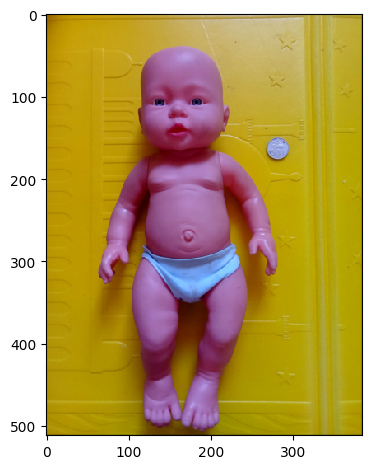

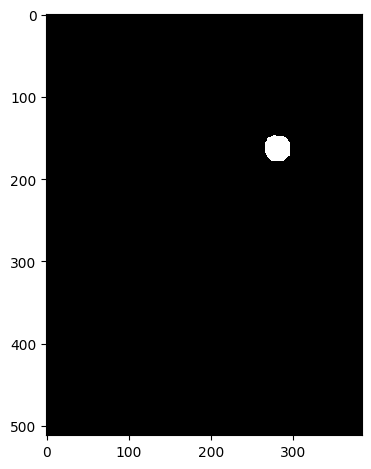

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


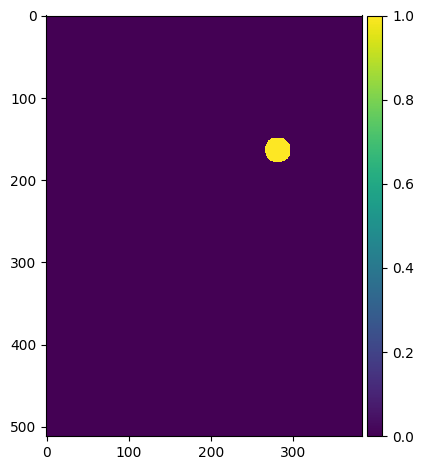

In [69]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples

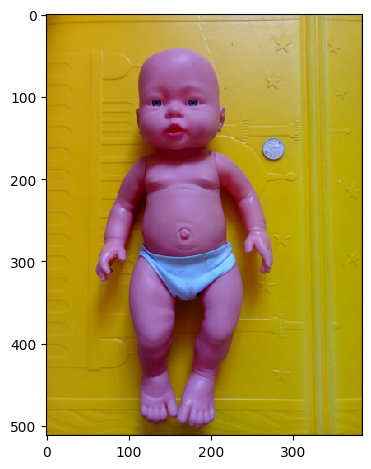

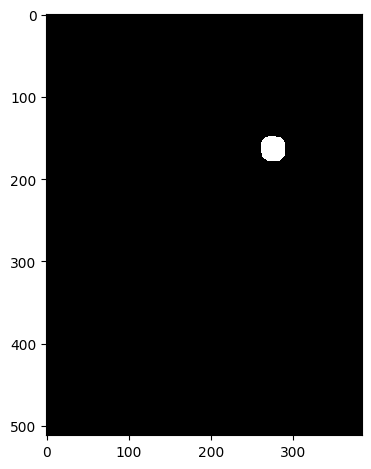

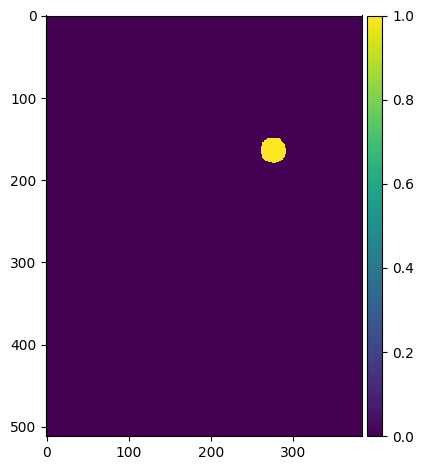

In [70]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

# Perform Prediction from Image Test

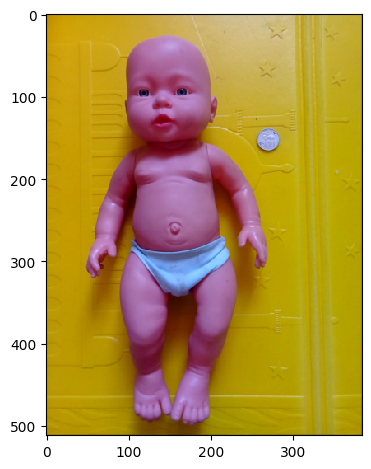

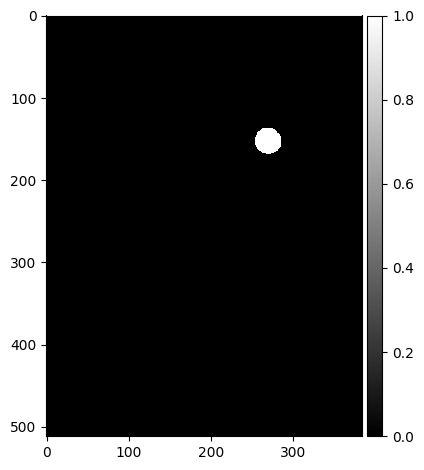

In [71]:
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()

imshow(np.squeeze(preds_test_t[ix]), cmap='gray')
plt.show()

# Saving Model

In [73]:
model.save('model_coin.keras')


# ==== Main Code Ends Here ===

In [ ]:
loaded_model = tf.keras.models.load_model('D:\\BANGKIT\\Capstone Project\\GITHUB\\model_head.keras', safe_mode=False)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
preds_test = loaded_model.predict(X_test, verbose=1)

preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


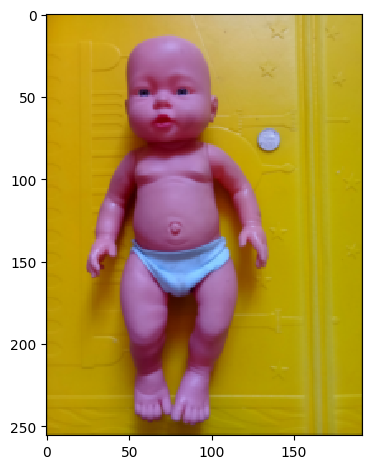

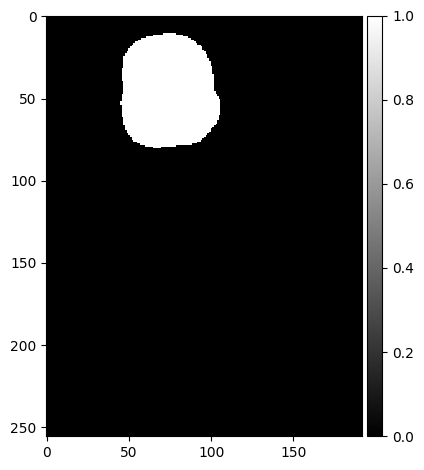

In [ ]:
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()

imshow(np.squeeze(preds_test_t[ix]), cmap='gray')
plt.show()